**Основные этапы:**
1. [Загрузка и первичный осмотр данных](#load) — понимаем структуру, типы данных и пропуски.
2. [Обработка пропусков и базовые трансформации](#cleaning) — заполнение NaN, кодирование пола, очистка возраста.
3. [Обработка опыта работы (Experience)](#experience) — разворачивание JSON, расчет длительности работы в месяцах.
5. [Обработка образования (Education)](#education) — кодирование уровней (бакалавр/магистр), парсинг вузов и сопоставление с рейтингами.
7. [Извлечение и очистка навыков (Skills Extraction)](#skills) — NLP-пайплайн для очистки списка скиллов и отбора значимых признаков.
6. [Нормализация должностей](#titles) — приведение названий профессий к стандартному таксономию (Junior/Senior, Developer/Manager).
8. [Сегментация Life-Stage](#life_stage_segmentation) — аналитика карьерного этапа кандидата на основе возраста и карьерных метрик.
9. [RFM-анализ и сегментация](#rfm) — присвоение соискателям оценок R, F, M и формирование RFM-кода для кластеризации.
10. [Структура Финального Датасета](#data_structure_final)

In [ ]:
import pandas as pd
import re
import json
import numpy as np
from difflib import SequenceMatcher
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
# !pip install langdetect googletrans==4.0.0-rc1 
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from googletrans import Translator
from tqdm.auto import tqdm
# import sys
# !{sys.executable} -m pip install nltk gensim tqdm
# !pip install nltk gensim tqdm
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
# import sys
# !{sys.executable} -m pip install tabulate

import seaborn as sns
from datetime import datetime

In [259]:
import sys
!{sys.executable} -m pip install node2vec

  Using cached node2vec-0.5.0-py3-none-any.whl (7.2 kB)



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:


df = pd.read_csv("resumes_details.csv")


<a id="load"></a>
## 1. Первичный анализ данных

**Изначальные поля датасета:**

#### 1. Идентификаторы и Метаданные
* **`resume_id`** *(object)*: Уникальный идентификатор резюме в системе (хэш). Используется для удаления дубликатов.
* **`url`** *(object)*: Прямая ссылка на резюме на сайте hh.ru. Полезна для проверки данных вручную.
* **`parsed_at`** *(object)*: Дата и время, когда резюме было скачано. Техническое поле.

#### 2. Основная информация о кандидате
* **`title`** *(object)*: Желаемая должность (заголовок резюме). Например: *"Системный администратор"*, *"Python developer"*. Это ключевой признак для определения профиля кандидата.
* **`location`** *(object)*: Город проживания кандидата. Например: *"Москва"*, *"Санкт-Петербург"*. Требует унификации.
* **`age`** *(object)*: Возраст кандидата в сыром виде. Содержит мусор (текст *"год"*, *"лет"*, *"years"*). **Требует очистки** и приведения к числу (`int`).
* **`gender`** *(object)*: Пол кандидата. Содержит разные варианты написания (*"Мужчина"*, *"Male"*, *"Женщина"*). **Требует маппинга** в бинарный формат (0/1).
* **`salary`** *(object)*: Желаемая зарплата. Очень "грязное" поле: разные валюты (RUB, USD, EUR), текст (*"на руки"*), диапазоны. **Требует приведения к единой валюте**.
* **`about`** *(object)*: Текстовое поле "О себе". Свободное описание, часто содержит софт-скиллы или мотивацию.

#### 3. Навыки (Skills)
* **`skills`** *(object)*: Список ключевых навыков в виде одной строки, разделенной символами. Пример: *"Python, SQL, Git"*.
* **`skills_count`** *(int64)*: Числовое поле — количество указанных навыков (уже подсчитано парсером).

#### 4. Опыт работы (Experience)
* **`experience_json`** *(object)*: Самое информативное поле. Содержит список словарей (JSON) со всей историей работы: названия компаний, должности, периоды работы и описание обязанностей. **Требует "разворачивания"** для анализа.
* **`experience_count`** *(int64)*: Общее количество мест работы, указанных в резюме.

#### 5. Образование (Education)
* **`education_level`** *(object)*: Уровень образования. Категориальный признак. Примеры: *"Высшее"*, *"Среднее специальное"*, *"Магистр"*. Требует кодирования.
* **`education_json`** *(object)*: Детальная информация об основном образовании в формате JSON (ВУЗ, факультет, год выпуска).
* **`education_count`** *(int64)*: Количество записей об основном образовании (например, бакалавриат + магистратура = 2).
* **`additional_education_json`** *(object)*: Информация о курсах повышения квалификации, сертификатах и тренингах (JSON).
* **`additional_education_count`** *(int64)*: Количество пройденных курсов/сертификатов.

In [128]:

df.info()

print("=== Размер датафрейма ===")
print(f"Строк: {df.shape[0]}, Столбцов: {df.shape[1]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26053 entries, 0 to 26052
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   resume_id                   26053 non-null  object
 1   url                         26053 non-null  object
 2   title                       26053 non-null  object
 3   location                    26052 non-null  object
 4   age                         24419 non-null  object
 5   gender                      26053 non-null  object
 6   salary                      14288 non-null  object
 7   skills                      26052 non-null  object
 8   skills_count                26053 non-null  int64 
 9   about                       22992 non-null  object
 10  experience_json             26053 non-null  object
 11  experience_count            26053 non-null  int64 
 12  education_json              26053 non-null  object
 13  education_count             26053 non-null  in

In [129]:
df.isnull().sum()

resume_id                         0
url                               0
title                             0
location                          1
age                            1634
gender                            0
salary                        11765
skills                            1
skills_count                      0
about                          3061
experience_json                   0
experience_count                  0
education_json                    0
education_count                   0
education_level                   0
additional_education_json         0
additional_education_count        0
parsed_at                         0
dtype: int64

<a id="cleaning"></a>
## 2. Обработка пропусков и базовые трансформации

**Стратегия заполнения пропусков:**
1.  **Категориальные признаки (`gender`):** Заполняем модой (самым частым значением), так как пропусков мало, и это наиболее вероятное значение.
2.  **Числовые признаки (`experience_count`, `education_count`):** Пропуски заполняем нулями (логика: если данных нет, значит, опыта/образования нет или не указано).
3.  **Удаление:** Убираем технические колонки (`resume_id`, `parsed_at`), не несущие пользы для моделирования. `url` на данном этапе оставляем, так как он понадобится для отслеживания правильности обработки столбцов вручную

In [130]:
# ['location', 'age', 'gender']

for col in [ 'gender']:
    most_common = df[col].mode().iloc[0]  # находит самое частое значение
    df[col] = df[col].fillna(most_common)

for col in ['experience_count', 'education_count', 'additional_education_count']:
    df[col] = df[col].fillna(0)

In [131]:
df = df.drop(columns=['resume_id', 'parsed_at']) # , 'url'

# Описательная статистика

**Что получаем:**  
- Для числовых колонок: count, mean, std, min, max и пр.  
- Для объектных (текстовых) колонок: top, freq и число уникальных значений.
Статистика

In [132]:
df.describe(include=[float, int])

,skills_count,experience_count,education_count,additional_education_count
count,26053.00000,26053.000000,26053.000000,26053.000000
mean,18.37869,6.329175,2.521168,1.807815
std,9.58100,3.371748,0.909576,3.135391
min,0.00000,0.000000,1.000000,0.000000
25%,11.00000,4.000000,2.000000,0.000000
50%,18.00000,6.000000,2.000000,0.000000
75%,27.00000,8.000000,3.000000,3.000000
max,38.00000,41.000000,23.000000,62.000000


In [133]:
df.describe(include=[object])

,url,title,location,age,gender,salary,skills,about,experience_json,education_json,education_level,additional_education_json
count,26053,26053,26052,24419,26053,14288,26052,22992,26053,26053,26053,26053
unique,26053,13557,1119,119,8,761,24731,22766,25435,25235,24,11208
top,https://hh.ru/resume/2c7342a80008a535640039ed1f466456413152?query=%D0%92%D0%B5%D0%B1+%D0%B4%D0%B8%D0%B7%D0%B0%D0%B9%D0%BD%D0%B5%D1%80&searchRid=17622856268450a7a5ac5598d2719027&hhtmFrom=resume_search_result,Системный администратор,Москва,31 год,Мужчина,100 000 ₽ на руки,"Русский — Родной, Английский — A1 — Начальный",В последние годы проходил обучение без возможности работать.,[],"[{""name"": null, ""organization"": null, ""period"": null, ""level"": null, ""result"": null}]",Высшее образование,[]
freq,1,1100,5881,1130,17621,1104,196,51,602,662,13296,14788


В столбцах age и gender уникальных значений больше чем должно было быть

### Нормализация возраста и пола

* **Пол (`gender`):** Переводим текстовые значения (Мужчина/Женщина/Male/Female) в бинарный формат (1 - Мужчина, 0 - Женщина).
* **Возраст (`age`):** Извлекаем числовое значение из строк вида "31 год", "25 years"

In [134]:
for col in ['age', 'gender']:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в датафрейме.\n")
        continue

    print(f"\n=== {col} ===")
    print(f"Всего непустых значений: {df[col].notna().sum()}")
    print(f"Количество уникальных (не NaN): {df[col].nunique(dropna=True)}\n")

    # Выводим значение и количество
    for val, count in df[col].value_counts(dropna=False).items():
        print(f"{repr(val)} — {count}")

    print("\n" + "-"*100 + "\n")


=== age ===
Всего непустых значений: 24419
Количество уникальных (не NaN): 119

nan — 1634
'31 год' — 1130
'33 года' — 1087
'34 года' — 1067
'30 лет' — 1053
'32 года' — 1049
'28 лет' — 1033
'29 лет' — 1022
'37 лет' — 1013
'35 лет' — 1012
'36 лет' — 1010
'27 лет' — 979
'26 лет' — 882
'38 лет' — 865
'39 лет' — 842
'25 лет' — 753
'40 лет' — 698
'41 год' — 658
'42 года' — 616
'24 года' — 524
'43 года' — 516
'44 года' — 426
'45 лет' — 404
'46 лет' — 338
'23 года' — 330
'47 лет' — 292
'48 лет' — 283
'49 лет' — 260
'50 лет' — 220
'51 год' — 216
'52 года' — 165
'22 года' — 160
'53 года' — 157
'36 years' — 133
'38 years' — 131
'55 лет' — 124
'54 года' — 122
'37 years' — 121
'34 years' — 116
'35 years' — 113
'56 лет' — 105
'40 years' — 104
'41 year' — 104
'29 years' — 97
'39 years' — 95
'32 years' — 93
'33 years' — 93
'31 year' — 85
'58 лет' — 79
'57 лет' — 78
'42 years' — 76
'46 years' — 74
'43 years' — 73
'28 years' — 73
'30 years' — 73
'44 years' — 69
'27 years' — 68
'45 years' — 68
'59 лет'

In [135]:
gender_map = {
    'Мужчина': 1,
    'Male': 1,
    'Ер': 1,
    'Kishi': 1,
    'Женщина': 0,
    'Female': 0,
    'Әйел': 0
}

df['gender'] = df['gender'].map(gender_map)


In [136]:
def extract_age(age_str):
    if pd.isna(age_str):
        return None
    match = re.search(r'\d+', str(age_str))
    return int(match.group()) if match else None

df['age'] = df['age'].apply(extract_age)

### 3. Парсинг зарплат (`salary`)

Поле `salary` содержит разнородные данные: "100 000 руб", "2000 USD", "от 500 EUR".

**Логика обработки:**
1.  Определяем валюту и конвертируем в Рубли по фиксированному курсу.
2.  Обрабатываем множители (например, "5k" -> 5000).
3.  Если указан диапазон ("100-150к"), берем среднее арифметическое.

In [137]:
# Примерные курсы валют к рублю
currency_to_rub = {'USD': 100, 'EUR': 110, 'RUB': 1}

def parse_salary(s):
    if pd.isna(s):
        return None
    s = str(s).lower().replace(' ', '')
    
    # Определяем валюту
    if 'usd' in s or '$' in s:
        currency = 'USD'
    elif 'eur' in s or '€' in s:
        currency = 'EUR'
    elif 'руб' in s or 'р' in s or '₽' in s:
        currency = 'RUB'
    else:
        currency = 'RUB'  # по умолчанию рубли

    # Определяем множитель (k, тыс.)
    multiplier = 1
    if 'k' in s or 'тыс' in s:
        multiplier = 1000

    numbers = re.findall(r'\d+', s)
    if not numbers:
        return None
    numbers = [int(n) for n in numbers]

    # Если диапазон, берём среднее
    salary = sum(numbers) / len(numbers)

    # Переводим в рубли
    salary_rub = salary * multiplier * currency_to_rub[currency]
    return salary_rub

df['salary'] = df['salary'].apply(parse_salary)



После выполнения очистки и приведения ключевых признаков (`age`, `salary`, `gender`) к числовому формату, мы проводим повторный анализ статистики.

Также проводим **расчет квантилей (5% и 95%):** Этот шаг позволяет быстро определить **реалистичный рабочий диапазон** распределения данных и установить, сколько записей из JSON-полей (`experience_json`, `education_json`) имеет смысл включать в анализ.

In [138]:
df.describe(include=[float, int])

,age,gender,salary,skills_count,experience_count,education_count,additional_education_count
count,24419.000000,26052.000000,14288.000000,26053.00000,26053.000000,26053.000000,26053.000000
mean,35.937385,0.757984,1635.974629,18.37869,6.329175,2.521168,1.807815
std,8.626697,0.428312,7980.961737,9.58100,3.371748,0.909576,3.135391
min,14.000000,0.000000,0.333333,0.00000,0.000000,1.000000,0.000000
25%,29.000000,1.000000,40.000000,11.00000,4.000000,2.000000,0.000000
50%,35.000000,1.000000,75.000000,18.00000,6.000000,2.000000,0.000000
75%,41.000000,1.000000,150.000000,27.00000,8.000000,3.000000,3.000000
max,122.000000,1.000000,104500.000000,38.00000,41.000000,23.000000,62.000000


In [139]:
df.describe(include=[object])

,url,title,location,skills,about,experience_json,education_json,education_level,additional_education_json
count,26053,26053,26052,26052,22992,26053,26053,26053,26053
unique,26053,13557,1119,24731,22766,25435,25235,24,11208
top,https://hh.ru/resume/2c7342a80008a535640039ed1f466456413152?query=%D0%92%D0%B5%D0%B1+%D0%B4%D0%B8%D0%B7%D0%B0%D0%B9%D0%BD%D0%B5%D1%80&searchRid=17622856268450a7a5ac5598d2719027&hhtmFrom=resume_search_result,Системный администратор,Москва,"Русский — Родной, Английский — A1 — Начальный",В последние годы проходил обучение без возможности работать.,[],"[{""name"": null, ""organization"": null, ""period"": null, ""level"": null, ""result"": null}]",Высшее образование,[]
freq,1,1100,5881,196,51,602,662,13296,14788


In [140]:
cols = [
    "skills_count",
    "experience_count",
    "education_count",
    "additional_education_count"
]

quantiles = [0.05, 0.10, 0.15, 0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95]

# вывод расширенной статистики по квантилям
desc = df[cols].describe(percentiles=quantiles)
print(desc)

       skills_count  experience_count  education_count  \
count   26053.00000      26053.000000     26053.000000   
mean       18.37869          6.329175         2.521168   
std         9.58100          3.371748         0.909576   
min         0.00000          0.000000         1.000000   
5%          3.00000          2.000000         2.000000   
10%         5.00000          2.000000         2.000000   
15%         7.00000          3.000000         2.000000   
25%        11.00000          4.000000         2.000000   
50%        18.00000          6.000000         2.000000   
75%        27.00000          8.000000         3.000000   
80%        29.00000          9.000000         3.000000   
85%        31.00000         10.000000         3.000000   
90%        32.00000         11.000000         4.000000   
95%        32.00000         12.000000         4.000000   
max        38.00000         41.000000        23.000000   

       additional_education_count  
count                26053.000000  

### 4. Обработка и унификация локаций (Location) 

Для устранения дубликатов, вызванных разными языками (`Moscow` vs. `Москва`), мы использовали контекстный подход. Сначала был определен язык каждого резюме по содержимому поля `about`. Если язык не русский, название города автоматически переводилось на русский язык с помощью библиотеки `googletrans`, что обеспечило масштабную унификацию локаций.

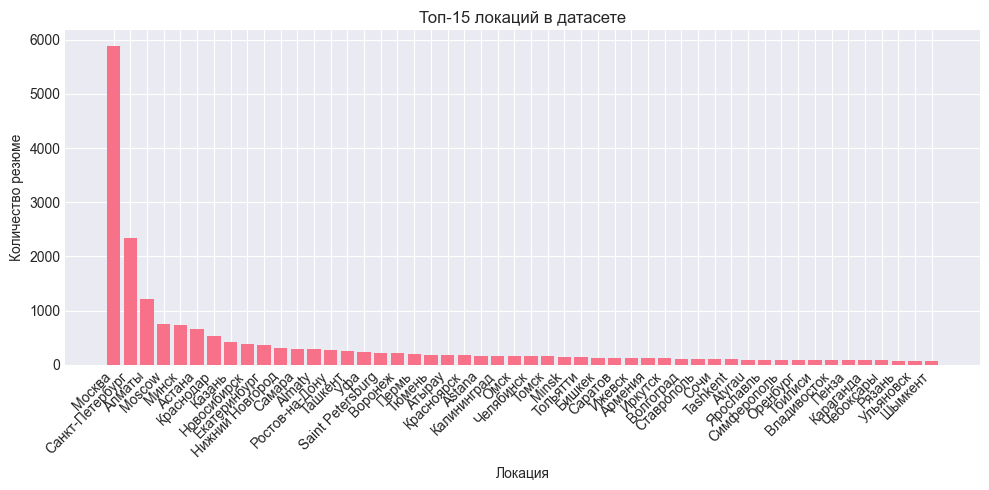

In [141]:

# Считаем частоты
loc_counts = df['location'].value_counts()

# Берём топ-15
top_locs = loc_counts.head(50)

plt.figure(figsize=(10, 5))
plt.bar(top_locs.index, top_locs.values)
plt.title("Топ-15 локаций в датасете")
plt.xlabel("Локация")
plt.ylabel("Количество резюме")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [142]:
df['location'].isnull().sum()


np.int64(1)

In [143]:
tqdm.pandas()
translator = Translator()
CONTEXT_COLUMN = 'about'

In [ ]:
# Кэш для ускорения:
LANGUAGE_CACHE = {}

def get_language(text):
    """Определяет язык текста, используя кэш."""
    if pd.isna(text) or not isinstance(text, str) or len(text) < 20:
        return 'ru' # Слишком короткий текст считаем русским по умолчанию
    
    key = text[:50] # Ключ по первым 50 символам
    if key in LANGUAGE_CACHE:
        return LANGUAGE_CACHE[key]
    
    try:
        lang = detect(text)
        LANGUAGE_CACHE[key] = lang
        return lang
    except LangDetectException:
        # Если не удалось определить язык (много цифр, мусор)
        LANGUAGE_CACHE[key] = 'unknown'
        return 'unknown'
print("Определение языка резюме...")
df['resume_language'] = df[CONTEXT_COLUMN].progress_apply(get_language)

Определение языка резюме...


100%|██████████| 26053/26053 [01:12<00:00, 359.64it/s]


In [145]:

language_counts = df['resume_language'].value_counts()

print("Распределение резюме по языкам:")
print(language_counts)


Распределение резюме по языкам:
resume_language
ru         22559
en          2984
bg           168
et            99
unknown       89
mk            33
uk            12
ro            11
nl             9
de             9
fr             8
da             8
af             8
ca             7
no             6
sv             6
tr             5
it             5
tl             5
sl             4
id             3
vi             2
cy             2
hr             2
pt             2
es             2
fi             1
sq             1
sk             1
sw             1
pl             1
Name: count, dtype: int64


In [146]:

TRANSLATION_CACHE = {}

def translate_location_if_needed(row):
    """Переводит локацию на русский, если язык резюме не 'ru'."""
    location = row['location']
    lang = row['resume_language']
    
    if pd.isna(location) or lang == 'ru' or lang == 'unknown':
        return location
        
    key = (location.strip().lower(), lang)
    if key in TRANSLATION_CACHE:
        return TRANSLATION_CACHE[key]

    try:
        # Пытаемся перевести на русский (dest='ru')
        translated = translator.translate(location, dest='ru').text
        
        # Проверяем, что перевод не является техническим мусором или ошибкой
        if translated and translated.strip().lower() != location.strip().lower():
             TRANSLATION_CACHE[key] = translated.strip()
             return translated.strip()
        
        # Если перевод не изменил строку (скорее всего, она уже русская/ошибка), возвращаем оригинал
        TRANSLATION_CACHE[key] = location.strip()
        return location.strip()
        
    except Exception:
        # В случае ошибки перевода
        TRANSLATION_CACHE[key] = location.strip()
        return location.strip()
print("Перевод нерусских локаций...")
df['location_new'] = df.progress_apply(translate_location_if_needed, axis=1)

df['location'] = df['location_new']
df.drop(columns=['location_new'], inplace=True)

Перевод нерусских локаций...


100%|██████████| 26053/26053 [03:53<00:00, 111.72it/s]


### 4 Визуальный осмотр сырых категориальных признаков

Мы полное содержимое ключевых текстовых и JSON-колонок (`skills`, `about`, `*\_json`) для одного  резюме перед тем, как приступать к их многоступенчатому очистке.

In [ ]:
# отключаем сокращённый вывод
pd.set_option('display.max_colwidth', None)
cols = [
    "title",
    "skills",
    "about",
    "experience_json",
    "education_json",
    "additional_education_json"
]

# вывод полной строки по этим колонкам
print(df.loc[15, cols])

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

<a id="experience"></a>
## 4. Обработка опыта работы (`experience_json`)

Данные об опыте хранятся в JSON-формате (список мест работы). Мы разворачиваем этот список в  структуру таблицы.

1.   Извлекаем поля `position`, `company`, `period`, `description` для каждого места работы.
2.   Берем до 4 последних мест работы (создаем колонки `job_1_...` до `job_5_...`).
3.  * Парсим строки вида "3 года 2 месяца" -> переводим в месяцы (`duration_months`).
    * Определяем флаг `is_current` (текущее место работы), если в дате есть "по настоящее время".
    * Добавляем флаг `is_top_it_company_flag`, указывающий, работал ли кандидат хотя бы на одном из мест работы в компании из заранее определенного списка топ-IT компаний.

In [ ]:
MAX_JOBS = 4

def expand_experience(row):
    try:
        experiences = json.loads(row['experience_json'])
        if not isinstance(experiences, list):
            experiences = []
    except (json.JSONDecodeError, TypeError):
        experiences = []

    # --- Удаляем полные дубликаты внутри списка ---
    unique_jobs = []
    seen = set()
    for job in experiences:
        # формируем ключ для проверки дублей
        key = (
            job.get('position', '').strip() if job.get('position') else '',
            job.get('company', '').strip() if job.get('company') else '',
            job.get('period', '').strip() if job.get('period') else '',
            job.get('description', '').strip() if job.get('description') else ''
        )
        if key not in seen:
            seen.add(key)
            unique_jobs.append(job)

    unique_jobs = unique_jobs[-MAX_JOBS:]

    expanded = {}
    for i in range(MAX_JOBS):
        if i < len(unique_jobs):
            job = unique_jobs[i]
            expanded[f'job_{i+1}_position'] = job.get('position', np.nan)
            expanded[f'job_{i+1}_company'] = job.get('company', np.nan)
            expanded[f'job_{i+1}_period'] = job.get('period', np.nan)
            expanded[f'job_{i+1}_description'] = job.get('description', np.nan)
        else:
            expanded[f'job_{i+1}_position'] = np.nan
            expanded[f'job_{i+1}_company'] = np.nan
            expanded[f'job_{i+1}_period'] = np.nan
            expanded[f'job_{i+1}_description'] = np.nan

    return pd.Series(expanded)

expanded_jobs_df = df.apply(expand_experience, axis=1)

df = pd.concat([df, expanded_jobs_df], axis=1)


In [ ]:
duplicate_rows = []
for idx, row in df.iterrows():
    jobs = []
    for i in range(1, MAX_JOBS + 1):
        pos = row.get(f'job_{i}_position')
        comp = row.get(f'job_{i}_company')
        per = row.get(f'job_{i}_period')
        desc = row.get(f'job_{i}_description')

        # Если все поля NaN, прекращаем проверку
        if pd.isna(pos) and pd.isna(comp) and pd.isna(per) and pd.isna(desc):
            continue

        job_tuple = (pos, comp, per, desc)
        # Проверяем, есть ли такой же кортеж в списке jobs
        if job_tuple in jobs:
            duplicate_rows.append(idx)
            break 
        jobs.append(job_tuple)

# Где нашли дубли
duplicate_rows = list(set(duplicate_rows))
print(f"Найдено {len(duplicate_rows)} резюме с дублирующимися позициями в первых {MAX_JOBS} слотах.")

position_cols = [f'job_{i}_position' for i in range(1, MAX_JOBS + 1)]
company_cols = [f'job_{i}_company' for i in range(1, MAX_JOBS + 1)]
df_duplicates = df.loc[duplicate_rows, position_cols + company_cols]

Найдено 0 резюме с дублирующимися позициями в первых 4 слотах.


Здесь и далее будет частый вывод статистики пропусков (`df.isnull().sum()`) после сложных операций для контроля их правильности.

In [150]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 1
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329


In [151]:

def parse_period(period_str):
    """
    Универсальный парсер периода для рус/англ/казах.
    Возвращает:
        - duration в месяцах
        - флаг текущей работы (1/0)
    """
    if not isinstance(period_str, str):
        return np.nan, np.nan

    s = period_str.lower()

    # Флаг текущей работы
    is_current = 1 if any(x in s for x in ["по настоящее время", "currently", "present", "қазіргі уақытқа дейін"]) else 0

    # Ищем годы
    years_match = re.search(r'(\d+)\s*(?:год|года|лет|year|years|жыл)', s, flags=re.IGNORECASE)
    years = int(years_match.group(1)) if years_match else 0

    # Ищем месяцы
    months_match = re.search(r'(\d+)\s*(?:месяц|месяца|месяцев|month|months|ай|oylar)', s, flags=re.IGNORECASE)
    months = int(months_match.group(1)) if months_match else 0

    # duration в месяцах
    duration_months = years*12 + months if (years_match or months_match) else np.nan

    return duration_months, is_current

period_cols = [f'job_{i}_period' for i in range(1, MAX_JOBS + 1)]

for col in period_cols:
    duration_col = col.replace('_period', '_duration_months')
    is_current_col = col.replace('_period', '_is_current')
    df[[duration_col, is_current_col]] = df[col].apply(lambda x: pd.Series(parse_period(x)))


In [152]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 1
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329
job_1_duration_months: 603
job_1_is_current: 602
job_2_duration_months: 2636
job_2_is_current: 2635
job_3_duration_months: 5084
job_3_is_current: 5083
job_4_duration_months: 8330
job_4_is_current: 8329


Ищем записи, которые не удалось распарсить

In [153]:

total_unparsed_mask = pd.Series(False, index=df.index)

for i in range(1, MAX_JOBS + 1):
    period_col = f'job_{i}_period'
    duration_col = f'job_{i}_duration_months'
    
    mask = df[period_col].notna() & df[duration_col].isna()
    total_unparsed_mask = total_unparsed_mask | mask

total_unparsed_count = total_unparsed_mask.sum()
print(f"Общее количество строк (резюме) с нераспарсенным периодом в первых {MAX_JOBS} позициях: {total_unparsed_count}")

# 3. Удаляем строки, для которых парсинг не удался
df_before_drop = len(df)
df = df[~total_unparsed_mask].copy()

print(f"Удалено строк: {df_before_drop - len(df)}")
print(f"Осталось строк в датасете: {len(df)}")

Общее количество строк (резюме) с нераспарсенным периодом в первых 4 позициях: 1
Удалено строк: 1
Осталось строк в датасете: 26052


In [ ]:
import pandas as pd
import re
from typing import Set, Any

MAX_JOBS = 4 
def normalize_company_name(name: str) -> str:
    """
    Приводит название компании к нижнему регистру, удаляет знаки препинания, 
    формы собственности (ООО, ПАО, LLC и т.д.) и лишние пробелы.
    """
    if not isinstance(name, str) or not name.strip():
        return ""
    
    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name)
    
    # Удаление распространенных форм собственности
    stop_words = [
        r'\s*ооо\s*', r'\s*ао\s*', r'\s*пао\s*', r'\s*оао\s*', r'\s*зао\s*', 
        r'\s*ип\s*', r'\s*гк\s*', r'\s*нп\s*', r'\s*ано\s*', r'\s*фгуп\s*',
        r'\s*llc\s*', r'\s*inc\s*', r'\s*corp\s*', r'\s*ltd\s*', r'\s*sa\s*',
        r'\s*ao\s*', r'\s*zao\s*', r'\s*open joint stock company\s*'
    ]
    for sw in stop_words:
        name = re.sub(sw, ' ', name)
        
    name = re.sub(r'\s+', ' ', name).strip()
    return name
TOP_IT_COMPANIES_NORMALIZED: Set[str] = {
    "яндекс", "yandex", "яндекс проект", "яндекс маркет",
    "вк", "vk", "mailru", "mail ru", "mail.ru", "вконтакте",
    "сбер", "sber", "сбербанк", "sberbank", "сбертех", "sbertech",
    "тинькофф", "tinkoff", "тинькофф банк", "tinkoff bank",
    "авито", "avito",
    "озон", "ozon",
    "wildberries", "вайлдберриз", "вайлдберриз",
    "mvideo", "мвидео",
    "ozon logistics", "ozonlogistics",
    "2гис", "2gis",
    "лаборатория касперского", "kaspersky", "kaspersky lab", "касперский",
    "positive technologies", "позитив технологис", "позитив",
    "drweb", "доктор веб", "doctor web",
    "cybertrust", "кибертраст",
    "jetbrains", "джетбрейнс",
    "1c", "1с",
    "ланит", "lanit",
    "крок", "croc",
    "наумен", "naumen",
    "т1", "t1 holding", "t1", "ти1",
    "инфосистемы джет", "infosystems jet", "infosystemsjet",
    "ибс", "ibs",
    "ядро", "yadro",
    "selectel", "селектел", "selectel cloud",
    "softline", "софтлайн",
    "ocs distribution", "ocs", "ocs distribution russia",
    "nix", "nix solutions", "nixsolutions",
    "itbox", "айтибокс",
    "mail group", 
    "headhunter", "хедхантер", "hh", "hh.ru",
    "циан", "cian", "domclick", "домклик", "дом клик",
    "wildberries","вб", "яндекс маркет", "ozon", "avito", "lamoda", "ламода",
    "beru", "беру",
    "ростелеком", "rostelecom",
    "мтс web services", "мтс", "mts", "mts web",
    "мегафон", "megafon",
    "tele2", "теле2",
    "альфа банк", "alfabank", "альфа", "alfagroup",
    "точка", "tochka",
    "росбанк", "rosbank",
    "втб", "vtb", "vtb digital",
    "касса",
    "тинькофф", "tinkoff",
    "qiwi", "киви",
    "yoomoney", "юманей", "юмани", "yandex money",
    "epam", "epam systems", "эпам",
    "andersen", "andersen labs", "andersen lab", "андерсен",
    "ciklum", "циклюм",
    "itechart", "айтчарт",
    "oleg",  
    "скб контур", "skb kontur", "контур",
    "artvell", "артвелл", "artwell", "artvell", "артвелл", "artvell technologies",
    "galaktika", "галактика",
    "redsoft", "ред софт", "red soft",
    "ametist", "аметист",
    "agrtech", 
    "икс холдинг", "xholding", "x holding", "иксхолдинг",
    "группа plus", "группа плюс", "плюс", "plus group",
    "astel", "астел", "astra group", "гк астра",
    "kaspi", "каспи", "kaspi bank", "kaspi.kz",
    "halyk bank", "халык банк", "halyk",
    "kolesakz", "колесакз", "kolesa", "kolesa group",
    "kolesa.kz", 
    "epm", 
    "epam", "epam systems",
    "wargaming", "варгейминг",
    "viber", "вайбер",
    "globant", 
    "hitech интеграция", "хайтек интеграция", "hitech integration",
    "unitech", "унитех",
    "3logic", "3logic group",
    "k2tech", "к2тех",
    "gmcs", "гмкс", "gmcs group",
    "c-terra", "с-терра", "с терра",
    "ispring", "айспринг",
    "agima", "агима",
    "directum", "директум",
    "s-terra csp", "с терра сип",
    "safetyinfo", "защитainfo",
    "ibm russia", "ibm", "ibm russia",
    "oracle russia", "oracle",
    "microsoft russia", "microsoft",
    "sap", "sap russia",
    "softline distribution", "softline",
    "merlion", "мерлион",
    "dcinternational", "dc international",
    "ingram micro", "ingrammicro",
    "itmo", "итмо",  
    "it group", "itg",  
    "itfb group", "itfb",
    "it-solutions", "it solutions",
    "infowatch", "инфовотч",
    "croc", "крок",
    "lanit", "ланит",
    "yadro", "ядро",
    "systematika", "систематика",
    "ocs", "ocs distribution",
    "centrist", "центрист",  
    "edison", "эдисон", 
    "sbercloud", "сберклауд", "sber cloud",
    "mts cloud", "mts cloud services",
    "mail cloud", "mail cloud services",
    "my.games", "mygames", "майгеймс",
    "my dot games", "my.games studios",
    "gameland", "геймленд",
    "gameloft", "гамелофт", 
    "yadro analytics", "yadro analytics",
    "cian analytics", "cian analytics",
    "skoltech", "сколтех",
    "msu", "мгу", 
    "itg", "itg group",
    "itautotech", "итаутотек",
    "it bastion", "айт и бастион", "айтбастион",
    "prooftech it", "pruftek", "пруфтек",
    "redlab", "редлаб",
    "cloud networks", "cloudnetworks", "cloud networks russia",
    "south software company", "южная софтверная компания",
    "gmcs group", "gmcs",
    "cybersec", "киберсек",
    "epam", "epam systems", "epm", "ипам", 
    "kaspersky", "касперский", "kasperskiy",
    "hh", "headhunter", "хх", "хедхантер",
}


def check_top_company_flag(row: pd.Series, max_jobs: int, top_set: Set[str]) -> int:
    """
    Проверяет все поля job_i_company в строке DF на наличие топовой компании.
    Возвращает 1, если найдено совпадение, иначе 0.
    """
    for i in range(1, max_jobs + 1):
        company_key = f'job_{i}_company'
        raw_company_name: Any = row.get(company_key)
        
        if not isinstance(raw_company_name, str) or pd.isna(raw_company_name):
            continue
        
        # Нормализация
        normalized_name: str = normalize_company_name(raw_company_name)
        
        # Точное сопоставление
        if normalized_name in top_set:
            return 1
            
    return 0


df['is_top_it_company_flag'] = df.apply(
    check_top_company_flag, 
    axis=1, 
    max_jobs=MAX_JOBS, 
    top_set=TOP_IT_COMPANIES_NORMALIZED
)

In [201]:

company_cols = [f'job_{i}_company' for i in range(1, MAX_JOBS + 1)]

print("## 10 Примеров, где is_top_it_company_flag = 1")
df_flag_1 = df[df['is_top_it_company_flag'] == 1].head(10)
if not df_flag_1.empty:
    print(df_flag_1[company_cols + ['is_top_it_company_flag']])
else:
    print("Не найдено записей с флагом 1 в первых 10 строках.")

print("\n" + "="*80 + "\n")

print("## 10 Примеров, где is_top_it_company_flag = 0")
df_flag_0 = df[df['is_top_it_company_flag'] == 0].head(10)
if not df_flag_0.empty:
    print(df_flag_0[company_cols + ['is_top_it_company_flag']])
else:
    print("Не найдено записей с флагом 0 в первых 10 строках.")

## 10 Примеров, где is_top_it_company_flag = 1
        job_1_company  \
12           Сбербанк   
17           SberTech   
19     Е-Лайт-Телеком   
32               Сбер   
34             Яндекс   
37               Сбер   
50   Urban University   
62           РТИ, ОАО   
74               Сбер   
103            Яндекс   

                                                                                            job_2_company  \
12                                                                                                    NaN   
17                                                                                             Cleverbots   
19                                                                                       ГК Орион-Телеком   
32                                                                                                 ОКЕНИТ   
34                                                                                                А1, ООО   
37                     

In [ ]:

df.to_csv('dataset_with_periods.csv', index=False, encoding='utf-8')


<a id="education"></a>
## 5. Обработка образования и Рейтинги

### 5.1 Кодирование уровня образования
Приводим текстовые описания (`education_level`) к порядковой шкале:

* 1	Среднее образование

* 2	Среднее специальное образование

* 3	Неоконченное высшее образование

* 4	Бакалавр

* 5	Магистр

* 6	Кандидат наук / PhD / Доктор наук

* 0	Прочие


In [155]:
for col in ['education_level']:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в датафрейме.\n")
        continue

    print(f"\n=== {col} ===")
    print(f"Всего непустых значений: {df[col].notna().sum()}")
    print(f"Количество уникальных (не NaN): {df[col].nunique(dropna=True)}\n")

    # Выводим значение и количество
    for val, count in df[col].value_counts(dropna=False).items():
        print(f"{repr(val)} — {count}")

    print("\n" + "-"*100 + "\n")


=== education_level ===
Всего непустых значений: 26052
Количество уникальных (не NaN): 23

'Высшее образование' — 13296
'Высшее образование (Бакалавр)' — 2694
'Среднее специальное образование' — 2274
'Высшее образование (Магистр)' — 2165
'Неоконченное высшее образование' — 1953
'Higher education' — 1506
'Образование' — 636
'Higher education (master)' — 450
'Higher education (bachelor)' — 404
'Высшее образование (Кандидат наук)' — 212
'Среднее образование' — 163
'Incomplete higher education' — 90
'Secondary special education' — 73
'Higher education (PhD)' — 62
'Education' — 26
'Высшее образование (Доктор наук)' — 21
'Higher education (Doctor of Science)' — 12
'Secondary education' — 9
'Жоғары білімі' — 2
"Oliy ma'lumot (bakalavr)" — 1
"O'rta maxsus ta'lim" — 1
'Жоғары білімі (Бакалавр)' — 1
'Жоғары білімі (Магистр)' — 1

----------------------------------------------------------------------------------------------------



In [156]:
def encode_education(row):
    edu = row['education_level']
    count = row.get('education_count', None)

    if pd.isna(edu):
        return 0  # прочие

    edu_lower = str(edu).lower()

    
    if 'магистр' in edu_lower or 'master' in edu_lower:
        return 5
    elif 'кандидат' in edu_lower or 'phd' in edu_lower or 'доктор' in edu_lower:
        return 6
    elif 'неоконченное' in edu_lower or 'incomplete' in edu_lower:
        return 3
    elif 'среднее специальное' in edu_lower or 'secondary special' in edu_lower or "o'rta maxsus" in edu_lower:
        return 2
    elif 'среднее образование' in edu_lower or 'secondary education' in edu_lower:
        return 1
    elif 'бакалавр' in edu_lower or 'bachelor' in edu_lower or 'высшее образование' in edu_lower or 'higher education' in edu_lower or 'жоғары білімі' in edu_lower:
        return 4
    else:
        return 0
    

df['education_level'] = df.apply(encode_education, axis=1)


In [ ]:

pd.set_option('display.max_colwidth', None)

# нужные столбцы
cols = [
    "education_json"
]

# вывод полной строки по этим колонкам
print(df.loc[5989, cols])

education_json    [{"name": "ОГТУАТЭ", "organization": "ИС , Информационные системы", "period": "2013", "level": null, "result": null}, {"name": "ОГТУАТЭ", "organization": "ИС , Информационные системы", "period": "2013", "level": null, "result": null}]
Name: 5989, dtype: object




Выводим **распределение частот** для каждого уникального значения в столбце `education_level` для понимания, какие уровни образования являются наиболее распространенными

In [158]:
for val, count in df['education_level'].value_counts().items():
        print(f"{val} — {count}")

4 — 17915
5 — 2616
2 — 2348
3 — 2043
0 — 663
6 — 295
1 — 172


Выводим **примеры сырых JSON-структур** из колонки `education_json` для каждого уровня образования с целью **визуальной верификации** корректности классификации: убедиться, что **Высшее образование** содержит записи о ВУЗах, а **Среднее** — о техникумах/школах, подтверждая таким образом, что ручной маппинг был выполнен правильно.

In [159]:

unique_vals = df['education_level'].dropna().unique()

# Для каждого уникального значения — вывести по 2 примера education_level
for val in unique_vals:
    subset = df[df['education_level'] == val]
    examples = subset['education_json'].dropna().head(2).tolist()

    print(f"=== Примеры для education_level = {repr(val)} ===")
    if examples:
        for i, ex in enumerate(examples, start=1):
            print(f"{i}) {ex}")
    else:
        print("(нет непустых значений в education_level)")
    print("\n" + "-"*120 + "\n")



=== Примеры для education_level = np.int64(4) ===
1) [{"name": "ГГТУ им П.О.Сухого", "organization": "Машиностроительный , Разработка и эксплуатация нефтяных и газовых месторождений", "period": "2020", "level": null, "result": null}, {"name": "ГГТУ им П.О.Сухого", "organization": "Машиностроительный , Разработка и эксплуатация нефтяных и газовых месторождений", "period": "2020", "level": null, "result": null}]
2) [{"name": "Белорусский государственный университет, Минск", "organization": "Физический факультет , Научно-исследовательская деятельность", "period": "2025", "level": null, "result": null}, {"name": "Белорусский государственный университет, Минск", "organization": "Физический факультет , Научно-исследовательская деятельность", "period": "2025", "level": null, "result": null}]

------------------------------------------------------------------------------------------------------------------------

=== Примеры для education_level = np.int64(3) ===
1) [{"name": "Уфимский государс


### 5.2 Разворачивание JSON образования
Аналогично опыту работы, извлекаем данные о ВУЗах (`name`), специальностях (`organization`) и годах окончания. Ограничиваемся 3 последними образованиями.

In [ ]:
MAX_EDU = 3

def expand_education(row):
    edu_level = row.get('education_level', None)

    try:
        educations = json.loads(row.get('education_json', '[]'))
        if not isinstance(educations, list):
            educations = []
    except (json.JSONDecodeError, TypeError):
        educations = []

    # --- Удаляем дубликаты по (name, organization, period) ---
    unique_edu = []
    seen = set()
    for edu in educations:
        key = (
            edu.get('name', '').strip() if edu.get('name') else '',
            edu.get('organization', '').strip() if edu.get('organization') else '',
            edu.get('period', '').strip() if edu.get('period') else ''
        )
        if key not in seen:
            seen.add(key)
            unique_edu.append(edu)

    # Ограничиваем до последних MAX_EDU записей
    unique_edu = unique_edu[-MAX_EDU:]

    expanded = {}
    for i in range(MAX_EDU):
        if i < len(unique_edu):
            edu = unique_edu[i]

            # Университет (name)
            expanded[f'edu_{i+1}_org'] = edu.get('name', np.nan)

            # Специальность / направление (organization)
            expanded[f'edu_{i+1}_major'] = edu.get('organization', np.nan)

            # Год окончания
            period_val = edu.get('period', np.nan)
            expanded[f'edu_{i+1}_period'] = period_val

            # === ограничение только для третьего образования ===
            if (i + 1) == 3 and (pd.isna(edu_level) or edu_level != 6):
                expanded[f'edu_{i+1}_org'] = np.nan
                expanded[f'edu_{i+1}_major'] = np.nan
                expanded[f'edu_{i+1}_period'] = np.nan

        else:
            expanded[f'edu_{i+1}_org'] = np.nan
            expanded[f'edu_{i+1}_major'] = np.nan
            expanded[f'edu_{i+1}_period'] = np.nan

    return pd.Series(expanded)

expanded_edu_df = df.apply(expand_education, axis=1)

df = pd.concat([df, expanded_edu_df], axis=1)


In [161]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 0
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329
job_1_duration_months: 602
job_1_is_current: 602
job_2_duration_months: 2635
job_2_is_current: 2635
job_3_duration_months: 5083
job_3_is_current: 5083
job_4_duration_months: 8329
job_4_is_current: 8329
edu_1_org: 662
edu_1_major: 834
edu_1_period: 662
edu_2_org: 15738
edu_2_major: 15738
edu_2_period: 15738
edu_3_org: 25901
edu_3_major: 25901
edu_3_period: 25901


Проводим выборочный просмотр примеров (по 3 для каждого случая) с разным количеством заполненных записей об образовании (1, 2 или 3) для **визуальной верификации корректности парсинга и разворачивания** исходного JSON-поля `education_json`.

In [ ]:


# Проверяем, что все нужные столбцы есть
# cols = [
#     'edu_1_org', 'edu_1_major', 'edu_1_period',
#     'edu_2_org', 'edu_2_major', 'edu_2_period',
#     'edu_3_org', 'edu_3_major', 'edu_3_period',
#     'education_level', 'education_json'
# ]
cols = [
    'url', 'education_level', 'education_json'
]
assert all(c in df.columns for c in cols), "Не все нужные столбцы найдены в df.columns"

# Функция, которая проверяет непустое значение
def not_null(x):
    return x.notna() & (x != "") & (x != "[]")

# Только первая группа заполнена
cond_1 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    ~not_null(df['edu_2_org']) & ~not_null(df['edu_2_major']) & ~not_null(df['edu_2_period'])
) & (
    ~not_null(df['edu_3_org']) & ~not_null(df['edu_3_major']) & ~not_null(df['edu_3_period'])
)

ex1 = df.loc[cond_1, cols].head(3)

# Заполнены первые две группы, третья пустая
cond_2 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    not_null(df['edu_2_org']) & not_null(df['edu_2_major']) & not_null(df['edu_2_period'])
) & (
    ~not_null(df['edu_3_org']) & ~not_null(df['edu_3_major']) & ~not_null(df['edu_3_period'])
)

ex2 = df.loc[cond_2, cols].head(3)

# Заполнены все три группы
cond_3 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    not_null(df['edu_2_org']) & not_null(df['edu_2_major']) & not_null(df['edu_2_period'])
) & (
    not_null(df['edu_3_org']) & not_null(df['edu_3_major']) & not_null(df['edu_3_period'])
)

ex3 = df.loc[cond_3, cols].head(3)

print("=== Примеры где только первая группа заполнена ===")
print(ex1.to_string(index=False))
print("\n" + "-"*150 + "\n")

print("=== Примеры где заполнены 1 и 2 группы ===")
print(ex2.to_string(index=False))
print("\n" + "-"*150 + "\n")

print("=== Примеры где заполнены все 3 группы ===")
print(ex3.to_string(index=False))


=== Примеры где только первая группа заполнена ===
                                                                                                                                                                                                                 url  education_level                                                                                                                                                                                                                                                                                                                                                                                                                       education_json
https://hh.ru/resume/b0824b5e00041926b10039ed1f465341644234?query=Python+%D1%80%D0%B0%D0%B7%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%87%D0%B8%D0%BA&searchRid=1761762112742bdc60a087b15d49f030&hhtmFrom=resume_search_result                4                                                             [{"name"

### 5.3 Присвоение рейтинга ВУЗам 
1.  **Создание рейтинга:** В коде определен словарь **`university_ranking`**, содержащий топ престижных ВУЗов и их вариаций написания, которым присвоены числовые ранги.
2.  **Обработка названия:** Функция **`find_university_rank`** использует **строгое нечеткое сравнение (Fuzzy Matching)**, требуя **очень высокий порог схожести (>= 92%)** между названием из резюме и эталонными вариантами, чтобы избежать ложных совпадений.
3.  **Итоговый признак:** Функция **`process_universities`** просматривает **все доступные записи** об образовании (до **`MAX_EDU`** позиций) и присваивает резюме **наивысший найденный рейтинг** (наименьшее числовое значение). Если ни один из ВУЗов не попал в список, присваивается значение **999**.

In [ ]:
import pandas as pd
import re
from difflib import SequenceMatcher


MAX_EDU = 3
NOT_FOUND_RANK = 999.0
university_ranking = {
   1: {
        'names': ['московский государственный университет им м в ломоносова', 'мгу', 'msu', 
                  'lomonosov moscow state university', 'ломоносов', 'moscow state university', 
                  'мгу им ломоносова', 'мгу имени ломоносова', 'мгу ломоносова']
    },
    2: {
        'names': ['московский физико технический институт', 'мфти', 'mipt', 
                  'moscow institute of physics and technology', 'физтех', 'moscow phystech']
    },
    2.1: {
        'names': ['университет итмо', 'итмо', 'itmo', 'itmo university']
    },
    3: {
        'names': ['московский государственный технический университет им н э баумана', 'мгту им баумана', 
                  'мгту баумана', 'бауманка', 'bauman moscow state technical university', 'bmstu', 'баумана']
    },
    3.1: {
        'names': ['национальный исследовательский ядерный университет мифи', 'мифи', 'nrnu mephi', 
                  'mephi', 'moscow engineering physics institute']
    },
    4: {
        'names': ['национальный исследовательский университет высшая школа экономики', 'вшэ', 'ниу вшэ', 
                  'высшая школа экономики', 'hse', 'higher school of economics', 'hse university', 'вышка']
    },
    5: {
        'names': ['санкт петербургский государственный университет', 'спбгу', 'spbu', 
                  'saint petersburg state university', 'st petersburg state university', 'спб университет']
    },
    6: {
        'names': ['университет иннополис', 'иннополис', 'innopolis', 'innopolis university']
    },
    6.1: {
        'names': ['московский государственный технологический университет станкин', 'мгту станкин', 
                  'станкин', 'stankin', 'moscow state university of technology']
    },
    6.2: {
        'names': ['национальный исследовательский университет мэи', 'ниу мэи', 'мэи', 
                  'московский энергетический институт', 'mpei', 'moscow power engineering institute']
    },
    7: {
        'names': ['московский авиационный институт', 'маи', 'mai', 'moscow aviation institute', 'мати']
    },
    7.1: {
        'names': ['казанский приволжский федеральный университет', 'кфу', 'казанский федеральный университет', 
                  'kfu', 'kazan federal university']
    },
    7.2: {
        'names': ['национальный исследовательский технологический университет мисис', 'ниту мисис', 
                  'мисис', 'nust misis', 'misis', 'московский институт стали и сплавов']
    },
    8: {
        'names': ['новосибирский национальный исследовательский государственный университет', 
                  'нгу новосибирск', 'новосибирский университет', 'nsu', 'novosibirsk state university']
    },
    9: {
        'names': ['санкт петербургский политехнический университет петра великого', 'спбпу', 'политех спб', 
                  'peter the great st petersburg polytechnic university', 'spbpu', 'polytechnic university']
    },
    9.1: {
        'names': ['санкт петербургский государственный электротехнический университет лэти', 'лэти', 'спбгэту', 
                  'etu', 'saint petersburg electrotechnical university']
    },
    10: {
        'names': ['новосибирский государственный технический университет', 'нгту новосибирск', 
                  'nstu', 'novosibirsk state technical university']
    },
    10.1: {
        'names': ['национальный исследовательский нижегородский государственный университет им н и лобачевского', 
                  'ннгу', 'нижегородский университет', 'lobachevsky university', 'университет лобачевского', 
                  'unn', 'lobachevsky state university']
    },
    10.2: {
        'names': ['национальный исследовательский томский политехнический университет', 'тпу', 
                  'томский политех', 'tpu', 'tomsk polytechnic university']
    },
    10.3: {
        'names': ['национальный исследовательский университет московский институт электронной техники', 
                  'миэт', 'miet', 'national research university of electronic technology']
    },
    10.4: {
        'names': ['санкт петербургский государственный университет телекоммуникаций им проф м а бонч бруевича', 
                  'спбгут', 'бонч бруевич', 'bonch bruevich']
    },
    10.5: {
        'names': ['уральский федеральный университет им первого президента россии б н ельцина', 
                  'урфу', 'уральский федеральный', 'urfu', 'ural federal university']
    },
    11: {
        'names': ['ижевский государственный технический университет им м т калашникова', 
                  'ижгту', 'калашникова', 'izhevsk state technical university']
    },
    11.1: {
        'names': ['мирэа российский технологический университет', 'мирэа', 'рту мирэа', 
                  'mirea', 'russian technological university']
    },
    12: {
        'names': ['российский университет транспорта миит', 'рут миит', 'миит', 
                  'russian university of transport', 'rut miit']
    },
    12.1: {
        'names': ['томский государственный университет систем управления и радиоэлектроники', 
                  'тусур', 'tomsk state university of control systems and radioelectronics']
    },
    12.2: {
        'names': ['московский технический университет связи и информатики', 'мтуси', 
                  'moscow technical university of communications and informatics']
    },
    12.3: {
        'names': ['санкт петербургский государственный университет аэрокосмического приборостроения', 
                  'гуап', 'saint petersburg state university of aerospace instrumentation']
    },
    13: {
        'names': ['дальневосточный федеральный университет', 'двфу', 'fefu', 'far eastern federal university']
    },
    13.1: {
        'names': ['казанский национальный исследовательский технический университет им а н туполева', 
                  'книту каи', 'каи', 'kazan national research technical university']
    },
    14: {
        'names': ['тюменский государственный университет', 'тюмгу', 'university of tyumen', 'tyumen state university']
    },
    14.1: {
        'names': ['южно уральский государственный университет', 'юургу', 'susu', 'south ural state university']
    },
    14.2: {
        'names': ['балтийский государственный технический университет военмех им д ф устинова', 
                  'военмех', 'бгту военмех', 'baltic state technical university']
    },
    14.3: {
        'names': ['самарский национальный исследовательский университет им академика с п королёва', 
                  'самарский университет', 'сгау', 'королёва', 'samara university']
    },
    14.4: {
        'names': ['сибирский государственный университет телекоммуникаций и информатики', 
                  'сибгути', 'siberian state university of telecommunications and information sciences']
    },
    15: {
        'names': ['владимирский государственный университет им а г и н г столетовых', 
                  'влгу', 'столетовых', 'vladimir state university']
    },
    15.1: {
        'names': ['донской государственный технический университет', 'дгту ростов', 
                  'дгту', 'don state technical university']
    },
    15.2: {
        'names': ['волгоградский государственный университет', 'волгу', 'volgograd state university']
    },
    15.3: {
        'names': ['пермский национальный исследовательский политехнический университет', 
                  'пнипу', 'пермский политех', 'perm national research polytechnic university']
    },
    15.4: {
        'names': ['саратовский национальный исследовательский государственный университет имени н г чернышевского', 
                  'сгу саратов', 'чернышевского', 'saratov state university']
    },
    16: {
        'names': ['южно российский государственный политехнический университет нпи имени м и платова', 
                  'юргпу', 'платова', 'platov south russian state polytechnic university']
    },
    16.1: {
        'names': ['самарский государственный технический университет', 'самгту', 
                  'samara state technical university']
    },
    16.2: {
        'names': ['уфимский университет науки и технологий', 'ууниг', 
                  'ufa university of science and technology']
    },
    16.3: {
        'names': ['волгоградский государственный технический университет', 'волггту', 
                  'volgograd state technical university']
    },
    16.4: {
        'names': ['воронежский государственный университет', 'вгу воронеж', 'voronezh state university']
    },
    16.5: {
        'names': ['национальный исследовательский томский государственный университет', 
                  'тгу томск', 'томский университет', 'tomsk state university', 'tsu']
    },
    17: {
        'names': ['алтайский государственный технический университет им и и ползунова', 
                  'алтгту', 'ползунова', 'polzunov altai state technical university']
    },
    17.1: {
        'names': ['сибирский федеральный университет', 'сфу', 'сибфу', 'sibfu', 'siberian federal university']
    },
    17.2: {
        'names': ['ярославский государственный университет им п г демидова', 
                  'ярославский университет', 'ярославль демидова', 'yaroslavl state university', 'демидова']
    },
    17.3: {
        'names': ['иркутский государственный университет', 'игу иркутск', 'irkutsk state university']
    },
    17.4: {
        'names': ['нижегородский государственный технический университет им р е алексеева', 
                  'нгту нижний', 'алексеева', 'nizhny novgorod state technical university']
    },
    17.5: {
        'names': ['сибирский государственный университет науки и технологий им академика м ф решетнева', 
                  'сибгу решетнева', 'решетнева']
    },
    18: {
        'names': ['кемеровский государственный университет', 'кемгу', 'kemerovo state university']
    },
    18.1: {
        'names': ['поволжский государственный университет телекоммуникаций и информатики', 
                  'пгути', 'povolzhskiy state university of telecommunications and informatics']
    },
    18.2: {
        'names': ['омский государственный университет им ф м достоевского', 
                  'омгу', 'достоевского', 'omsk state university']
    },
    18.3: {
        'names': ['челябинский государственный университет', 'челгу', 'chelyabinsk state university']
    },
    18.4: {
        'names': ['белгородский государственный технологический университет им в г шухова', 
                  'бгту шухова', 'шухова', 'belgorod state technological university']
    },
    18.5: {
        'names': ['пензенский государственный университет', 'пензгу', 'penza state university']
    },
    18.6: {
        'names': ['пермский государственный национальный исследовательский университет', 
                  'пгниу', 'пермский университет', 'perm state university']
    },
    18.7: {
        'names': ['южный федеральный университет', 'юфу ростов', 'sfedu', 'southern federal university']
    },
    18.8: {
        'names': ['оренбургский государственный университет', 'огу оренбург', 'orenburg state university']
    },
    19: {
        'names': ['иркутский национальный исследовательский технический университет', 
                  'ирниту', 'irkutsk national research technical university']
    },
    19.1: {
        'names': ['кубанский государственный технологический университет', 
                  'кубгту', 'kuban state technological university']
    },
    19.2: {
        'names': ['омский государственный технический университет', 'омгту', 'omsk state technical university']
    },
    19.3: {
        'names': ['тульский государственный университет', 'тулгу', 'tula state university']
    },
    19.4: {
        'names': ['петрозаводский государственный университет', 'петргу', 'petrozavodsk state university']
    },
    19.5: {
        'names': ['саратовский государственный технический университет им гагарина ю а', 
                  'сгту саратов', 'гагарина', 'gagarin saratov state technical university']
    },
    19.6: {
        'names': ['тихоокеанский государственный университет', 'тогу', 'pacific national university']
    },
    20: {
        'names': ['восточно сибирский государственный университет технологий и управления', 
                  'всгуту', 'east siberia state university of technology and management']
    },
    20.1: {
        'names': ['рязанский государственный университет имени с а есенина', 
                  'ргу рязань', 'есенина', 'ryazan state university']
    }
}


def normalize_text(text):
    """
    Нормализация текста для сравнения. 
    Удаляет текст в скобках, кавычках, а также все небуквенные/нецифровые символы.
    """
    if pd.isna(text):
        return ''
    text = str(text).lower()
    
    # 1. Удаление текста в скобках (например, (Национальный исследовательский университет))
    text = re.sub(r'\([^)]*\)', ' ', text)
    # 2. Удаление кавычек, но сохранение содержимого (например, "МИСиС" -> МИСис)
    # Используем \1 для сохранения содержимого внутри кавычек
    text = re.sub(r'"([^"]*)"', r' \1 ', text)
    
    # 3. Удаляем всё кроме букв, цифр и пробелов
    text = re.sub(r'[^\wа-яё\s]', ' ', text, flags=re.UNICODE)
    # 4. Удаляем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def normalize_ranking_dict(ranking_dict):
    """Предварительная нормализация всех названий в словаре один раз."""
    normalized_dict = {}
    for rank, data in ranking_dict.items():
        normalized_dict[rank] = {
            'names': [normalize_text(name) for name in data['names']]
        }
    return normalized_dict
normalized_university_ranking = normalize_ranking_dict(university_ranking)



def find_university_rank(university_name, ranking_dict):
    """
    Ищет вуз в рейтинге, используя строгую логику:
    1. Точное совпадение (для всех названий).
    2. Вхождение подстроки (только для аббревиатур <= 5 символов).
    """
    
    if pd.isna(university_name) or university_name == '':
        return NOT_FOUND_RANK
    
    # Удаление текста после первой запятой (город, филиал и т.д.)
    if isinstance(university_name, str):
        university_name = university_name.split(',')[0].strip()
        
    normalized_search = normalize_text(university_name)
    
    if len(normalized_search) < 3:
        return NOT_FOUND_RANK
    
    for rank, data in ranking_dict.items():
        for normalized_variant in data['names']:
            
            # 1. Точное совпадение (ПРИОРИТЕТ 1 в 1)
            if normalized_search == normalized_variant:
                return rank
            
            # 2. ОГРАНИЧЕННАЯ ЛОГИКА ДЛЯ АББРЕВИАТУР (Normalized Search <= 5)
            if len(normalized_search) <= 5:
                
                # Проверяем, является ли короткое искомое имя подстрокой в варианте из словаря
                # ИЛИ наоборот (чтобы поймать 'МГУ' в 'МГУ им ломоносова' ИЛИ 'ломоносова' в 'МГУ ломоносова')
                if normalized_search in normalized_variant or normalized_variant in normalized_search:
                    
                    # Требуем высокий коэффициент сходства (>= 80%) для подтверждения, что это не случайное вхождение
                    if SequenceMatcher(None, normalized_search, normalized_variant).ratio() >= 0.8:
                         return rank
            
    return NOT_FOUND_RANK


def process_universities(df, max_edu=MAX_EDU):
    """
    Обрабатывает датафрейм, проверяя до MAX_EDU записей об образовании
    и добавляет колонки с ЛУЧШИМ рейтингом (наименьшим числом) вуза.
    """
    # Гарантируем, что работаем с копией
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
             
    df = df.copy()
    
    edu_columns = [f'edu_{i}_org' for i in range(1, max_edu + 1)]
    
    df['best_university_rank'] = NOT_FOUND_RANK
    df['best_university_name'] = ''
    
    for idx, row in df.iterrows():
        best_rank = NOT_FOUND_RANK
        best_uni_name = ''
        
        for col in edu_columns:
            if col in df.columns:
                uni_name = row[col]
                # Используем нормализованный словарь для поиска
                rank = find_university_rank(uni_name, normalized_university_ranking)
                
                if rank < best_rank:
                    best_rank = rank
                    best_uni_name = uni_name
        
        df.at[idx, 'best_university_rank'] = best_rank
        df.at[idx, 'best_university_name'] = best_uni_name
    
    return df

df = process_universities(df)

df[['edu_1_org', 'best_university_rank']].sample(30, random_state=42)

,edu_1_org,best_university_rank
10806,Cтроительный техникум,999.0
21290,"Национальный исследовательский технологический университет ""МИСиС"" (Московский институт стали и сплавов), Москва",7.2
8564,"Московский финансово-промышленный университет ""Синергия"", Москва",3.0
22648,TeachMeSkills,999.0
13349,СГУ им. Питирима Сорокина,999.0
18987,"Экибастузский инженерно-технический институт имени академика К. И. Сатпаева, Экибастуз",999.0
15082,"Московский государственный технический университет ""МАМИ"", Москва",999.0
7298,"Череповецкий государственный университет (бывш ЧГПИ, ЧГИИ), Череповец",999.0
1847,"Поволжский государственный технологический университет, Йошкар-Ола",999.0
12795,Московский Государственный Текстильный,999.0


In [164]:
df.to_csv("resumes_preprocessed.csv", index=False, encoding="utf-8-sig")

<a id="skills"></a>
## 7. Извлечение и очистка навыков (Skills Extraction)
**Ключевые шаги:**
1.  **Первичная очистка:** Разделение строки навыков на отдельные токены, удаление слов-паразитов и общих фраз (например, "опыт" или "навык").
2.  **Нормализация:** Приведение токенов к единому формату и унификация синонимов. Для этого используется алгоритм **нечеткого сопоставления** (`fuzz.partial_ratio`), чтобы соотнести похожие, но по-разному написанные навыки с одним значением.
3.  **Отбор:** Фильтрация и отбор наиболее значимых навыков для дальнейшего использования в моделях.

In [165]:
df = pd.read_csv("resumes_preprocessed.csv", encoding="utf-8-sig")

In [166]:
df[['skills']].sample()


,skills
1660,"TypeScript, JavaScript, React Native, React, Redux, HTML, CSS, RTK Query, Figma, Git, Firebase, REST API, Jest, Казахский — Родной, Английский — B2 — Средне-продвинутый, Русский — C2 — В совершенстве"


In [ ]:
ll_skills = []

for x in df['skills']:
    if isinstance(x, str): 
        skills = [s.strip().lower() for s in x.split(',')]
        all_skills.extend(skills)

unique_skills = set(all_skills)

print("Всего навыков (с повторами):", len(all_skills))
print("Уникальных навыков:", len(unique_skills))

# Создаем DataFrame с уникальными навыками
skills_df = pd.DataFrame(sorted(unique_skills), columns=['skill'])

skills_df.to_csv('unique_skills.csv', index=False, encoding='utf-8')


Всего навыков (с повторами): 2214868
Уникальных навыков: 37821


In [ ]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# ==================== КОНФИГУРАЦИЯ ====================
MIN_SKILL_FREQ = 5          # минимум упоминаний навыка
TOP_N_SKILLS = 500          # топ частотных навыков
DISCRIMINATIVE_TOP_PCT = 0.02  # 2% редких дискриминативных

# Расширенный маппинг синонимов
SKILL_SYNONYMS = {
    # Языки программирования
    'py': 'python', 'python3': 'python', 'python2': 'python',
    'js': 'javascript', 'typescript': 'javascript',
    'c sharp': 'c#', 'csharp': 'c#', 'с#': 'c#',
    'c plus plus': 'c++', 'cpp': 'c++',
    
    # Базы данных
    'postgres': 'postgresql', 'postgresql': 'sql',
    'mysql': 'sql', 'ms sql': 'sql', 'mssql': 'sql',
    'sqlserver': 'sql', 'ms sql server': 'sql',
    'oracle db': 'oracle', 'oracle database': 'oracle',
    
    # Фреймворки
    'reactjs': 'react', 'react.js': 'react',
    'vuejs': 'vue', 'vue.js': 'vue',
    'node': 'nodejs', 'node.js': 'nodejs',
    'django framework': 'django',
    'flask framework': 'flask',
    
    # DevOps
    'docker compose': 'docker',
    'k8s': 'kubernetes',
    
    # 1C варианты
    '1с': '1c', '1с предприятие': '1c',
    '1с бухгалтерия': '1c бухгалтерия',
    '1с зуп': '1c зарплата',
    
    # Adobe
    'ps': 'photoshop', 'adobe ps': 'photoshop',
    'ai': 'illustrator', 'adobe ai': 'illustrator',
    'ae': 'after effects', 'adobe ae': 'after effects',
    
    # Office
    'excel': 'ms excel', 'word': 'ms word',
    'powerpoint': 'ms powerpoint', 'ms office': 'офисные приложения',
    
    # Языки (сокращения)
    'английский родной': 'english native',
    'английский c2': 'english c2',
    'английский c1': 'english c1',
    'английский b2': 'english b2',
    'английский b1': 'english b1',
    'русский родной': 'russian native',
}

# Навыки для удаления (слишком общие или нерелевантные)
EXCLUDE_PATTERNS = [
    r'^родной$', r'^native$', r'^a1$', r'^a2$', r'^b1$', r'^b2$', r'^c1$', r'^c2$',
    r'^начальный$', r'^средний$', r'^продвинутый$', r'^в совершенстве$',
    r'^\d+$',  # только цифры
    r'^[а-яa-z]$',  # одна буква
]

# Группировка языков
LANGUAGE_MAPPING = {
    'русский родной': 'russian',
    'английский родной': 'english',
    'казахский родной': 'kazakh',
    'english c2 в совершенстве': 'english advanced',
    'english c1 advanced': 'english advanced',
    'english b2 upper intermediate': 'english intermediate',
    'english b1 intermediate': 'english basic',
}

# ==================== ФУНКЦИИ ====================

def clean_skill_string(s):
    """Базовая очистка строки навыков"""
    if pd.isna(s):
        return ''
    
    s = str(s).lower()
    # Замена разделителей
    s = s.replace(';', ',').replace('/', ',').replace('|', ',')
    # Удаление спецсимволов в скобках
    s = re.sub(r'\([^)]*\)', '', s)
    # Очистка
    s = re.sub(r'[^а-яёa-z0-9\s\+\#\.,\-]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s


def extract_skills(skill_string):
    """Извлечение отдельных навыков из строки"""
    if not skill_string:
        return []
    
    # Разделение по запятым
    parts = [p.strip() for p in skill_string.split(',')]
    
    skills = []
    for part in parts:
        if not part or len(part) < 2:
            continue
            
        # Пропуск описаний уровня языка
        if re.search(r'(a1|a2|b1|b2|c1|c2|начальный|средний|элементарный|продвинутый|совершенство)', part):
            # Извлекаем только название языка
            lang = re.sub(r'\s*(—|-)?\s*(a1|a2|b1|b2|c1|c2).*', '', part).strip()
            if lang and len(lang) > 2:
                skills.append(lang)
            continue
        
        # Удаление слов-паразитов
        part = re.sub(r'^(навык|умение|владение|опыт|знание)\s+', '', part)
        
        # Пропуск слишком общих фраз
        if part in ['работа', 'работа в команде', 'навыки', 'опыт']:
            continue
        
        skills.append(part)
    
    return skills


def normalize_skill(skill):
    """Нормализация навыка"""
    skill = skill.strip().lower()
    
    # Применение синонимов
    skill = SKILL_SYNONYMS.get(skill, skill)
    
    # Применение языковых группировок
    skill = LANGUAGE_MAPPING.get(skill, skill)
    
    # Удаление по паттернам
    for pattern in EXCLUDE_PATTERNS:
        if re.match(pattern, skill):
            return None
    
    # Минимальная длина
    if len(skill) < 2:
        return None
    
    return skill


def build_skill_frequency(df, skill_col='skills'):
    """Подсчет частотности навыков"""
    counter = Counter()
    
    for skill_string in df[skill_col]:
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized:
                counter[normalized] += 1
    
    return counter


def select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS):
    """Выбор топ-навыков по частоте"""
    # Фильтрация по минимальной частоте
    filtered = {k: v for k, v in counter.items() if v >= min_freq}
    
    # Сортировка и выбор топ-N
    sorted_skills = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    top_skills = [skill for skill, count in sorted_skills[:top_n]]
    
    return top_skills


def select_discriminative_skills(df, counter, label_col='title_norm', 
                                 min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT):
    """Выбор редких дискриминативных навыков через chi2"""
    # Редкие навыки (от min_freq до 100 упоминаний)
    rare_skills = [s for s, c in counter.items() if min_freq <= c < 100]
    
    if len(rare_skills) == 0 or label_col not in df.columns:
        return []
    
    # Построение матрицы навыков
    n = len(df)
    skill_matrix = np.zeros((n, len(rare_skills)), dtype=int)
    
    for i, skill_string in enumerate(df['skills']):
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        normalized_skills = {normalize_skill(s) for s in skills if normalize_skill(s)}
        
        for j, skill in enumerate(rare_skills):
            if skill in normalized_skills:
                skill_matrix[i, j] = 1
    
    # Обработка меток
    labels = df[label_col].fillna('').astype(str)
    labels = labels.str.split(',').str[0].str.strip()
    
    # Фильтрация пустых меток
    mask = labels != ''
    skill_matrix = skill_matrix[mask]
    labels = labels[mask]
    
    if len(labels) < 10:
        return []
    
    # Chi2 тест
    try:
        chi2_scores, _ = chi2(skill_matrix, labels)
        
        # Выбор топ навыков по chi2
        k = max(1, int(len(chi2_scores) * top_pct))
        top_indices = np.argsort(-chi2_scores)[:k]
        
        discriminative = [rare_skills[i] for i in top_indices]
        return discriminative
    except:
        return []


def create_skill_features(df, selected_skills, skill_col='skills'):
    """Создание бинарной матрицы признаков"""
    n = len(df)
    feature_matrix = np.zeros((n, len(selected_skills)), dtype=int)
    
    skill_to_idx = {skill: i for i, skill in enumerate(selected_skills)}
    
    for i, skill_string in enumerate(df[skill_col]):
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized and normalized in skill_to_idx:
                feature_matrix[i, skill_to_idx[normalized]] = 1
    
    # Создание DataFrame
    df_features = pd.DataFrame(
        feature_matrix,
        columns=selected_skills,
        index=df.index
    )
    
    return df_features

def skills_pipeline_v2(df, skill_col='skills', label_col='title_norm'):
    
    print("\n[1/4] Подсчет частотности навыков...")
    counter = build_skill_frequency(df, skill_col)
    total_mentions = sum(counter.values())
    unique_skills = len(counter)
    print(f"  ✓ Всего упоминаний: {total_mentions:,}")
    print(f"  ✓ Уникальных навыков: {unique_skills:,}")
    
    print(f"\n[2/4] Выбор топ-{TOP_N_SKILLS} частотных навыков (>={MIN_SKILL_FREQ} упоминаний)...")
    top_skills = select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS)
    print(f"  ✓ Выбрано топ навыков: {len(top_skills)}")
    
    print("\n[3/4] Поиск редких дискриминативных навыков...")
    discriminative = select_discriminative_skills(
        df, counter, label_col=label_col,
        min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT
    )
    print(f"  ✓ Найдено дискриминативных: {len(discriminative)}")
    
    # Объединение
    selected_skills = sorted(set(top_skills) | set(discriminative))
    print(f"\n  → ИТОГО навыков: {len(selected_skills)}")
    
    print("\n[4/4] Создание матрицы признаков...")
    df_features = create_skill_features(df, selected_skills, skill_col)
    
    # Статистика покрытия
    coverage = (df_features.sum(axis=1) > 0).mean() * 100
    avg_skills = df_features.sum(axis=1).mean()
    
    print(f"  ✓ Матрица: {df_features.shape[0]:,} × {df_features.shape[1]}")
    print(f"  ✓ Покрытие резюме: {coverage:.1f}%")
    print(f"  ✓ Среднее навыков на резюме: {avg_skills:.1f}")
    
    print("\n" + "=" * 60)
    print("ТОП-20 САМЫХ ЧАСТЫХ НАВЫКОВ:")
    print("=" * 60)
    top_20 = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:20]
    for i, (skill, count) in enumerate(top_20, 1):
        print(f"{i:2d}. {skill:40s} {count:5d}")
    
    return {
        'counter': counter,
        'top_skills': top_skills,
        'discriminative': discriminative,
        'selected_skills': selected_skills,
        'df_features': df_features,
        'stats': {
            'total_mentions': total_mentions,
            'unique_skills': unique_skills,
            'selected_count': len(selected_skills),
            'coverage_pct': coverage,
            'avg_skills_per_resume': avg_skills
        }
    }

if __name__ == "__main__":
    result = skills_pipeline_v2(df, skill_col='skills', label_col='title_norm')
    
    df_skills = result['df_features']
    selected_skills = result['selected_skills']
    
    print("\nОбработка завершена!")
    print(f"DataFrame с навыками: df_skills ({df_skills.shape})")

ОБРАБОТКА НАВЫКОВ - УЛУЧШЕННАЯ ВЕРСИЯ

[1/4] Подсчет частотности навыков...
  ✓ Всего упоминаний: 485,821
  ✓ Уникальных навыков: 35,393

[2/4] Выбор топ-500 частотных навыков (>=5 упоминаний)...
  ✓ Выбрано топ навыков: 500

[3/4] Поиск редких дискриминативных навыков...
  ✓ Найдено дискриминативных: 0

  → ИТОГО навыков: 500

[4/4] Создание матрицы признаков...
  ✓ Матрица: 26,052 × 500
  ✓ Покрытие резюме: 100.0%
  ✓ Среднее навыков на резюме: 13.1

ТОП-20 САМЫХ ЧАСТЫХ НАВЫКОВ:
 1. russian native                           22582
 2. английский                               19961
 3. sql                                      13215
 4. javascript                                5556
 5. git                                       5543
 6. adobe photoshop                           5085
 7. английский язык                           3865
 8. html                                      3839
 9. linux                                     3637
10. python                                    3363
11. 

In [ ]:
# Суммируем все единицы по каждому столбцу (навыку)
skill_frequency = result['df_features'].sum().sort_values(ascending=False)
import pandas as pd

pd.set_option('display.max_rows', None)

print(skill_frequency)

russian native                                 22582
английский                                     19867
sql                                             7959
git                                             5536
adobe photoshop                                 5081
javascript                                      4236
английский язык                                 3844
html                                            3820
linux                                           3624
python                                          3345
css                                             3209
figma                                           3189
adobe illustrator                               2967
пользователь пк                                 2886
ms powerpoint                                   2642
english                                         2529
ms excel                                        2492
html5                                           2462
управление проектами                          

In [ ]:


import re
import pandas as pd
from collections import Counter
from rapidfuzz import process, fuzz
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import ast
from tqdm.auto import tqdm 

NORMALIZATION_CACHE = {} # Глобальный кэш для хранения результатов нормализации
FUZZY_CACHE = {}         # Кэш для результатов фаззи-мэтчинга
LEMMA_CACHE = {}         # Кэш для результатов лемматизации
# ... (Остальные константы и конфигурации - SKILL_MAP, STACK_SET, STOP_SKILL_PATTERNS - остаются прежними) ...

try:
    import pymorphy2
    MORPH = pymorphy2.MorphAnalyzer()
except Exception:
    MORPH = None
    print("Warning: pymorphy2 not found. Russian lemmatization is disabled.")

# --- Config and Setup (Unchanged from previous response) ---
TOP_PCT_COVERAGE = 0.85; MIN_TOKEN_LEN = 2; FUZZY_MATCH_THRESHOLD = 85
DISCRIMINATIVE_MIN_FREQ = 3; KEEP_DISCRIM_PCT = 0.05

try:
    df_unique = pd.read_csv('unique_skills.csv', header=None, names=['skill'])
    unique_tokens = [str(s).lower().strip() for s in df_unique['skill'].tolist()]
    custom_stack_candidates = set()
    for t in unique_tokens:
        t_clean = re.sub(r'[^a-zA-Z0-9\+#\.]', '', t)
        if (len(t_clean) > 1 and len(t_clean) < 15) and (re.search(r'[a-z]', t_clean) or re.search(r'[0-9]', t_clean) or re.search(r'\+', t_clean)):
             custom_stack_candidates.add(t)
except Exception as e:
    custom_stack_candidates = set()

STOP_SKILL_PATTERNS = [
    r'\bвладение\b', r'\bумение\b', r'\bнавык\b', r'\bопыт\b', r'\bуровень\b',
    r'\bанглийск(ий|ого|ому)\b', r'\bрусск(ий|ого|ому)\b', r'\bnative\b', r'\bсвободно\b',
    r'\bготовность\b', r'\bработа\b', r'\bкоммуникац', r'\bответственн', r'\bкреативн',
    r'\bзнание\b', r'\bоснова\b', r'\bпонимание\b', r'\bпринцип\b', r'\bразвитие\b',
    r'\bвесь\b', r'\bот\b', r'\bдо\b', r'\bвсе\b', r'\bс\sнуля\b', r'\bделовая\b',
    r'\bсоставление\b', r'\bнастройка\b', r'\bсборка\b', r'\bремонт\b', r'\bтехнический\b',
    r'\bпрограммное\b', r'\bобеспечение\b', r'\bстандарт\b', r'\bкассовая\b', r'\bдисциплина\b',
    r'\bклиент\b', r'\bгость\b', r'\bприем\b', r'\bрешение\b', r'\bситуация\b',
]

SKILL_MAP = {
    'py' : 'python', 'python3':'python', 'python2':'python',
    'js':'javascript', 'node.js':'nodejs', 'nodejs':'nodejs',
    'reactjs':'react', 'react.js':'react', 'react native': 'react',
    'postgres':'sql', 'postgresql':'sql', 'sqlserver':'sql', 'ms sql':'sql',
    'csharp':'c#', 'cpp':'c++', 'c++': 'c++',
    '1c':'1c', '1с':'1c', '1с предприятие':'1c', '1с программирование':'1c',
    'ms office':'ms office', 'excel':'excel', 'ms excel': 'excel',
    'word': 'ms word', 'ms word': 'ms word',
    'powerpoint': 'ms powerpoint', 'ms powerpoint': 'ms powerpoint',
    'photoshop': 'adobe photoshop', 'illustrator': 'adobe illustrator',
    'indesign': 'adobe indesign', 'after effects': 'adobe after effects',
    'jira': 'atlassian jira', 'confluence': 'atlassian confluence',
    'sap erp': 'sap', 'sap ps': 'sap', 'sap ppm': 'sap',
    'ui': 'ui/ux', 'ux': 'ui/ux', 'дизайн интерфейсов': 'ui/ux',
    'веб-дизайн': 'web-дизайн', 'web design': 'web-дизайн',
    'grafic design': 'графический дизайн',
    'linux': 'linux', 'ubuntu': 'linux', 'debian': 'linux',
    'active directory': 'active directory',
    'git': 'git', 'github': 'git', 'gitlab': 'git',
    'mysql': 'sql', 'mongodb': 'mongodb',
    'аналитика': 'анализ данных', 'аналитический': 'анализ данных',
    'системный анализ': 'системный анализ',
    'тестирование': 'тестирование', 'тест-кейс': 'тестирование', 'ручное тестирование': 'тестирование',
    'html5': 'html', 'css3': 'css',
    'pwa': 'pwa',
}

STACK_SET = set(list(SKILL_MAP.keys()) + list(SKILL_MAP.values()))
STACK_SET.update(custom_stack_candidates)
STACK_SET = {s for s in STACK_SET if not any(re.search(p, s) for p in STOP_SKILL_PATTERNS)}

def clean_skill_text(s):
    if pd.isna(s): return ''
    t = str(s).replace(';', ',').replace('/', ',').replace('|', ',').replace('\\', ',')
    t = re.sub(r'[,;]+', ',', t)
    t = re.sub(r'\s*\([^a-zA-Z0-9\+#\.]*?\)\s*', ' ', t)
    t = re.sub(r'[^A-Za-zА-Яа-я0-9\+\#\.\s,-]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def split_skills(s):
    if not s: return []
    parts = re.split(r',|\n|-;|;|\t', s)
    toks = []
    for p in parts:
        p = p.strip()
        if not p: continue
        sub = re.split(r'\s+/\s+|\s+and\s+|\s*&\s*', p)
        for st in sub:
            st = st.strip()
            if st: toks.append(st)
    return toks

def normalize_token(tok):
    global LEMMA_CACHE
    if tok in LEMMA_CACHE:
        return LEMMA_CACHE[tok]
        
    t = tok.lower().strip()
    t = re.sub(r'^[\.\-\+_,:;]+|[\.\-\+_,:;]+$', '', t)
    t = re.sub(r'\s+', ' ', t).strip()

    if t in SKILL_MAP:
        LEMMA_CACHE[tok] = SKILL_MAP[t]
        return SKILL_MAP[t]

    for pat in STOP_SKILL_PATTERNS:
        if re.search(pat, t):
            LEMMA_CACHE[tok] = None
            return None
            
    if len(t) < MIN_TOKEN_LEN:
        LEMMA_CACHE[tok] = None
        return None

    if MORPH and re.search(r'[а-яА-Я]', t):
        try:
            t_norm = MORPH.parse(t)[0].normal_form
            for pat in STOP_SKILL_PATTERNS:
                if re.search(pat, t_norm):
                    LEMMA_CACHE[tok] = None
                    return None
            t = t_norm
        except Exception:
            pass 
    
    t = SKILL_MAP.get(t, t)
    
    result = t if len(t) >= MIN_TOKEN_LEN else None
    LEMMA_CACHE[tok] = result
    return result

def fuzzy_map_token(tok, candidates=None, threshold=FUZZY_MATCH_THRESHOLD):
    global FUZZY_CACHE
    if tok in FUZZY_CACHE:
        return FUZZY_CACHE[tok]
        
    if not candidates:
        candidates = list(STACK_SET)
    
    if re.search(r'[а-яА-Я]', tok) and not any(re.search(r'[а-яА-Я]', c) for c in candidates):
         FUZZY_CACHE[tok] = None
         return None

    match = process.extractOne(tok, candidates, scorer=fuzz.partial_ratio)
    
    result = match[0] if match and match[1] >= threshold else None
    FUZZY_CACHE[tok] = result
    return result
def get_normalized_tokens(s):
    global NORMALIZATION_CACHE
    if s in NORMALIZATION_CACHE:
        return NORMALIZATION_CACHE[s]
        
    clean = clean_skill_text(s)
    toks = split_skills(clean)
    processed_set = set()
    
    for tok in toks:
        norm = normalize_token(tok)
        if not norm:
            f = fuzzy_map_token(tok)
            if f: 
                norm = normalize_token(f)
                if norm: processed_set.add(norm)
            continue
        
        processed_set.add(norm)
        
    result = processed_set
    NORMALIZATION_CACHE[s] = result
    return result
def build_skill_counts(df, skills_col='skills', max_rows=None):
    cnt = Counter()
    rows_to_process = df.shape[0] if max_rows is None else min(max_rows, df.shape[0])
    
    data_iterator = tqdm(df['skills_normalized'].iloc[:rows_to_process], 
                         desc="Counting Skills from Cache")
    
    for norm_set in data_iterator:
        for norm in norm_set:
            cnt[norm] += 1
            
    return cnt
def build_top_skill_matrix(df, top_skills):
    
    vocabulary = sorted(list(top_skills))
    vec = CountVectorizer(vocabulary=vocabulary, tokenizer=lambda s: s.split('||'), lowercase=False)
    
    rows = []
    data_iterator = tqdm(df['skills_normalized'], desc="Building Skill Matrix from Cache")
    
    for norm_set in data_iterator:
        rows.append('||'.join(norm_set))
        
    X = vec.fit_transform(rows)
    return X, vec

def select_discriminative_skills(df, candidate_skills, label_col='title_norm',
                                 min_freq=DISCRIMINATIVE_MIN_FREQ, top_pct=KEEP_DISCRIM_PCT):
    df = df.reset_index(drop=True)
    n = df.shape[0]
    skill_matrix = np.zeros((n, len(candidate_skills)), dtype=int)
    candidate_map = {skill: i for i, skill in enumerate(candidate_skills)}
    
    data_iterator = tqdm(enumerate(df['skills_normalized']), 
                         total=n, desc="Mapping Rare Candidates from Cache")
    
    for i, normalized_set in data_iterator:
        for sk in normalized_set:
            if sk in candidate_map:
                skill_matrix[i, candidate_map[sk]] = 1

    y_proc = []
    for v in df[label_col]:
        if isinstance(v, list):
            y_proc.append(v[0] if v else '')
        elif isinstance(v, str):
            v_strip = v.strip()
            if v_strip.startswith('['):
                try:
                    parsed = ast.literal_eval(v_strip)
                    y_proc.append(parsed[0] if parsed else '')
                except Exception:
                    y_proc.append(v_strip.split(',')[0].strip())
            else:
                y_proc.append(v_strip.split(',')[0].strip() if ',' in v_strip else v_strip)
        else:
            y_proc.append(str(v))
    y_proc = np.array(y_proc)

    mask = (y_proc != '') & (~pd.isna(y_proc))
    if skill_matrix[mask].shape[0] == 0:
         return []
    skill_matrix = skill_matrix[mask]
    y_proc = y_proc[mask]

    freqs = skill_matrix.sum(axis=0)
    eligible_idx = np.where(freqs >= min_freq)[0]
    if len(eligible_idx) == 0:
        return []

    # Chi2 Feature Selection
    chi2_vals, _ = chi2(skill_matrix[:, eligible_idx], y_proc)
    k = max(1, int(len(chi2_vals) * top_pct))
    top_idx = np.argsort(-chi2_vals)[:k]
    return [candidate_skills[eligible_idx[i]] for i in top_idx]

def skills_pipeline(df, skills_col='skills', label_col='title_norm'):
    
    print("Pre-processing: Normalizing and caching all skills")
    tqdm.pandas(desc="Normalizing & Caching")
    df['skills_normalized'] = df[skills_col].progress_apply(get_normalized_tokens)
    print("Pre-processing complete. Starting feature extraction...")

    print("Counting tokens...")
    cnt = build_skill_counts(df, skills_col=skills_col)
    total_tokens = sum(cnt.values())
    print(f"Total skill occurrences: {total_tokens}, unique tokens: {len(cnt)}")

    sorted_items = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
    freqs = np.array([c for t, c in sorted_items])
    cum_pct = np.cumsum(freqs) / total_tokens
    idx_cutoff = np.searchsorted(cum_pct, TOP_PCT_COVERAGE) + 1
    top_skills = [t for t, c in sorted_items[:idx_cutoff]]
    print(f"{TOP_PCT_COVERAGE*100:.0f}% всех упоминаний покрываются {len(top_skills)} навыками")

    rare_candidates = [tok for tok, c in cnt.items() if c < 50 and tok not in top_skills]
    print(f"Rare candidates count: {len(rare_candidates)}")

    discriminative = []
    if label_col in df.columns and df[label_col].notna().sum() > 0:
        print("Selecting discriminative rare skills based on labels...")
        discriminative = select_discriminative_skills(
            df, rare_candidates, label_col=label_col,
            min_freq=DISCRIMINATIVE_MIN_FREQ, top_pct=KEEP_DISCRIM_PCT
        )
        print(f"Selected discriminative rare skills: {len(discriminative)}")

    retain_set = set(top_skills) | set(discriminative)
    print(f"Final retain skill count: {len(retain_set)}")
    
    retain_list = sorted(list(retain_set))

    X, vec = build_top_skill_matrix(df, retain_list)
    df_features = pd.DataFrame.sparse.from_spmatrix(
        X, index=df.index, columns=retain_list
    )

    return {
        "counts": cnt,
        "top_skills": top_skills,
        "discriminative": discriminative,
        "retain_set": retain_set,
        "X": X,
        "vec": vec,
        "df_features": df_features
    }

result = skills_pipeline(df, skills_col='skills', label_col='title_norm')
print("\nDataFrame с бинарными признаками навыков (df_features.head()):")
print(result['df_features'].head())
print("\nТоп 20 самых частых нормализованных навыков:")
print(result['df_features'].sum().sort_values(ascending=False).head(20))

Pre-processing: Normalizing and caching all skills (SLOW STEP, runs only ONCE)...


Normalizing & Caching: 100%|██████████| 26052/26052 [01:36<00:00, 270.84it/s]


Pre-processing complete. Starting feature extraction...
Counting tokens...


Counting Skills from Cache: 100%|██████████| 26052/26052 [00:00<00:00, 245421.53it/s]


Total skill occurrences: 398826, unique tokens: 31593
85% всех упоминаний покрываются 1775 навыками
Rare candidates count: 29818
Final retain skill count: 1775


Building Skill Matrix from Cache: 100%|██████████| 26052/26052 [00:00<00:00, 465489.81it/s]
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



DataFrame с бинарными признаками навыков (df_features.head()):
   10  1c  1c erp  1c бухгалтерия  1c зарплата и кадр  1c финансы  \
0   0   0       0               0                   0           0   
1   0   0       0               0                   0           0   
2   0   0       0               0                   0           0   
3   0   0       0               0                   0           0   
4   0   0       0               0                   0           0   

   1с crm проф  1с erp  1с бухгалтерия  1с бухгалтерия и склад  ...  \
0            0       0               0                       0  ...   
1            0       0               0                       0  ...   
2            0       0               0                       0  ...   
3            0       0               0                       0  ...   
4            0       0               0                       0  ...   

   электрические сеть  электрические системы и слаботочные система  \
0                   0   

In [ ]:

df_features = result['df_features']

df_dense = df_features.sparse.to_dense()

file_name = 'normalized_skill_features.csv'
df_dense.to_csv(file_name, index=True)

print(f"DataFrame успешно сохранен в файл: {file_name}")

DataFrame успешно сохранен в файл: normalized_skill_features.csv


<a id="titles"></a>
## 6. Нормализация названий должностей

Поле `title` содержит много вариаций (например, "Senior Python Dev", "Python-разработчик (middle)"). **Извлекаем множества стандартизированных ключевых слов (тегов)** для описания основной роли, специализации и технологий кандидата.

**2. Механизм нормализации:**
* **Множественное извлечение ролей:** Из одной строки, содержащей несколько должностей ("Сисадмин / IT-координатор"), извлекается список стандартизированных тегов (`[sysadmin, project manager]`).
* **Стандартизация:** Русскоязычные названия конвертируются в краткие, стандартизированные (часто англоязычные) теги (`Аналитик` → `analyst`, `Программист` → `developer`).
* **Включение технологий:** Ключевые технологии (например, `php`, `java`) извлекаются и добавляются как отдельные теги (`[developer, php]`).


`title_norm`: Получает чистые, стандартизированные теги (роль + стек)

`seniority`: Получает отдельный, категориальный признак (например, middle или senior)

In [172]:
df = pd.read_csv("resumes_preprocessed.csv", encoding="utf-8-sig")

In [193]:

tqdm.pandas()

# ------------------ Словари ------------------

SENIORITY_MAP = {
    r"\b(intern|internship|trainee|стаж(е|ё)р)\b": "intern",
    r"\bjun(i|io)r|джун(иор)?\b": "junior",
    r"\bmid(dle)?|мид(дл|л)?\b": "middle",
    r"\bsenior|сень(о|е|e)р\b": "senior",
    r"\b(team\s?lead|tech\s?lead|тимлид|техлид|lead)\b": "lead"
}
ROLE_MAP = {
    # --- Разработка (общие) ---
    r"\bразработчик\b": "developer",
    r"\bпрограммист\b": "developer",
    r"\bdeveloper\b": "developer",
    r"\bsoftware engineer\b": "software engineer",
    r"\bинженер[-\s]?программист\b": "software engineer",
    r"\bsoftware developer\b": "developer",

    # --- Frontend / Backend / Fullstack ---
    r"\bfront[\s-]?end\b": "frontend developer",
    r"\bфронт[\s-]?енд\b": "frontend developer",
    r"\bbackend\b": "backend developer",
    r"\bбек[\s-]?енд\b": "backend developer",
    r"\bfull[\s-]?stack\b": "fullstack developer",
    r"\bфулл[\s-]?стек\b": "fullstack developer",

    # --- Mobile Development ---
    r"\bmobile\b": "mobile developer",
    r"\bмобильн(ый|ое)\b": "mobile developer",
    r"\bandroid\b": "android developer",
    r"\bios\b": "ios developer",
    r"\bflutter\b": "flutter developer",
    r"\breact\s?native\b": "react native developer",

    # --- Data / ML / AI ---
    r"\bdata\s?scientist\b": "data scientist",
    r"\bdata\s?engineer\b": "data engineer",
    r"\bdata\s?analyst\b": "data analyst",
    r"\bаналитик\s?данн(ых|ые)\b": "data analyst",
    r"\bmachine\s?learning\b": "ml engineer",
    r"\bml\s?engineer\b": "ml engineer",
    r"\bdeep\s?learning\b": "ml engineer",
    r"\bai\s?engineer\b": "ml engineer",
    r"\bnlp\b": "nlp engineer",
    r"\bcomputer\s?vision\b": "cv engineer",
    r"\bmlo?ps\b": "mlops engineer",

    # --- Analytics & BI ---
    r"\bбизнес[\s-]?аналитик\b": "business analyst",
    r"\bсистемн(ый|ая)\sаналитик\b": "system analyst",
    r"\bаналитик\b": "analyst",
    r"\bbi[\s-]?analyst\b": "bi analyst",
    r"\bproduct\s?analyst\b": "product analyst",

    # --- Testing / QA ---
    r"\bqa\b": "qa engineer",
    r"\bтестировщик\b": "qa engineer",
    r"\bquality\s?assurance\b": "qa engineer",
    r"\bautomation\s?qa\b": "qa automation engineer",
    r"\bmanual\s?qa\b": "qa manual engineer",

    # --- DevOps / Infrastructure / SysAdmin ---
    r"\bdev[\s-]?ops\b": "devops engineer",
    r"\bsre\b": "sre engineer",
    r"\bcloud\s?engineer\b": "cloud engineer",
    r"\bинженер\s?по\s?инфраструктуре\b": "infrastructure engineer",
    r"\bадминистратор\b": "sysadmin",
    r"\bсистемн(ый|ая)\sадминистратор\b": "sysadmin",
    r"\bсетевой\sадминистратор\b": "network admin",
    r"\blinux\s?администратор\b": "sysadmin",

    # --- Security ---
    r"\bбезопасност(и|ь)\b": "security engineer",
    r"\bsecurity\b": "security engineer",
    r"\bpenetration\s?tester\b": "pentester",
    r"\bcyber\s?security\b": "security engineer",

    # --- Management / Leadership ---
    r"\bproject\s?manager\b": "project manager",
    r"\bруководител(ь|ь проекта)\b": "project manager",
    r"\bproduct\s?manager\b": "product manager",
    r"\bproduct\s?owner\b": "product owner",
    r"\bpm\b": "project manager",
    r"\bpo\b": "product owner",
    r"\bteam\s?lead\b": "team lead",
    r"\btech\s?lead\b": "tech lead",
    r"\blead\b": "lead",
    r"\bcto\b": "cto",
    r"\bhead\s?of\b": "head",
    r"\bagile\s?coach\b": "agile coach",
    r"\bscrum\s?master\b": "scrum master",

    # --- Design / UX / UI / Graphics ---
    r"\bдизайнер\b": "designer",
    r"\bdesigner\b": "designer",
    r"\bui\b": "ui designer",
    r"\bux\b": "ux designer",
    r"\bgraphic\b": "graphic designer",
    r"\bmotion\b": "motion designer",
    r"\bproduct\s?designer\b": "product designer",
    r"\bвеб[-\s]?дизайнер\b": "web designer",

    # --- Game Development ---
    r"\bgame\s?developer\b": "game developer",
    r"\bunity\b": "unity developer",
    r"\bunreal\b": "unreal developer",
    r"\bgame\s?designer\b": "game designer",

    # --- Specialized / Enterprise ---
    r"\b1c\b|\b1с\b": "1c developer",
    r"\bбитрикс\b|\bbitrix\b": "bitrix developer",
    r"\bwordpress\b": "wordpress developer",
    r"\bembedded\b": "embedded developer",
    r"\biot\b": "iot developer",
    r"\bfirmware\b": "firmware engineer",
    r"\bblockchain\b": "blockchain developer",
    r"\bsmart\s?contract\b": "smart contract developer",
}


STACK_MAP = {
    r"\bpython\b": "python",
    r"\bjava\b": "java",
    r"\bc\+\+\b": "c++",
    r"\bc#\b|\.net": "c#",
    r"\bc\b": "c",
    r"\bjs\b|\bjavascript\b": "javascript",
    r"\bts\b|\btypescript\b": "typescript",
    r"\breact\b": "react",
    r"\bvue\b": "vue",
    r"\bangular\b": "angular",
    r"\bdjango\b": "django",
    r"\bflask\b": "flask",
    r"\bfastapi\b": "fastapi",
    r"\bphp\b": "php",
    r"\bgo\b|\bgolang\b": "go",
    r"\bsql\b|\bpostgres\b|\bmysql\b": "sql",
    r"\b1c\b|\b1с\b": "1c",
    r"\bbitrix\b|\bбитрикс\b": "bitrix",
    r"\bflutter\b": "flutter",
    r"\bkotlin\b": "kotlin",
    r"\bswift\b": "swift",
    r"\bunity\b": "unity",
    r"\bunreal\b": "unreal",
}


# ------------------ Функция нормализации ------------------

def normalize_title(title):
    if pd.isna(title):
        return None, None

    text = title.lower()
    text = re.sub(r"[|/()\[\],;]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # --- Seniority ---
    seniority = None
    for pattern, level in SENIORITY_MAP.items():
        if re.search(pattern, text):
            seniority = level
            break

    # --- Роли ---
    found_roles = []
    for pattern, mapped in ROLE_MAP.items():
        if re.search(pattern, text):
            found_roles.append(mapped)

    # --- Стек ---
    found_stack = []
    for pattern, mapped in STACK_MAP.items():
        if re.search(pattern, text):
            found_stack.append(mapped)

    # --- Логика очистки дубликатов ---
    found_roles = list(dict.fromkeys(found_roles))
    found_stack = list(dict.fromkeys(found_stack))

    # Если есть конкретные роли (frontend/backend/fullstack),
    # убираем общий "developer"
    specific_roles = {"frontend developer", "backend developer", "fullstack developer"}
    if any(r in specific_roles for r in found_roles):
        found_roles = [r for r in found_roles if r != "developer"]

    if not found_roles:
        return None, seniority

    normalized = ", ".join(found_roles + found_stack)
    return normalized, seniority


# ------------------ Применение ------------------

df[["title_norm", "seniority"]] = df["title"].progress_apply(
    lambda x: pd.Series(normalize_title(x))
)
df = df.dropna(subset=["title_norm"]).reset_index(drop=True)
df["title_norm"] = df["title_norm"].str.split(", ")


100%|██████████| 22767/22767 [00:03<00:00, 5846.47it/s]


In [194]:
df[['title', 'job_1_position', 'title_norm']].sample(30, random_state=42)


,title,job_1_position,title_norm
10806,Дизайнер полиграфической продукции,дизайнер,[designer]
21290,Аналитик,Ведущий специалист,[analyst]
8564,Аналитик,Специалист по работе с данными,[analyst]
22648,UX/UI Designer,UX/UI-дизайнер,"[designer, ui designer, ux designer]"
13349,middle php developer,Руководитель web отдела,"[developer, php]"
18987,"Системный администратор, IT координатор, руководитель IT-отдела",Менеджер (инженер) службы по технической поддержке департамента информационных технологий,"[sysadmin, project manager]"
15082,"Графический дизайнер, UI-дизайнер",Графический дизайнер / Веб-дизайнер,"[designer, ui designer]"
7298,"Frontend developer, React, Next.js",Frontend-разработчик,"[frontend developer, javascript, react]"
1847,Программист-разработчик/Teamlead,Программист-разработчик,"[developer, team lead]"
12795,маркетолог-аналитик,маркетолог-аналитик,[analyst]


In [ ]:

columns = ['title', 'job_1_position', 'job_3_position', 'job_4_position', 'job_2_position']

# Вывод количества уникальных значений для каждого из этих столбцов
unique_counts = df[columns].nunique()

print(unique_counts)

title             11102
job_1_position    10544
job_3_position     8988
job_4_position     7551
job_2_position    10077
dtype: int64


    ДАЛЬШЕ ПОКА ПОПЫТКИ 

Обучение Doc2Vec:
Эталонные Векторы: Создает 19 идеальных векторов (python_dev, mobile_dev, data_science_ml и т.д.), используя список парсинга как эталонный текст.

Классификация: Для каждой должности (job_i_position):

Создает ее вектор.

Сравнивает этот вектор со всеми 19 эталонными векторами (используя косинусное сходство).

Присваивает должности название того эталонного класса, который оказался ближе всего, при условии, что сходство выше 0.6.

In [ ]:
import pandas as pd
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.spatial.distance import cosine
import nltk
import numpy as np
tqdm.pandas()

try:
    stopwords.words('russian')
except LookupError:
    print("Загрузка nltk ресурсов...")
    nltk.download('stopwords')
    nltk.download('punkt')

STOPWORDS = set(stopwords.words('russian') + stopwords.words('english'))

def preprocess_text(text):
    """Очистка и токенизация текста для Doc2Vec."""
    if pd.isna(text) or text is None:
        return []
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Zа-яА-Я\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOPWORDS and len(word) > 1]
    return tokens

# Колонки опыта для работы
POSITION_COLS = [f'job_{i}_position' for i in range(1, 5)]
DESCRIPTION_COLS = [f'job_{i}_description' for i in range(1, 5)]
TEXT_COLS_TO_COMBINE = ['title'] + POSITION_COLS + DESCRIPTION_COLS

# --- 2. Обучение модели Doc2Vec (если не была сохранена) ---

def create_tagged_corpus(df):
    """Создает корпус TaggedDocument из ВСЕГО текста резюме для обучения."""
    df_temp = df.copy()

    for col in TEXT_COLS_TO_COMBINE:
        if col in df_temp.columns:
            df_temp[col] = df_temp[col].fillna('')

    df_temp['combined_text'] = df_temp['title'].astype(str)
    for col in TEXT_COLS_TO_COMBINE[1:]:
        if col in df_temp.columns:
            df_temp['combined_text'] += ' ' + df_temp[col].astype(str)
    
    tagged_data = [
        TaggedDocument(
            words=preprocess_text(row['combined_text']), 
            tags=[i] 
        ) 
        for i, row in tqdm(df_temp.iterrows(), total=len(df_temp), desc="Создание TaggedDocument")
    ]
    return [doc for doc in tagged_data if doc.words]

print("Начало обучения Doc2Vec. Это может занять несколько минут...")
tagged_corpus = create_tagged_corpus(df) 

D2V_DIM = 100         
D2V_EPOCHS = 20      
D2V_MIN_COUNT = 5     
D2V_WINDOW = 10       
D2V_MODEL_TYPE = 1   

d2v_model = Doc2Vec(
    vector_size=D2V_DIM, window=D2V_WINDOW, min_count=D2V_MIN_COUNT, 
    workers=4, epochs=D2V_EPOCHS, dm=D2V_MODEL_TYPE, seed=42
)
d2v_model.build_vocab(tagged_corpus)
d2v_model.train(tagged_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print("Модель Doc2Vec успешно обучена.")


# --- 3. Группировка и Создание Эталонных Векторов ---
# --- КОРРЕКЦИЯ: Обновление словаря ROLE_GROUPS ---

ROLE_GROUPS = {
    'python_dev': ['Python разработчик', 'Python developer', 'Backend Python', 'Fullstack Python', 
                   'Django разработчик', 'Flask разработчик', 'FastAPI разработчик', 
                   'Python backend', 'Python engineer', 'Senior Python', 'Middle Python', 
                   'Jupyter', 'Pandas', 'Numpy', 'SciPy', 'OpenCV', 'AI Python'], 

    'frontend_dev': ['Frontend разработчик', 'React разработчик', 'Vue разработчик', 'Angular разработчик', 
                     'JavaScript разработчик', 'TypeScript разработчик', 'HTML/CSS верстальщик', 
                     'JS разработчик', 'Senior Frontend', 'Middle Frontend', 'Верстальщик', 'Web-разработчик'],
    
    'java_dotnet_dev': ['Java разработчик', 'C# разработчик', '.NET разработчик', 'Senior Java', 'Middle Java', 
                        'Junior Java', 'Java backend', 'Senior C++', 'C++ разработчик', 'C Developer', 'C++'],

    'other_backend_dev': ['PHP разработчик', 'Go разработчик', 'Golang разработчик', 'Node.js разработчик', 
                          'Ruby разработчик', 'Scala разработчик', 'PHP backend', 'Senior PHP', 'Perl', 'Erlang'],
                          
    'mobile_dev': ['iOS разработчик', 'Android разработчик', 'React Native разработчик', 'Flutter разработчик', 
                   'Mobile developer', 'Мобильный разработчик', 'Senior iOS', 'Senior Android', 
                   'Swift', 'Kotlin', 'Objective-C'],
    
    'data_science_ml': ['Data Scientist', 'Machine Learning Engineer', 'ML Engineer', 'Deep Learning Engineer', 
                        'AI Engineer', 'Computer Vision Engineer', 'NLP Engineer', 'MLOps Engineer', 
                        'Data Science', 'Нейронные сети', 'R разработчик'],
    
    'data_analytics': ['Data Engineer', 'Data Analyst', 'Аналитик данных', 'BI Analyst', 'Business Intelligence', 
                       'Big Data Engineer', 'ETL разработчик', 'Системный аналитик', 'Бизнес аналитик', 'SQL Analyst', 'DWH'],
    
    'devops_sre': ['DevOps Engineer', 'SRE', 'Site Reliability Engineer', 'Cloud Engineer', 'Kubernetes Engineer', 
                   'DevOps инженер', 'Senior DevOps', 'Middle DevOps', 'Docker', 'Terraform', 'Ansible', 'Jenkins'],
    
    'sysadmin_infra': ['System Administrator', 'Infrastructure Engineer', 'Linux администратор', 'Сетевой инженер', 'Windows Server', 'Администратор баз данных'],
    
    'qa_testing': ['QA Engineer', 'Тестировщик', 'Automation QA', 'Manual QA', 'Performance Engineer', 'Test Engineer', 
                   'Тестировщик ПО', 'Senior QA', 'Middle QA', 'Junior QA', 'Автоматизатор', 'Selenide', 'Selenium'],
    
    'security': ['Information Security', 'Security Engineer', 'Penetration Tester', 'Security Analyst', 'Cybersecurity', 'ИБ специалист'],
    
    'management_arch': ['Product Manager', 'Project Manager IT', 'Technical Project Manager', 'Product Owner', 
                        'Scrum Master', 'Agile Coach', 'Technical Lead', 'Team Lead', 'CTO', 'Head of Engineering', 
                        'Solution Architect', 'Software Architect', 'Руководитель проектов'],
    
    'designer_uiux': ['UI/UX Designer', 'Product Designer', 'Graphic Designer IT', 'Motion Designer', 'UX дизайнер', 
                      'UI дизайнер', 'Веб дизайнер', 'Figma', 'Sketch', 'Adobe Illustrator'],
    
    'fullstack_dev': ['Fullstack разработчик', 'Fullstack developer', 'Full stack', 'Full Stack Engineer'],
    
    'game_dev': ['Game Developer', 'Unity Developer', 'Unreal Engine Developer', 'Game Designer', 'C# Unity'],
    
    'spec_hardware': ['Blockchain Developer', 'Smart Contract Developer', 'Embedded Developer', 'IoT Developer', 
                      'Firmware Engineer', 'Микроконтроллеры', 'FPGA'],
    
    'corp_dev': ['1С программист', '1С разработчик', 'Битрикс разработчик', 'Wordpress разработчик', 'SAP Consultant'],
    
    'junior_trainee': ['Junior Python', 'Junior Java', 'Junior Frontend', 'Junior Backend', 'Junior Developer', 'Стажер программист', 'Trainee'],
    
    'general_other': ['Менеджер по продажам', 'секретарь', 'бухгалтер', 'продавец', 'оператор', 'водитель', 'Трейдер', 'Маркетолог', 'Аналитик'],
}
reference_vectors = {}
for role, synonyms in tqdm(ROLE_GROUPS.items(), desc="Создание эталонных векторов"):
    combined_text = " ".join(synonyms)
    tokens = preprocess_text(combined_text)
    vector = d2v_model.infer_vector(tokens, epochs=D2V_EPOCHS) 
    reference_vectors[role] = vector

def normalize_single_position(position_text, d2v_model, reference_vectors, threshold=0.6):
    """
    Классифицирует одну строку должности в одну из канонических категорий.
    """
    if pd.isna(position_text) or str(position_text).strip() == '':
        return 'none' # Заглушка для пропущенной работы
        
    tokens = preprocess_text(position_text)
    if not tokens:
        return 'none'

    # Получаем вектор должности
    position_vector = d2v_model.infer_vector(tokens, epochs=d2v_model.epochs)
    
    best_match_role = 'general_other'
    max_similarity = threshold # Начинаем с порогового значения

    for role, ref_vector in reference_vectors.items():
        # Косинусное сходство (1 - расстояние)
        similarity = 1 - cosine(position_vector, ref_vector)
        
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_role = role
            
    # Если максимальное сходство ниже порога, возвращаем 'general_other' или 'none'
    return best_match_role
POSITION_COLS = [f'job_{i}_position' for i in range(1, 5)]
DESCRIPTION_COLS = [f'job_{i}_description' for i in range(1, 5)]

# --- Нормализация title (целевая/текущая роль) ---
# Для title используем только title, так как оно отражает желаемую позицию
df['title_norm_v3'] = df['title'].fillna('').progress_apply(
    lambda x: normalize_single_position(x, d2v_model, reference_vectors)
)

# --- Нормализация job_i_position, используя КОНТЕКСТ (DESCRIPTION) ---

print("\nНачало нормализации позиций (job_i_position) с учетом описаний (job_i_description)...")

NORM_COLS_V3 = [f'job_{i}_norm_v3' for i in range(1, 5)]

for i, (pos_col, desc_col) in enumerate(zip(POSITION_COLS, DESCRIPTION_COLS)):
    new_col_name = NORM_COLS_V3[i]
    
    # Объединяем название и описание должности для создания богатого вектора
    df['combined_job_text'] = df[pos_col].fillna('') + ' ' + df[desc_col].fillna('')
    
    df[new_col_name] = df['combined_job_text'].progress_apply(
        lambda x: normalize_single_position(x, d2v_model, reference_vectors, threshold=0.6) # Используем порог 0.6
    )

    df = df.drop(columns=['combined_job_text'])

print("Нормализация отдельных позиций V3 завершена.")


# Порядок для последовательности: от самой старой работы к самой новой
SEQUENCE_COLUMNS_V3 = [f'job_{i}_norm_v3' for i in range(4, 0, -1)]


df['career_sequence_v3'] = df[SEQUENCE_COLUMNS_V3].values.tolist()

df['target_role_v3'] = df['title_norm_v3']


comparison_sequence_cols_v3 = ['title', 'job_1_position', 'job_2_position', 'job_3_position', 
                            'title_norm_v3', 'job_1_norm_v3', 'job_2_norm_v3', 'job_3_norm_v3']

print("\n\nГОТОВЫЙ ВЫХОД: Нормализованные карьерные последовательности (Версия 3):")
# Фильтруем вывод, чтобы показать разные категории, а не только проблемные
filtered_df = df[df['title_norm_v3'].apply(lambda x: x not in ['general_other', 'none'])].sample(n=15, random_state=42)
print(filtered_df[comparison_sequence_cols_v3].to_markdown(index=False))

print("\nДля вашей модели предсказаний используйте:")
print(f"Признаки (X): Колонки {SEQUENCE_COLUMNS_V3}")
print(f"Целевая переменная (Y): Колонка 'target_role_v3'")

Начало обучения Doc2Vec. Это может занять несколько минут...


Создание TaggedDocument: 100%|██████████| 22767/22767 [00:03<00:00, 7118.83it/s]


Модель Doc2Vec успешно обучена.


100%|██████████| 22767/22767 [00:10<00:00, 2090.74it/s]



Начало нормализации позиций (job_i_position) с учетом описаний (job_i_description)...


100%|██████████| 22767/22767 [00:21<00:00, 1036.78it/s]


Нормализация отдельных позиций V3 завершена.


ГОТОВЫЙ ВЫХОД: Нормализованные карьерные последовательности (Версия 3):
| title                                                           | job_1_position                                                                                              | job_2_position                                                        | job_3_position                   | title_norm_v3     | job_1_norm_v3     | job_2_norm_v3   | job_3_norm_v3   |
|:----------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------|:---------------------------------|:------------------|:------------------|:----------------|:----------------|
| Web-разработчик                                                 | Web-разработчик                                                                            

In [237]:
import sys
!{sys.executable} -m pip install sentence-transformers
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install hdbscan

     ------------------------------------ 488.0/488.0 kB 764.4 kB/s eta 0:00:00
     -------------------------------------- 516.1/516.1 kB 1.9 MB/s eta 0:00:00
     -------------------------------------- 111.0/111.0 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 12.0/12.0 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 2.9/2.9 MB 2.5 MB/s eta 0:00:00
     -------------------------------------- 158.6/158.6 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 73.5/73.5 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 47.1/47.1 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 201.0/201.0 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 134.9/134.9 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 341.4/341.4 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 90.1/90.1 kB 639.2 kB/s eta 0:00:00
     ---------------------------------------- 56.9/56.9 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 38.1/38.1 MB 2.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 730.9/730.9 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [238]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import re
import umap.umap_ as umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords

tqdm.pandas()

# --- Config and Setup ---
MODEL_NAME = 'cointegrated/rubert-tiny2'
ROLE_GROUPS_ENRICHED = {
    'python_dev': 'Python разработчик developer django flask fastapi backend data engineer ml ai',
    'frontend_dev': 'Frontend разработчик react vue angular javascript js html css typescript',
    'java_dev': 'Java разработчик spring hibernate backend kotlin scala',
    'csharp_dev': 'C# .NET developer unity game backend asp.net',
    'cpp_dev': 'C++ developer qt embedded systems low level',
    'mobile_dev': 'Mobile developer ios android swift kotlin react native flutter',
    'php_dev': 'PHP developer laravel symfony bitrix wordpress backend',
    'data_analyst': 'Data Analyst аналитик данных sql python tableau powerbi excel business intelligence',
    'data_scientist': 'Data Scientist machine learning ml dl nlp computer vision python',
    'devops': 'DevOps engineer sysadmin linux docker kubernetes ci/cd cloud aws azure',
    'qa_engineer': 'QA Engineer тестировщик automation manual selenium python java',
    'product_manager': 'Product Manager pm product owner scrum agile management',
    'project_manager': 'Project Manager pm project lead delivery manager',
    'designer': 'Designer ui/ux graphic web figma adobe photoshop illustrator',
    'system_analyst': 'System Analyst системный аналитик requirements uml bpmn sql',
    '1c_dev': '1C программист разработчик предприятие бухгалтерия',
    'hr': 'HR recruiter talent acquisition human resources',
    'sales': 'Sales manager account manager b2b b2c продавец менеджер по продажам',
    'marketing': 'Marketing manager seo smm content digital marketer',
    'support': 'Support specialist technical support helpdesk engineer',
    'general_other': 'Менеджер по продажам, секретарь, бухгалтер, продавец, оператор, водитель'
}

try:
    stopwords.words('russian')
except LookupError:
    nltk.download('stopwords')
STOPWORDS = set(stopwords.words('russian') + stopwords.words('english'))

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', ' ', text) # Keep numbers too maybe?
    return " ".join([w for w in text.split() if w not in STOPWORDS and len(w) > 1])

def extract_grade(text):
    text_lower = str(text).lower()
    if any(w in text_lower for w in ['intern', 'стажер', 'trainee']): return 'intern'
    if any(w in text_lower for w in ['junior', 'младший', 'джуниор']): return 'junior'
    if any(w in text_lower for w in ['middle', 'мидл']): return 'middle'
    if any(w in text_lower for w in ['senior', 'старший', 'сеньор', 'ведущий']): return 'senior'
    if any(w in text_lower for w in ['lead', 'лид', 'руководитель', 'head', 'chief', 'director']): return 'lead'
    return 'middle' # Default assumption

def clean_title_remove_grade(text):
    text_lower = str(text).lower()
    grade_keywords = ['intern', 'стажер', 'trainee', 'junior', 'младший', 'джуниор', 
                      'middle', 'мидл', 'senior', 'старший', 'сеньор', 'ведущий', 
                      'lead', 'лид', 'руководитель', 'head', 'chief', 'director',
                      'главный', 'начальник']
    for w in grade_keywords:
        text_lower = text_lower.replace(w, '')
    return clean_text(text_lower)

# --- 1. Load Model & Reference Embeddings ---
print("Loading RuBERT model...")
model = SentenceTransformer(MODEL_NAME)

ref_keys = list(ROLE_GROUPS_ENRICHED.keys())
ref_texts = list(ROLE_GROUPS_ENRICHED.values())
ref_embeddings = model.encode(ref_texts, show_progress_bar=True)

# --- 2. Data Preparation ---
# Assuming 'df' is your DataFrame
# Extract Skills relevant to each job description
def extract_job_skills(row, i):
    desc = str(row.get(f'job_{i}_description', '')).lower()
    all_skills_str = str(row.get('skills', '')).lower()
    # Simple overlap for demonstration. Better: Use Aho-Corasick for speed
    all_skills = [s.strip() for s in all_skills_str.split(',') if s.strip()]
    job_skills = [s for s in all_skills if s in desc]
    # If no skills found in description, take top 3 from general list as heuristic? 
    # Or keep empty. Let's keep empty to rely on description text more.
    return " ".join(job_skills)

print("Enriching features...")
# Example for 4 jobs history
for i in range(1, 5):
    df[f'job_{i}_grade'] = df[f'job_{i}_position'].apply(extract_grade)
    df[f'job_{i}_clean_title'] = df[f'job_{i}_position'].apply(clean_title_remove_grade)
    
    # Extract context from description and skills
    # Note: This can be slow on large DF. Consider parallelizing or optimizing.
    df[f'job_{i}_context'] = df.apply(lambda r: extract_job_skills(r, i), axis=1)
    
    # Final string for vectorization: Clean Title + Specific Skills + (Maybe trimmed desc)
    # Adding trimmed description (first 20 words) can help if skills are missing
    df[f'job_{i}_full_text'] = df.apply(lambda r: 
                                        f"{r[f'job_{i}_clean_title']} {r[f'job_{i}_context']} " + 
                                        " ".join(clean_text(str(r.get(f'job_{i}_description', ''))).split()[:20]), 
                                        axis=1)

# Also process target title
df['title_grade'] = df['title'].apply(extract_grade)
df['title_clean'] = df['title'].apply(clean_title_remove_grade)
df['title_full_text'] = df['title_clean'] + " " + df['skills'].apply(lambda s: " ".join(str(s).split(',')[:5])) # Heuristic for target

# --- 3. Vectorization & Normalization (Vector-based Classification) ---
def normalize_role_bert(text_batch, model, ref_embeddings, ref_keys, threshold=0.4):
    embeddings = model.encode(text_batch, show_progress_bar=True, batch_size=64)
    cosine_scores = util.cos_sim(embeddings, ref_embeddings)
    
    normalized_roles = []
    for scores in cosine_scores:
        best_score_idx = scores.argmax().item()
        best_score = scores[best_score_idx].item()
        
        if best_score >= threshold:
            normalized_roles.append(ref_keys[best_score_idx])
        else:
            normalized_roles.append('other') # Or keep original? 'other' is safer for noise
    return normalized_roles, embeddings # Return embeddings for future clustering if needed

print("Normalizing positions...")
# Process all distinct texts to save time? 
# Or just process column by column.
cols_to_norm = [f'job_{i}_full_text' for i in range(1, 5)] + ['title_full_text']
target_cols = [f'job_{i}_norm_bert' for i in range(1, 5)] + ['title_norm_bert']

for col, target_col in zip(cols_to_norm, target_cols):
    print(f"Processing {col}...")
    roles, _ = normalize_role_bert(df[col].tolist(), model, ref_embeddings, ref_keys)
    df[target_col] = roles

# --- 4. Advanced: Data-Driven Taxonomy (Clustering 'Other') ---
# Filter out 'other' roles to see what we missed
others_mask = df['title_norm_bert'] == 'other'
others_texts = df.loc[others_mask, 'title_full_text'].tolist()

if len(others_texts) > 100: # Only if enough data
    print("Clustering 'other' roles to find new categories...")
    other_embeddings = model.encode(others_texts, show_progress_bar=True)
    
    # UMAP for dim reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(other_embeddings)
    
    # HDBSCAN for clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
    cluster_labels = clusterer.fit_predict(umap_embeddings)
    
    # Extract keywords for each cluster using TF-IDF
    df_others = pd.DataFrame({'text': others_texts, 'cluster': cluster_labels})
    # (TF-IDF logic to name clusters - simplified here)
    for c_id in set(cluster_labels):
        if c_id == -1: continue
        cluster_text = " ".join(df_others[df_others['cluster'] == c_id]['text'].tolist())
        # Get top words...
        print(f"Cluster {c_id} discovered. Sample text: {cluster_text[:100]}...")

# --- 5. Final Output Generation ---
# Sequence for modeling: (Role_ID, Grade_ID)
for i in range(1, 5):
    df[f'seq_step_{i}'] = df.apply(lambda r: f"{r[f'job_{i}_norm_bert']}_{r[f'job_{i}_grade']}", axis=1)

print("\nSample Normalized Sequences:")
print(df[[f'seq_step_{i}' for i in range(4, 0, -1)] + ['title_norm_bert']].head())

# Save for modeling
df.to_csv("resumes_normalized_bert.csv", index=False)

Loading RuBERT model...


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--cointegrated--rubert-tiny2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling b

Enriching features...
Normalizing positions...
Processing job_1_full_text...


Batches: 100%|██████████| 356/356 [00:49<00:00,  7.14it/s]


Processing job_2_full_text...


Batches: 100%|██████████| 356/356 [00:47<00:00,  7.54it/s]


Processing job_3_full_text...


Batches: 100%|██████████| 356/356 [00:33<00:00, 10.49it/s]


Processing job_4_full_text...


Batches: 100%|██████████| 356/356 [00:26<00:00, 13.56it/s]


Processing title_full_text...


Batches: 100%|██████████| 356/356 [00:26<00:00, 13.57it/s]



Sample Normalized Sequences:
       seq_step_4      seq_step_3         seq_step_2         seq_step_1  \
0  cpp_dev_middle  cpp_dev_middle     cpp_dev_middle  python_dev_middle   
1  cpp_dev_middle  cpp_dev_middle  python_dev_middle  python_dev_middle   
2  cpp_dev_middle  cpp_dev_middle     cpp_dev_middle  python_dev_middle   
3  cpp_dev_middle   devops_middle      devops_middle      devops_middle   
4  cpp_dev_middle  cpp_dev_middle     cpp_dev_middle  python_dev_middle   

  title_norm_bert  
0      python_dev  
1    frontend_dev  
2      python_dev  
3      python_dev  
4     qa_engineer  


In [244]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords

# ==================== КОНФИГУРАЦИЯ RuBERT ====================
MODEL_NAME = 'cointegrated/rubert-tiny2'
N_CLUSTERS = 50 

try:
    stopwords.words('russian')
except LookupError:
    nltk.download('stopwords')
STOPWORDS = set(stopwords.words('russian') + stopwords.words('english'))

# ==================== ФУНКЦИИ (без изменений) ====================
# [Ваши функции clean_skill_string, extract_skills, normalize_skill, build_skill_frequency, select_top_skills, select_discriminative_skills, skills_pipeline, extract_grade, clean_title_remove_grade, get_job_specific_skills_filtered здесь остаются без изменений]

def clean_skill_string(s):
    if pd.isna(s): return ''
    s = str(s).lower()
    s = s.replace(';', ',').replace('/', ',').replace('|', ',')
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r'[^а-яёa-z0-9\s\+\#\.,\-]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def extract_skills(skill_string):
    if not skill_string: return []
    parts = [p.strip() for p in skill_string.split(',')]
    skills = []
    for part in parts:
        if not part or len(part) < 2: continue
        if re.search(r'(a1|a2|b1|b2|c1|c2|начальный|средний|элементарный|продвинутый|совершенство)', part):
            lang = re.sub(r'\s*(—|-)?\s*(a1|a2|b1|b2|c1|c2).*', '', part).strip()
            if lang and len(lang) > 2: skills.append(lang)
            continue
        part = re.sub(r'^(навык|умение|владение|опыт|знание)\s+', '', part)
        if part in ['работа', 'работа в команде', 'навыки', 'опыт']: continue
        skills.append(part)
    return skills

def normalize_skill(skill):
    skill = skill.strip().lower()
    skill = SKILL_SYNONYMS.get(skill, skill)
    skill = LANGUAGE_MAPPING.get(skill, skill)
    for pattern in EXCLUDE_PATTERNS:
        if re.match(pattern, skill): return None
    if len(skill) < 2: return None
    return skill

def build_skill_frequency(df, skill_col='skills'):
    counter = Counter()
    for skill_string in df[skill_col]:
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized: counter[normalized] += 1
    return counter

def select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS):
    filtered = {k: v for k, v in counter.items() if v >= min_freq}
    sorted_skills = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    top_skills = [skill for skill, count in sorted_skills[:top_n]]
    return top_skills

def select_discriminative_skills(df, counter, label_col='title_norm', min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT):
    if label_col not in df.columns:
        print(f"   ⚠️ Колонка '{label_col}' не найдена. Пропускаем отбор по Chi2.")
        return []
        
    rare_skills = [s for s, c in counter.items() if min_freq <= c < 100]
    if len(rare_skills) == 0: return []
    n = len(df)
    skill_matrix = np.zeros((n, len(rare_skills)), dtype=int)
    for i, skill_string in enumerate(df['skills']):
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        normalized_skills = {normalize_skill(s) for s in skills if normalize_skill(s)}
        for j, skill in enumerate(rare_skills):
            if skill in normalized_skills: skill_matrix[i, j] = 1
            
    labels = df[label_col].fillna('').astype(str)
    labels = labels.str.split(',').str[0].str.strip()
    mask = labels != ''
    skill_matrix = skill_matrix[mask]
    labels = labels[mask]
    if len(labels) < 10: return []
    
    try:
        chi2_scores, _ = chi2(skill_matrix, labels)
        k = max(1, int(len(chi2_scores) * top_pct))
        top_indices = np.argsort(-chi2_scores)[:k]
        discriminative = [rare_skills[i] for i in top_indices]
        return discriminative
    except:
        return []

def skills_pipeline(df, skill_col='skills', label_col='title_norm'):
    
    print("\n[1/4] Подсчет частотности и нормализация навыков...")
    counter = build_skill_frequency(df, skill_col)
    total_mentions = sum(counter.values())
    unique_skills = len(counter)
    print(f"   ✓ Всего упоминаний: {total_mentions:,}")
    print(f"   ✓ Уникальных нормализованных навыков: {unique_skills:,}")
    
    print(f"\n[2/4] Выбор топ-{TOP_N_SKILLS} частотных навыков (>={MIN_SKILL_FREQ} упоминаний)...")
    top_skills = select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS)
    print(f"   ✓ Выбрано топ навыков: {len(top_skills)}")
    
    print("\n[3/4] Поиск редких дискриминативных навыков...")
    discriminative = select_discriminative_skills(
        df, counter, label_col=label_col,
        min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT
    )
    print(f"   ✓ Найдено дискриминативных: {len(discriminative)}")
    
    # Объединение
    selected_skills = sorted(set(top_skills) | set(discriminative))
    print(f"\n   → ИТОГО отобранных навыков для использования: {len(selected_skills)}")
    
    return set(selected_skills), counter

def extract_grade(text):
    text_lower = str(text).lower()
    if any(w in text_lower for w in ['intern', 'стажер', 'trainee', 'junior', 'младший', 'джуниор']): return 'Junior'
    if any(w in text_lower for w in ['senior', 'старший', 'сеньор', 'ведущий']): return 'Senior'
    if any(w in text_lower for w in ['lead', 'лид', 'руководитель', 'head', 'chief', 'director']): return 'Lead'
    if any(w in text_lower for w in ['middle', 'мидл']): return 'Middle'
    return 'Middle'

def clean_title_remove_grade(text):
    if pd.isna(text): return ""
    text_lower = str(text).lower()
    grade_keywords = ['intern', 'стажер', 'trainee', 'junior', 'младший', 'джуниор', 
                      'middle', 'мидл', 'senior', 'старший', 'сеньор', 'ведущий', 
                      'lead', 'лид', 'руководитель', 'head', 'chief', 'director',
                      'главный', 'начальник', 'г.', 'г', 'of', 'по', 'отдела', 'группы', 'команды']
    for w in grade_keywords:
        text_lower = re.sub(r'\b' + re.escape(w) + r'\b', '', text_lower)
    text_lower = re.sub(r'[^a-zA-Zа-яА-Я0-9\+\#\s]', ' ', text_lower)
    return " ".join([w for w in text_lower.split() if len(w) > 1])

def get_job_specific_skills_filtered(row, i, selected_skills_set):
    desc_col = f'job_{i}_description'
    desc = str(row.get(desc_col, '')).lower() if i != 0 else ""
    all_skills_str = str(row.get('skills', ''))

    if not all_skills_str or pd.isna(all_skills_str):
        return ""

    cleaned = clean_skill_string(all_skills_str)
    skills_raw = extract_skills(cleaned)
    
    found_skills = []
    
    for skill_raw in skills_raw:
        normalized_skill = normalize_skill(skill_raw)
        
        if normalized_skill and normalized_skill in selected_skills_set:
            if i == 0:
                found_skills.append(normalized_skill)
            elif normalized_skill in desc:
                found_skills.append(normalized_skill)
            
    return " ".join(set(found_skills))

# ==================== ГЛАВНЫЙ ИСПОЛНЯЕМЫЙ БЛОК ====================

# ⚠️ ВАЖНО: Предполагается, что DataFrame 'df' уже загружен в вашу среду!

if 'title_norm' not in df.columns:
    df['title_norm'] = df['title'].apply(lambda x: clean_title_remove_grade(x).split(' ')[0] if pd.notna(x) else '')
    print("Создана временная колонка 'title_norm' для корректной работы Chi2 отбора навыков.")
    
# --- Шаг 1: Выполнение Пайплайна Навыков ---
print("="*60)
print("ШАГ A: ОЧИСТКА И ОТБОР НАВЫКОВ")
print("="*60)
selected_skills_set, skill_counter = skills_pipeline(df, skill_col='skills', label_col='title_norm')
# ... (вывод топ-20 навыков)
    
# --- Шаг 2: Обработка Должностей с Использованием Отфильтрованных Навыков ---

print("\n" + "="*60)
print("ШАГ B: ОБОГАЩЕНИЕ ТЕКСТА ДОЛЖНОСТЕЙ И ПОДГОТОВКА К RuBERT")
print("="*60)

# Обрабатываем историю работ (1-4)
for i in range(1, 5):
    print(f"Processing Job {i}...")
    
    # 1. Сначала проверяем на NaN и чистим должность
    df[f'job_{i}_position'] = df[f'job_{i}_position'].fillna('')
    df[f'job_{i}_grade'] = df[f'job_{i}_position'].apply(extract_grade)
    df[f'job_{i}_clean_title'] = df[f'job_{i}_position'].apply(clean_title_remove_grade)
    
    # Инициализация результатов для итерации
    results = []
    for row in tqdm(df.itertuples(index=True), total=len(df), desc=f"Filtering skills for job {i}"):
        results.append(get_job_specific_skills_filtered(row._asdict(), i, selected_skills_set))

    df[f'job_{i}_specific_skills'] = results
    
    # 2. Создание обогащенного текста. Если должность пуста, enriched_text = ""
    df[f'job_{i}_enriched_text'] = df.apply(
        lambda r: "" 
        if not r[f'job_{i}_position'].strip()  # 💡 ИСПРАВЛЕНИЕ: Если исходная позиция пуста, сразу ставим пустую строку
        else (
            (r[f'job_{i}_clean_title'] + " " + r[f'job_{i}_specific_skills']).strip() 
            if r[f'job_{i}_specific_skills'] 
            else (r[f'job_{i}_clean_title'] + " " + " ".join(str(r.get(f'job_{i}_description', '')).split()[:15]))
        ), 
        axis=1
    )


# Обрабатываем целевую должность (Title)
print("Processing Target Title...")
df['title_grade'] = df['title'].apply(extract_grade)
df['title_clean'] = df['title'].apply(clean_title_remove_grade)

results_filtered_skills = []
for row in tqdm(df.itertuples(index=True), total=len(df), desc="Filtering skills for Title"):
    results_filtered_skills.append(get_job_specific_skills_filtered(row._asdict(), 0, selected_skills_set))

# 2. ✅ ИСПРАВЛЕНИЕ: Используем r.name (индекс строки Series)
df['title_enriched_text'] = df.apply(
    lambda r: (r['title_clean'] + " " + " ".join(results_filtered_skills[r.name].split()[:5])).strip(), 
    axis=1
)


# --- Шаг 3: Векторизация и Кластеризация RuBERT ---
print("\n" + "="*60)
print("ШАГ C: ВЕКТОРИЗАЦИЯ И K-MEANS КЛАСТЕРИЗАЦИЯ")
print("="*60)

print("Loading RuBERT model...")
# ⚠️ ВНИМАНИЕ: ЭТА ЧАСТЬ МОЖЕТ ЗАНЯТЬ МНОГО ВРЕМЕНИ (минуты)
model = SentenceTransformer(MODEL_NAME)

# Собираем ТОЛЬКО НЕПУСТЫЕ уникальные тексты
all_texts = []
for i in range(1, 5):
    all_texts.extend(df[f'job_{i}_enriched_text'].loc[df[f'job_{i}_enriched_text'] != ''].unique().tolist())
all_texts.extend(df['title_enriched_text'].loc[df['title_enriched_text'] != ''].unique().tolist())
all_texts = list(set(filter(None, all_texts))) 

print(f"Unique enriched texts to cluster: {len(all_texts)}")

# Векторизуем
all_embeddings = model.encode(all_texts, show_progress_bar=True, batch_size=64)
print(f"Clustering into {N_CLUSTERS} clusters...")

# Кластеризация
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(all_embeddings)
cluster_labels = kmeans.labels_
text_to_cluster = dict(zip(all_texts, cluster_labels))

# Автоматическое именование кластеров
print("Naming clusters...")
cluster_names = {}
for c_id in range(N_CLUSTERS):
    indices = np.where(cluster_labels == c_id)[0]
    texts_in_cluster = [all_texts[i] for i in indices]
    
    if len(texts_in_cluster) > 1:
        vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(texts_in_cluster)
        feature_names = vectorizer.get_feature_names_out()
        
        avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        if avg_tfidf.size > 0:
            top_indices = avg_tfidf.argsort()[-2:][::-1]
            # 💡 ИСПРАВЛЕНИЕ: Убираем префикс "Cluster_XX_" из имени
            name = "_".join(feature_names[top_indices])
        else:
            name = "empty"
    else:
        name = "single_item"
        
    cluster_names[c_id] = name

# Применяем кластеры к DataFrame
def get_cluster_name(text):
    # 💡 ИСПРАВЛЕНИЕ: Если текст пуст, возвращаем 'None'
    if not text or pd.isna(text) or text.strip() == "":
        return 'None' 
    if text not in text_to_cluster:
        return 'Unknown'
    return cluster_names[text_to_cluster[text]]

print("Applying normalization to DataFrame...")

# Используем явную итерацию для Series
for i in range(1, 5):
    df[f'job_{i}_norm_class'] = [
        get_cluster_name(text)
        for text in tqdm(df[f'job_{i}_enriched_text'], total=len(df), desc=f"Applying Cluster {i}")
    ]

df['title_norm_class'] = [
    get_cluster_name(text)
    for text in tqdm(df['title_enriched_text'], total=len(df), desc="Applying Cluster to Title")
]

# --- Шаг 4: Финальный вывод ---
print("\n" + "="*60)
print("ФИНАЛЬНЫЙ РЕЗУЛЬТАТ: НОРМАЛИЗОВАННАЯ КАРЬЕРНАЯ СЕКВЕНЦИЯ")
print("="*60)

# Формируем финальные пары (Класс, Грейд)
for i in range(1, 5):
    df[f'seq_step_{i}'] = df.apply(
        lambda r: f"{r[f'job_{i}_norm_class']}|{r[f'job_{i}_grade']}" if r[f'job_{i}_norm_class'] != 'None' else 'None', 
        axis=1
    )
df['target_role'] = df.apply(
    lambda r: f"{r['title_norm_class']}|{r['title_grade']}" if r['title_norm_class'] != 'None' else 'Unknown', 
    axis=1
)

# Вывод примера с исходными и нормализованными колонками
output_sample = df[[
    'title', 
    'job_1_position', 
    'job_2_position', 
    'job_3_position',
    'title_norm_class',
    'job_1_norm_class', 
    'job_2_norm_class', 
    'job_3_norm_class'
]].head(10).rename(columns={
    'title_norm_class': 'title_norm', 
    'job_1_norm_class': 'job_1_norm',
    'job_2_norm_class': 'job_2_norm',
    'job_3_norm_class': 'job_3_norm'
})

print(output_sample.to_markdown(index=False))

print("\n" + "="*60)
print("ПРИЗНАКИ ДЛЯ МОДЕЛИРОВАНИЯ")
seq_cols = [f'seq_step_{i}' for i in range(4, 0, -1)]
print(f"Признаки (X): Последовательность колонок: {seq_cols}")
print(f"Целевая переменная (Y): Колонка 'target_role'")
print("="*60)

ШАГ A: ОЧИСТКА И ОТБОР НАВЫКОВ

[1/4] Подсчет частотности и нормализация навыков...
   ✓ Всего упоминаний: 431,813
   ✓ Уникальных нормализованных навыков: 30,338

[2/4] Выбор топ-500 частотных навыков (>=5 упоминаний)...
   ✓ Выбрано топ навыков: 500

[3/4] Поиск редких дискриминативных навыков...
   ✓ Найдено дискриминативных: 38

   → ИТОГО отобранных навыков для использования: 538

ШАГ B: ОБОГАЩЕНИЕ ТЕКСТА ДОЛЖНОСТЕЙ И ПОДГОТОВКА К RuBERT
Processing Job 1...


Filtering skills for job 1: 100%|██████████| 22767/22767 [00:04<00:00, 5097.32it/s]


Processing Job 2...


Filtering skills for job 2: 100%|██████████| 22767/22767 [00:04<00:00, 5041.27it/s]


Processing Job 3...


Filtering skills for job 3: 100%|██████████| 22767/22767 [00:04<00:00, 5065.65it/s]


Processing Job 4...


Filtering skills for job 4: 100%|██████████| 22767/22767 [00:04<00:00, 5106.40it/s]


Processing Target Title...


Filtering skills for Title: 100%|██████████| 22767/22767 [00:04<00:00, 5058.08it/s]



ШАГ C: ВЕКТОРИЗАЦИЯ И K-MEANS КЛАСТЕРИЗАЦИЯ
Loading RuBERT model...
Unique enriched texts to cluster: 89085


Batches: 100%|██████████| 1392/1392 [01:55<00:00, 12.02it/s]


Clustering into 50 clusters...
Naming clusters...
Applying normalization to DataFrame...


Applying Cluster to Title: 100%|██████████| 22767/22767 [00:00<00:00, 1375723.49it/s]


ФИНАЛЬНЫЙ РЕЗУЛЬТАТ: НОРМАЛИЗОВАННАЯ КАРЬЕРНАЯ СЕКВЕНЦИЯ


| title                     | job_1_position                  | job_2_position                      | job_3_position                    | title_norm         | job_1_norm              | job_2_norm              | job_3_norm              |
|:--------------------------|:--------------------------------|:------------------------------------|:----------------------------------|:-------------------|:------------------------|:------------------------|:------------------------|
| Python-разработчик        | Python-разработчик              |                                     |                                   | веб_разработчик    | разработчик_react       | None                    | None                    |
| Разработчик Python        | Разработчик Python              | Web-разработчик                     |                                   | python_sql         | разработчик_программист | разработчик_программист | None                    |
| Python-разработчик        | Python-разработчик    

In [256]:
# Вывод 10 случайных примеров с URL для ручной оценки
output_sample = df[[
    'url',
    'title', 
    'job_1_position', 
    'job_2_position', 
    'job_3_position',
    'title_norm_class',
    'job_1_norm_class', 
    'job_2_norm_class', 
    'job_3_norm_class'
]].sample(10, random_state=None).rename(columns={
    'title_norm_class': 'title_norm', 
    'job_1_norm_class': 'job_1_norm',
    'job_2_norm_class': 'job_2_norm',
    'job_3_norm_class': 'job_3_norm'
})

print("\n" + "="*60)
print("СЛУЧАЙНЫЕ ПРИМЕРЫ: НОРМАЛИЗОВАННАЯ КАРЬЕРНАЯ СЕКВЕНЦИЯ С URL")
print("="*60)
print(output_sample.to_markdown(index=False))


СЛУЧАЙНЫЕ ПРИМЕРЫ: НОРМАЛИЗОВАННАЯ КАРЬЕРНАЯ СЕКВЕНЦИЯ С URL
| url                                                                                                                                                                                                                             | title                                               | job_1_position                                         | job_2_position                           | job_3_position                     | title_norm        | job_1_norm          | job_2_norm              | job_3_norm           |
|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------|:-------------------------------------------------------|:-----------------------------------------|:-----------------------------------|:---------

In [254]:
# ------------- IMPROVED PIPELINE -------------
from sentence_transformers import SentenceTransformer, util
import umap
import hdbscan
import faiss
import numpy as np
from sklearn.preprocessing import normalize
from tqdm import tqdm

# 1) Choose a stronger Russian sentence-transformer
# If you have GPU & memory: use 'ai-forever/sbert_large_nlu_ru' or a JobBERT/VacancySBERT if available.
EMBED_MODEL = "ai-forever/sbert_large_nlu_ru"  # or a domain-specific model
print("Loading embedding model:", EMBED_MODEL)
embedder = SentenceTransformer(EMBED_MODEL)

def make_multi_channel_embedding(title, description, skills, weights=(0.4,0.2,0.4)):
    parts = []
    # clean already done earlier: use cleaned fields
    title = (title or "").strip()
    description = (description or "").strip()
    skills_str = " ".join(skills.split()) if skills else ""
    vecs = []
    if title:
        vecs.append(embedder.encode(title, convert_to_numpy=True))
    if description:
        vecs.append(embedder.encode(description, convert_to_numpy=True))
    if skills_str:
        vecs.append(embedder.encode(skills_str, convert_to_numpy=True))
    if not vecs:
        return np.zeros(embedder.get_sentence_embedding_dimension(), dtype=np.float32)
    # apply weights proportional to presence
    # if fewer channels present, renormalize weights
    present = len(vecs)
    w = np.array(weights[:present], dtype=float)
    if w.sum() == 0:
        w = np.ones_like(w)
    w = w / w.sum()
    stacked = np.stack(vecs, axis=0)
    emb = (w[:, None] * stacked).sum(axis=0)
    return emb.astype(np.float32)

# Build embeddings for unique enriched texts (use the same approach you used before)
texts = []
for i in range(1,5):
    texts.extend(df[f'job_{i}_enriched_text'].loc[df[f'job_{i}_enriched_text']!=''].unique().tolist())
texts.extend(df['title_enriched_text'].loc[df['title_enriched_text']!=''].unique().tolist())
texts = list(set(filter(None, texts)))
print("Unique enriched texts:", len(texts))

# To speed up, create mapping text->(title,desc,skills) or encode direct string (you already have enriched_text as combination)
# Here we simply encode the enriched_text using same embedder (since we constructed enriched_text as title + skills/desc)
embeddings = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
embeddings = normalize(embeddings)  # l2 normalize for cosine use

# 2) Reduce dimensionality with UMAP (recommended before HDBSCAN)
reducer = umap.UMAP(n_components=64, random_state=42, metric='cosine')
emb_64 = reducer.fit_transform(embeddings)

# 3) Cluster with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
cluster_labels = clusterer.fit_predict(emb_64)
print("Clusters found (including -1 noise):", len(set(cluster_labels)))

# Build mapping text -> cluster_name (better naming below)
from collections import defaultdict
cluster_texts = defaultdict(list)
for t, c in zip(texts, cluster_labels):
    cluster_texts[c].append(t)

# Simple cluster naming: pick top-n most common cleaned tokens or exemplar title
def name_cluster(texts_in_cluster, top_k=3):
    # choose representative by frequency or TF-IDF if needed; here choose most common tokens
    vect = TfidfVectorizer(max_features=200, stop_words=list(STOPWORDS))
    try:
        X = vect.fit_transform(texts_in_cluster)
        fn = vect.get_feature_names_out()
        avg = X.mean(axis=0).A1
        top_idx = np.argsort(-avg)[:top_k]
        tokens = [fn[i] for i in top_idx if avg[i] > 0]
        if tokens:
            return "_".join(tokens[:top_k])
    except Exception:
        pass
    # fallback: return exemplar
    return texts_in_cluster[0][:40].replace(" ", "_")

cluster_name = {c: name_cluster(texts_c) for c, texts_c in cluster_texts.items() if c!=-1}
cluster_name[-1] = "NOISE"

# map each enriched_text to name
text_to_cluster = {t: cluster_name.get(c, "NOISE") for t, c in zip(texts, cluster_labels)}

# Apply mapping to df columns (like you did for get_cluster_name)
for i in range(1,5):
    df[f'job_{i}_norm_hdbscan'] = df[f'job_{i}_enriched_text'].apply(lambda x: text_to_cluster.get(x, 'None') if x else 'None')
df['title_norm_hdbscan'] = df['title_enriched_text'].apply(lambda x: text_to_cluster.get(x, 'None') if x else 'None')

# 4) Build reference vectors (preferred): use ESCO or manual labeled canonical names
# Example: suppose you have `reference_texts = {"python_dev": ["python developer", "django dev ..."], ...}`
# Create ref_embeddings (averaged)
reference_embeddings = {}
for label, examples in reference_texts.items():
    ex_embs = embedder.encode(examples, convert_to_numpy=True)
    reference_embeddings[label] = normalize(np.mean(ex_embs, axis=0, keepdims=True))[0]

# Build FAISS index for fast NN search over reference embeddings
ref_matrix = np.stack(list(reference_embeddings.values())).astype('float32')
ref_matrix = ref_matrix / np.linalg.norm(ref_matrix, axis=1, keepdims=True)
index = faiss.IndexFlatIP(ref_matrix.shape[1])  # inner product = cosine if normalized
index.add(ref_matrix)
labels_list = list(reference_embeddings.keys())

# function to get top-k candidates + scores
def get_topk_refs(emb, k=5):
    if emb is None or np.all(emb==0):
        return []
    q = emb.reshape(1, -1).astype('float32')
    q = q / np.linalg.norm(q, axis=1, keepdims=True)
    D, I = index.search(q, k)
    res = [(labels_list[i], float(D[0, idx])) for idx, i in enumerate(I[0]) if i>=0]
    return res

# Example: for each row, compute embedding of enriched_text and get top candidates
df['enriched_emb'] = df['title_enriched_text'].apply(lambda t: embedder.encode(t, convert_to_numpy=True) if t else np.zeros(embedder.get_sentence_embedding_dimension(), dtype=np.float32))
df['top_ref_candidates'] = df['enriched_emb'].apply(lambda e: get_topk_refs(e, k=5))

# Confidence: if top score < 0.55 => treat as low confidence and fallback to hdbscan cluster for manual look
def derive_final_label(candidates, hdbscan_label, low_thr=0.55):
    if not candidates:
        return f"HDBSCAN:{hdbscan_label}|LOW"
    top_label, top_score = candidates[0]
    if top_score >= low_thr:
        return f"{top_label}|{top_score:.2f}"
    # else fallback to HDBSCAN cluster (suggest manual review)
    return f"HDBSCAN:{hdbscan_label}|{top_score:.2f}"

df['final_title_label'] = df.apply(lambda r: derive_final_label(r['top_ref_candidates'], r['title_norm_hdbscan']), axis=1)
# Similarly for job_i positions (use job_i_enriched_text embeddings)

# Save artifacts: cluster model, reducer, faiss index, reference_embeddings — so you can re-use quickly


Loading embedding model: ai-forever/sbert_large_nlu_ru


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


KeyboardInterrupt: 

In [ ]:
# -------------------- ВСТАВЬТЕ ЭТО ПОЛНОСТЬЮ В ВАШ NOOTEBOOK --------------------
# Требуемые пакеты (если чего нет, установите):
# pip install sentence-transformers node2vec networkx pymorphy2 langdetect scikit-learn tqdm torch faiss-cpu hdbscan umap-learn

import re, warnings, random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

# NLP / embeddings
from langdetect import detect
from sentence_transformers import SentenceTransformer, util
import pymorphy2

# Graph
import networkx as nx
from node2vec import Node2Vec

# syntactic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML util
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import lil_matrix, csr_matrix

# Torch optional parts left out for brevity; we do unsupervised scoring fallback here.

# ------------------------- Конфигурация (можете менять) -------------------------
SBERT_MODEL = "paraphrase-multilingual-mpnet-base-v2"
GRAPH_EMB_DIM = 64            # уменьшено для скорости
NODE2VEC_WALK_LENGTH = 12
NODE2VEC_NUM_WALKS = 40
NODE2VEC_WORKERS = 1         # CRITICAL: use 1 to avoid loky / numpy pickling error
TOP_N_PSEUDO_CANONICAL = 300
SAMPLE_N = 15
CONF_THRESHOLD = 0.60
WEIGHTS = {'title':0.4, 'skills':0.4, 'desc':0.2}
# ------------------------------------------------------------------------------

morph = pymorphy2.MorphAnalyzer()
GRADE_KEYWORDS = [
    'intern','стажер','trainee','junior','младший','джуниор',
    'middle','мидл','senior','старший','ведущий','сеньор',
    'lead','лид','руководитель','head','chief','director','главный'
]

def strip_grade(title):
    if pd.isna(title): return ""
    t = str(title).lower()
    for w in GRADE_KEYWORDS:
        t = re.sub(r'\b' + re.escape(w) + r'\b', ' ', t)
    t = re.sub(r'[^a-zA-Zа-яёА-ЯЁ0-9\s\+\#\.\-]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def clean_skill_string(s):
    if pd.isna(s): return ''
    s = str(s).lower()
    s = s.replace(';', ',').replace('/', ',').replace('|', ',')
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r'[^а-яёa-z0-9\s\+\#\.,\-]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def extract_skills(skill_string):
    if not skill_string: return []
    parts = [p.strip() for p in skill_string.split(',')]
    skills = []
    for part in parts:
        if not part or len(part) < 2: continue
        if re.search(r'(a1|a2|b1|b2|c1|c2|начальный|средний|элементарный|продвинутый|совершенство)', part):
            lang = re.sub(r'\s*(—|-)?\s*(a1|a2|b1|b2|c1|c2).*', '', part).strip()
            if lang and len(lang) > 2: skills.append(lang)
            continue
        part = re.sub(r'^(навык|умение|владение|опыт|знание)\s+', '', part)
        if part in ['работа', 'работа в команде', 'навыки', 'опыт']: continue
        skills.append(part)
    return skills

SKILL_SYNONYMS = {}
LANGUAGE_MAPPING = {}
EXCLUDE_PATTERNS = []

def normalize_skill(skill):
    skill = skill.strip().lower()
    skill = SKILL_SYNONYMS.get(skill, skill)
    skill = LANGUAGE_MAPPING.get(skill, skill)
    for pattern in EXCLUDE_PATTERNS:
        if re.match(pattern, skill): return None
    if len(skill) < 2: return None
    if re.search(r'[а-яё]', skill):
        try:
            skill = " ".join([morph.parse(t)[0].normal_form for t in skill.split()])
        except:
            pass
    return skill

# ---------------- SAFE Node2Vec with SVD fallback ----------------
def compute_node2vec_embeddings_safe(G,
                                    dimensions=GRAPH_EMB_DIM,
                                    walk_length=NODE2VEC_WALK_LENGTH,
                                    num_walks=NODE2VEC_NUM_WALKS,
                                    workers=NODE2VEC_WORKERS,
                                    use_fallback=True):
    """
    Safe Node2Vec: try Node2Vec with workers=1; if it fails (loky/numpy serialization issues),
    fallback -> adjacency matrix + TruncatedSVD (deterministic, single-process).
    Returns dict: node -> vector (np.float32)
    """
    if len(G.nodes()) == 0:
        return {}
    try:
        # Node2Vec with workers=1 to avoid loky serialization errors
        node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length,
                            num_walks=num_walks, workers=workers, quiet=True)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        embeddings = {n: model.wv[n].astype(np.float32) for n in G.nodes()}
        return embeddings
    except Exception as e:
        warnings.warn(f"Node2Vec failed (likely multiprocessing/pickle issue): {e}. Falling back to SVD adjacency embedding.", UserWarning)

    # fallback: adjacency -> TruncatedSVD
    if use_fallback:
        nodes = list(G.nodes())
        node_index = {n:i for i,n in enumerate(nodes)}
        N = len(nodes)
        A = lil_matrix((N,N), dtype=float)
        for u,v,d in G.edges(data=True):
            if u in node_index and v in node_index:
                w = d.get('weight', 1.0)
                A[node_index[u], node_index[v]] = w
                A[node_index[v], node_index[u]] = w
        A = csr_matrix(A)
        k = min(dimensions, max(1, N-1))
        if k <= 0:
            return {n: np.zeros(dimensions, dtype=np.float32) for n in nodes}
        svd = TruncatedSVD(n_components=k, n_iter=7, random_state=42)
        X = svd.fit_transform(A)  # shape (N, k)
        # pad to requested dimension if needed
        if X.shape[1] < dimensions:
            pad = np.zeros((X.shape[0], dimensions - X.shape[1]), dtype=np.float32)
            X = np.hstack([X.astype(np.float32), pad])
        embeddings = {nodes[i]: X[i].astype(np.float32) for i in range(len(nodes))}
        return embeddings
    return {}

# ---------------- other helpers ----------------
def select_top_skills(counter, min_freq=50, top_n=150):
    filtered = {k:v for k,v in counter.items() if v >= min_freq}
    sorted_skills = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    top_skills = [skill for skill,count in sorted_skills[:top_n]]
    return top_skills

def build_skill_frequency(df, skill_col='skills'):
    counter = Counter()
    for s in tqdm(df[skill_col].fillna(''), desc="Counting skills"):
        cleaned = clean_skill_string(s)
        skills = extract_skills(cleaned)
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized:
                counter[normalized] += 1
    return counter

def skills_pipeline_short(df, skill_col='skills', label_col='title_norm', min_freq=50, top_n=150):
    print("\n[SKILLS] Counting and selecting skills...")
    counter = build_skill_frequency(df, skill_col)
    total_mentions = sum(counter.values())
    unique_skills = len(counter)
    print(f"   ✓ Total mentions: {total_mentions:,}, unique normalized skills: {unique_skills:,}")
    top_skills = select_top_skills(counter, min_freq=min_freq, top_n=top_n)
    # discriminative selection omitted for speed; could be added
    selected = set(top_skills)
    print(f"   ✓ Selected skills {len(selected)}")
    return selected, counter

def build_transition_graph(df, n_jobs=4, min_edge_weight=1):
    G = nx.DiGraph()
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building transitions"):
        seq = []
        for i in range(n_jobs, 0, -1):
            v = str(row.get(f'job_{i}_position', '') or '').strip()
            if v: seq.append(v)
        target = str(row.get('title', '') or '').strip()
        if target: seq.append(target)
        for a,b in zip(seq, seq[1:]):
            if a=='' or b=='': continue
            if G.has_edge(a,b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a,b, weight=1)
    # prune weak edges optionally
    edges_to_remove = [(u,v) for u,v,d in G.edges(data=True) if d.get('weight',0) < min_edge_weight]
    if edges_to_remove:
        G.remove_edges_from(edges_to_remove)
    return G

def build_syntactic_similarity(unique_texts, canonical_labels, ngram_range=(3,5)):
    vec = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram_range, max_features=20000)
    all_docs = canonical_labels + unique_texts
    X = vec.fit_transform(all_docs)
    X_canon = X[:len(canonical_labels)]
    X_texts = X[len(canonical_labels):]
    sims = cosine_similarity(X_texts, X_canon)
    return sims, vec

def embed_texts_sbert(model, texts, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="SBERT encoding"):
        batch = texts[i:i+batch_size]
        embs = model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(embs)
    if len(embeddings)==0:
        return np.zeros((0, model.get_sentence_embedding_dimension()), dtype=np.float32)
    return np.vstack(embeddings)

def build_enriched_text_for_row(row, job_i, selected_skills_set):
    if job_i == 0:
        title = str(row.get('title','') or '')
        desc = ''
        skills = str(row.get('skills','') or '')
    else:
        title = str(row.get(f'job_{job_i}_position','') or '')
        desc = str(row.get(f'job_{job_i}_description','') or '')
        skills = str(row.get('skills','') or '')
    filtered = []
    if skills:
        cleaned = clean_skill_string(skills)
        skills_raw = extract_skills(cleaned)
        for sk in skills_raw:
            nsk = normalize_skill(sk)
            if not nsk: continue
            if nsk in selected_skills_set:
                if job_i == 0:
                    filtered.append(nsk)
                else:
                    if nsk in desc.lower():
                        filtered.append(nsk)
    title_clean = strip_grade(title)
    short_desc = " ".join(desc.split()[:20])
    enriched = " ".join(filter(None, [title_clean, " ".join(filtered[:6]), short_desc])).strip()
    return enriched

def score_and_predict(ctx_embs, syn_vecs, canonical_labels, sbert_model, alpha=0.0, beta=0.7, gamma=0.3):
    # contextual similarity
    canon_ctx = sbert_model.encode(canonical_labels, convert_to_numpy=True, show_progress_bar=False)
    canon_ctx_norm = normalize(canon_ctx)
    c_norm = normalize(ctx_embs)
    preds = []
    scores = []
    for i in range(c_norm.shape[0]):
        ctx_sim = (canon_ctx_norm @ c_norm[i]).reshape(-1)
        syn_sim = syn_vecs[i]
        syn_sim_n = syn_sim / (syn_sim.max() + 1e-9) if syn_sim.sum() > 0 else syn_sim
        score_vec = alpha*0 + beta*ctx_sim + gamma*syn_sim_n
        best = np.argmax(score_vec)
        preds.append(canonical_labels[best])
        scores.append(float(score_vec[best]))
    return preds, scores

# --------------------------- Основная функция (использует safe node2vec) ---------------------------
def test_james_on_df(df,
                     use_jobs=3,
                     selected_skills_min_freq=50,
                     selected_skills_top_n=150,
                     canonical_labels=None,
                     sample_n=SAMPLE_N):
    # ensure required cols
    required = ['title','skills'] + [f'job_{i}_position' for i in range(1, use_jobs+1)]
    for c in required:
        if c not in df.columns:
            df[c] = ''

    tqdm.pandas()
    if 'title_norm' not in df.columns:
        df['title_norm'] = df['title'].fillna('').astype(str).progress_apply(lambda x: strip_grade(x).split(' ')[0] if x else '')

    # 1) skills pipeline (fast)
    selected_skills_set, skill_counter = skills_pipeline_short(df, skill_col='skills', label_col='title_norm',
                                                               min_freq=selected_skills_min_freq, top_n=selected_skills_top_n)

    # 2) build enriched texts
    print("\n[ENRICH] Building enriched texts per job cell...")
    for i in range(0, use_jobs+1):
        col = 'title' if i==0 else f'job_{i}_position'
        df[f'{col}_enriched'] = df.apply(lambda r, i=i: build_enriched_text_for_row(r, i, selected_skills_set), axis=1)

    # 3) build graph and compute safe embeddings
    print("\n[GRAPH] Building transition graph ...")
    G = build_transition_graph(df, n_jobs=use_jobs, min_edge_weight=1)
    print(f"   Graph nodes: {len(G.nodes())}, edges: {len(G.edges())}")
    print("   Computing Node2Vec (safe) or SVD fallback. This may take a few minutes...")
    graph_embs_dict = compute_node2vec_embeddings_safe(G, dimensions=GRAPH_EMB_DIM,
                                                      walk_length=NODE2VEC_WALK_LENGTH,
                                                      num_walks=NODE2VEC_NUM_WALKS,
                                                      workers=NODE2VEC_WORKERS)
    print(f"   Computed graph embeddings for {len(graph_embs_dict)} nodes.")

    # 4) SBERT encode unique enriched texts
    print("\n[SBERT] Loading model and embedding unique enriched texts ...")
    sbert = SentenceTransformer(SBERT_MODEL)
    idx_map = []
    all_texts = []
    for rid, row in df.iterrows():
        for i in range(0, use_jobs+1):
            col = 'title' if i==0 else f'job_{i}_position'
            t = row[f'{col}_enriched']
            idx_map.append((rid, col))
            all_texts.append(t)
    unique_texts = list(dict.fromkeys([t for t in all_texts if t and str(t).strip() != '']))
    print(f"   Unique enriched texts to encode: {len(unique_texts)}")
    text_to_emb = {}
    if len(unique_texts) > 0:
        embs = embed_texts_sbert(sbert, unique_texts, batch_size=128)
        for t,e in zip(unique_texts, embs):
            text_to_emb[t] = e
    dim = sbert.get_sentence_embedding_dimension()
    ctx_embs = np.zeros((len(all_texts), dim), dtype=np.float32)
    for i,t in enumerate(all_texts):
        if t and t in text_to_emb:
            ctx_embs[i] = text_to_emb[t]

    # 5) syntactic: canonical labels handling
    if canonical_labels is None or len(canonical_labels)==0:
        candidates = Counter()
        for c in ['title'] + [f'job_{i}_position' for i in range(1,use_jobs+1)]:
            candidates.update(df[c].fillna('').astype(str).str.strip().tolist())
        most_common = [x for x,_ in candidates.most_common(TOP_N_PSEUDO_CANONICAL)]
        canonical_labels = [strip_grade(x) if x else "unknown" for x in most_common if x]
        print(f"\n[SYNTACTIC] Using top {len(canonical_labels)} frequent raw titles as pseudo-canonical.")

    print("\n[SYNTACTIC] Building char-ngram TFIDF similarity matrix...")
    syn_vecs_all = np.zeros((len(all_texts), len(canonical_labels)), dtype=float)
    if len(unique_texts) > 0:
        syn_matrix, tfidf_vec = build_syntactic_similarity(unique_texts, canonical_labels, ngram_range=(3,5))
        for i,t in enumerate(all_texts):
            if t and t in unique_texts:
                idx = unique_texts.index(t)
                syn_vecs_all[i] = syn_matrix[idx]
            else:
                syn_vecs_all[i] = 0.0

    # 6) map graph embeddings to cells
    print("\n[GRAPH->cells] mapping graph embeddings to each enriched text (fallback zeros)...")
    graph_dim = GRAPH_EMB_DIM
    graph_embs_cells = np.zeros((len(all_texts), graph_dim), dtype=np.float32)
    for i,t in enumerate(all_texts):
        if t in graph_embs_dict:
            graph_embs_cells[i] = graph_embs_dict[t]
        else:
            rid, col = idx_map[i]
            raw_title = df.at[rid, col] if col in df.columns else ''
            if isinstance(raw_title, str) and raw_title in graph_embs_dict:
                graph_embs_cells[i] = graph_embs_dict[raw_title]
            else:
                graph_embs_cells[i] = np.zeros(graph_dim, dtype=np.float32)

    # 7) Score & predict via contextual + syntactic blend (fallback)
    print("\n[SCORE] Predicting via context+sytax blend...")
    preds, scores = score_and_predict(ctx_embs, syn_vecs_all, canonical_labels, sbert, alpha=0.0, beta=0.7, gamma=0.3)

    # 8) attach to df
    for i in range(0, use_jobs+1):
        col = 'title' if i==0 else f'job_{i}_position'
        df[f'{col}_pred_canon'] = None
        df[f'{col}_pred_score'] = None
    for (rid,col), pred, sc in zip(idx_map, preds, scores):
        df.at[rid, f'{col}_pred_canon'] = pred
        df.at[rid, f'{col}_pred_score'] = sc

    # 9) sample display
    print("\n[OUTPUT] Building sample table ...")
    display_cols = ['url','title'] + [f'job_{i}_position' for i in range(1, use_jobs+1)] + \
                   ['title_pred_canon'] + [f'job_{i}_pred_canon' for i in range(1, use_jobs+1)]
    sample = df.sample(n=min(sample_n, len(df)), random_state=42)
    sample_out = sample[display_cols].rename(columns={
        'title_pred_canon': 'title_norm',
        **{f'job_{i}_pred_canon': f'job_{i}_norm' for i in range(1, use_jobs+1)}
    })
    print("\n" + "="*60)
    print("СЛУЧАЙНЫЕ ПРИМЕРЫ: НОРМАЛИЗОВАННАЯ КАРЬЕРНАЯ СЕКВЕНЦИЯ")
    print("="*60)
    try:
        print(sample_out.to_markdown(index=False))
    except:
        print(sample_out.head(20).to_string(index=False))

    # 10) diagnostics
    avg_score = np.nanmean([s for s in scores if s is not None])
    high_conf_share = sum(1 for s in scores if s is not None and s >= CONF_THRESHOLD) / max(1, len(scores))
    print("\nDiagnostics:")
    print(f"  - total cells predicted: {len(scores)}")
    print(f"  - avg score: {avg_score:.4f}")
    print(f"  - share with score >= {CONF_THRESHOLD}: {high_conf_share:.2%}")
    print(f"  - number of unique canonical labels used: {len(set(preds))}")

    return df, sample_out, {'avg_score':avg_score, 'high_conf_share':high_conf_share, 'used_canons':list(set(preds))}

# --------------------------- КОНЕЦ БЛОКА ---------------------------
# Запуск:
df_result, sample_out, stats = test_james_on_df(df, use_jobs=3, canonical_labels=None)



[SKILLS] Counting and selecting skills...


Counting skills: 100%|██████████| 22767/22767 [00:48<00:00, 468.31it/s]


   ✓ Total mentions: 431,971, unique normalized skills: 29,659
   ✓ Selected skills 150

[ENRICH] Building enriched texts per job cell...

[GRAPH] Building transition graph ...


Building transitions: 100%|██████████| 22767/22767 [00:00<00:00, 25426.61it/s]


   Graph nodes: 34746, edges: 49435
   Computing Node2Vec (safe) or SVD fallback. This may take a few minutes...
   Computed graph embeddings for 34746 nodes.

[SBERT] Loading model and embedding unique enriched texts ...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


   Unique enriched texts to encode: 81872


SBERT encoding: 100%|██████████| 640/640 [1:10:41<00:00,  6.63s/it]



[SYNTACTIC] Using top 299 frequent raw titles as pseudo-canonical.

[SYNTACTIC] Building char-ngram TFIDF similarity matrix...

[GRAPH->cells] mapping graph embeddings to each enriched text (fallback zeros)...

[SCORE] Predicting via context+sytax blend...

[OUTPUT] Building sample table ...


KeyError: "['job_1_pred_canon', 'job_2_pred_canon', 'job_3_pred_canon'] not in index"

In [263]:
# Вставьте и запустите в ячейке ниже вашего current df (после завершения pipeline)
import pandas as pd

def unify_prediction_columns(df, use_jobs=3):
    """
    Приводим к единой номенклатуре:
    - job_i_pred_canon, job_i_pred_score  (i=1..use_jobs)
    - title_pred_canon, title_pred_score
    Попытаемся найти альтернативные имена (например job_1_position_pred_canon)
    и скопировать их; если нет — заполним None.
    """
    # helper to find a column from list of candidates
    def find_col(df, candidates):
        for c in candidates:
            if c in df.columns:
                return c
        return None

    # TITLE
    title_cand = find_col(df, ['title_pred_canon', 'title_position_pred_canon', 'title_pred', 'title_predicted', 'title_predicted_canon'])
    title_score_cand = find_col(df, ['title_pred_score', 'title_position_pred_score', 'title_score', 'title_predicted_score'])
    if title_cand:
        df['title_pred_canon'] = df[title_cand].astype(object)
    else:
        # maybe 'title_pred' exists
        if 'title_pred' in df.columns:
            df['title_pred_canon'] = df['title_pred'].astype(object)
        else:
            df['title_pred_canon'] = None
    if title_score_cand:
        df['title_pred_score'] = df[title_score_cand].astype(float)
    else:
        df['title_pred_score'] = None

    # JOBS
    for i in range(1, use_jobs+1):
        # desired names
        desired_canon = f'job_{i}_pred_canon'
        desired_score = f'job_{i}_pred_score'

        # possible variants that might have been created in older code
        candidates_canon = [
            desired_canon,
            f'job_{i}_position_pred_canon',
            f'job_{i}_position_pred',
            f'job_{i}_pred',
            f'job_{i}_predicted',
            f'job_{i}_position_norm',  # sometimes used
            f'job_{i}_norm',           # sometimes used
        ]
        candidates_score = [
            desired_score,
            f'job_{i}_position_pred_score',
            f'job_{i}_position_score',
            f'job_{i}_score',
        ]

        col_c = find_col(df, candidates_canon)
        col_s = find_col(df, candidates_score)

        if col_c:
            df[desired_canon] = df[col_c].astype(object)
        else:
            # maybe there exists a column with pattern '<some>_pred_canon' that contains job i info; try searching
            fallback = None
            for c in df.columns:
                if c.lower().startswith(f'job_{i}_') and 'pred' in c and 'canon' in c:
                    fallback = c; break
            if fallback:
                df[desired_canon] = df[fallback].astype(object)
            else:
                df[desired_canon] = None

        if col_s:
            # ensure float conversion where possible
            try:
                df[desired_score] = pd.to_numeric(df[col_s], errors='coerce')
            except:
                df[desired_score] = None
        else:
            # try to find any column with 'score' for this job
            fallback_s = None
            for c in df.columns:
                if c.lower().startswith(f'job_{i}_') and 'score' in c:
                    fallback_s = c; break
            if fallback_s:
                df[desired_score] = pd.to_numeric(df[fallback_s], errors='coerce')
            else:
                df[desired_score] = None

    return df

# Выполняем нормализацию имён в вашем df
use_jobs = 3  # у вас в pipeline использовалось 3 job колонки; при необходимости поменяйте на 4
df = unify_prediction_columns(df, use_jobs=use_jobs)

# Создадим seq_step_i и target_role как в старом пайплайне (без переобучения)
for i in range(1, use_jobs+1):
    df[f'seq_step_{i}'] = df.apply(
        lambda r, i=i: f"{r.get(f'job_{i}_pred_canon','None')}|{r.get(f'job_{i}_grade', 'Middle')}" 
                       if r.get(f'job_{i}_pred_canon') not in [None, 'None'] else 'None', axis=1
    )

df['target_role'] = df.apply(
    lambda r: f"{r.get('title_pred_canon','Unknown')}|{r.get('title_grade', 'Middle')}" 
              if r.get('title_pred_canon') not in [None, 'None'] else 'Unknown', axis=1
)

# Теперь подготовим sample_out для отображения аналогично вашему выводу
display_cols = ['url','title'] + [f'job_{i}_position' for i in range(1, use_jobs+1)] + \
               ['title_pred_canon'] + [f'job_{i}_pred_canon' for i in range(1, use_jobs+1)]

# Защита: если каких-то display_cols нет в df — заменяем их на ближайшие колонки или пустышки
for col in display_cols:
    if col not in df.columns:
        df[col] = None

sample_n = 15
try:
    sample = df.sample(n=min(sample_n, len(df)), random_state=42)
except:
    sample = df.head(min(sample_n, len(df)))

sample_out = sample[display_cols].rename(columns={
    'title_pred_canon': 'title_norm',
    **{f'job_{i}_pred_canon': f'job_{i}_norm' for i in range(1, use_jobs+1)}
})

# Печать результата в markdown (если to_markdown доступен)
print("\n" + "="*80)
print("Исправленный SAMPLE (после приведения имён колонок):")
print("="*80)
try:
    print(sample_out.to_markdown(index=False))
except:
    print(sample_out.to_string(index=False))

# Diagnostics: сколько предсказаний реально было найдено
pred_cols = [f'job_{i}_pred_canon' for i in range(1, use_jobs+1)] + ['title_pred_canon']
found = {c: df[c].notnull().sum() for c in pred_cols}
print("\nDiagnostics (число не-null в предсказанных колонках):")
for k,v in found.items():
    print(f"  {k}: {v:,}")

# Также покажем топ-30 используемых canonical labels (если они есть)
if 'title_pred_canon' in df.columns:
    top_canons = df['title_pred_canon'].fillna('None').value_counts().head(30)
    print("\nTop canonical labels (title_pred_canon) — top 30:")
    print(top_canons.to_string())

# Сохраняем исправленный df обратно (опционально)
# df.to_parquet('df_with_unified_preds.parquet')  # раскомментируйте если хотите сохранить локально

# Возвращаем df для дальнейшей работы
df_result = df
print("\nГотово — теперь можно продолжать вывод/анализ без повторного тяжелого пересчёта.")



Исправленный SAMPLE (после приведения имён колонок):
| url                                                                                                                                                                                                                             | title                                                                                               | job_1_position                                                                            | job_2_position                                                                          | job_3_position                             | title_norm                      | job_1_norm                       | job_2_norm                          | job_3_norm                      |
|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------

In [264]:
df_result.to_csv("resumes_james.csv", index=False, encoding="utf-8-sig")

<a id="life_stage_segmentation"></a>
## 7. Life-Stage Сегментация Карьеры
Life-Stage сегментация — это метод классификации карьерного профиля, который выходит за рамки простой должности или возраста. Он позволяет определить **текущий жизненный этап специалиста** на основе его карьерных паттернов.


Мы хотим создать категориальный признак (`life_stage_simple`), который будет использоваться для моделирования. Предполагается, что  этап карьеры будет важен, так как мотивация и частота таких переходов сильно различаются в зависимости от зрелости специалиста.

Сегментация основана на сочетании **возраста** и **карьерных метрик** (Общий стаж, Частота смены работы).

| Упрощенный Сегмент | Возраст (Основной) | Типичные характеристики |
| :--- | :--- | :--- |
| **Exploration (Исследование)** | 18 – 25 лет | Низкий стаж, **высокая частота смены работы**, поиск оптимальной сферы. |
| **Establishment (Становление)** | 25 – 35 лет | Активный набор опыта, частые переходы для повышения грейда/зарплаты. |
| **Mid-Career (Середина)** | 35 – 45 лет | Стабилизация. Редкие переходы могут указывать на кризис или смену направления. |
| **Late Career (Поздняя)** | 45 – 55 лет | Высокий опыт, **низкая частота смены работы**. Фокус на стабильности и менторстве. |
| **Pre-Retirement (Предпенсионная)** | 55+ лет | Крайне высокая стабильность, минимальная частота смены работы. |



---

В результате применения функций `calculate_career_metrics` и `create_life_stage_segments` в датасет **`df_segmented`** были добавлены следующие ключевые столбцы:

| Новый столбец | Описание | 
| :--- | :--- |
| **`life_stage_simple`** | **Ключевой категориальный признак (Exploration, Establishment и т.д.).** Упрощенная категория без подсегментов. |
| **`life_stage`** | Детализированный сегмент, включающий подкатегории (например, 'Mid-Career (Transitioning)')
| **`total_work_experience_years`** | Общий стаж работы (в годах). |
| **`job_change_frequency`** | Частота смены работы (количество смен в год стажа). |
| **`avg_job_duration_years`** | Средняя продолжительность работы на одном месте (в годах). |

---

LIFE-STAGE СЕГМЕНТАЦИЯ: АНАЛИЗ

Общее количество профилей: 22,767

РАСПРЕДЕЛЕНИЕ ПО LIFE-STAGE СЕГМЕНТАМ
Establishment                      :  6,420 (28.20%)
Establishment (Career Change)      :     66 ( 0.29%)
Exploration                        :  5,176 (22.73%)
Late Career                        :    603 ( 2.65%)
Late Career (Active)               :  1,634 ( 7.18%)
Late Career (Stable)               :    311 ( 1.37%)
Mid-Career                         :  2,712 (11.91%)
Mid-Career (Transitioning)         :  5,076 (22.30%)
Pre-Retirement                     :     35 ( 0.15%)
Pre-Retirement (Active)            :    653 ( 2.87%)
Pre-Retirement (Stable)            :     81 ( 0.36%)

ХАРАКТЕРИСТИКИ СЕГМЕНТОВ

EXPLORATION
--------------------------------------------------------------------------------
Количество: 5,176
Средний возраст: 27.7 лет
Средний стаж: 3.3 лет
Среднее кол-во смен работы: 5.7
Средняя частота смены (раз/год): 2.26
Средняя продолжительность на одном месте: 0.7 лет
Сейчас

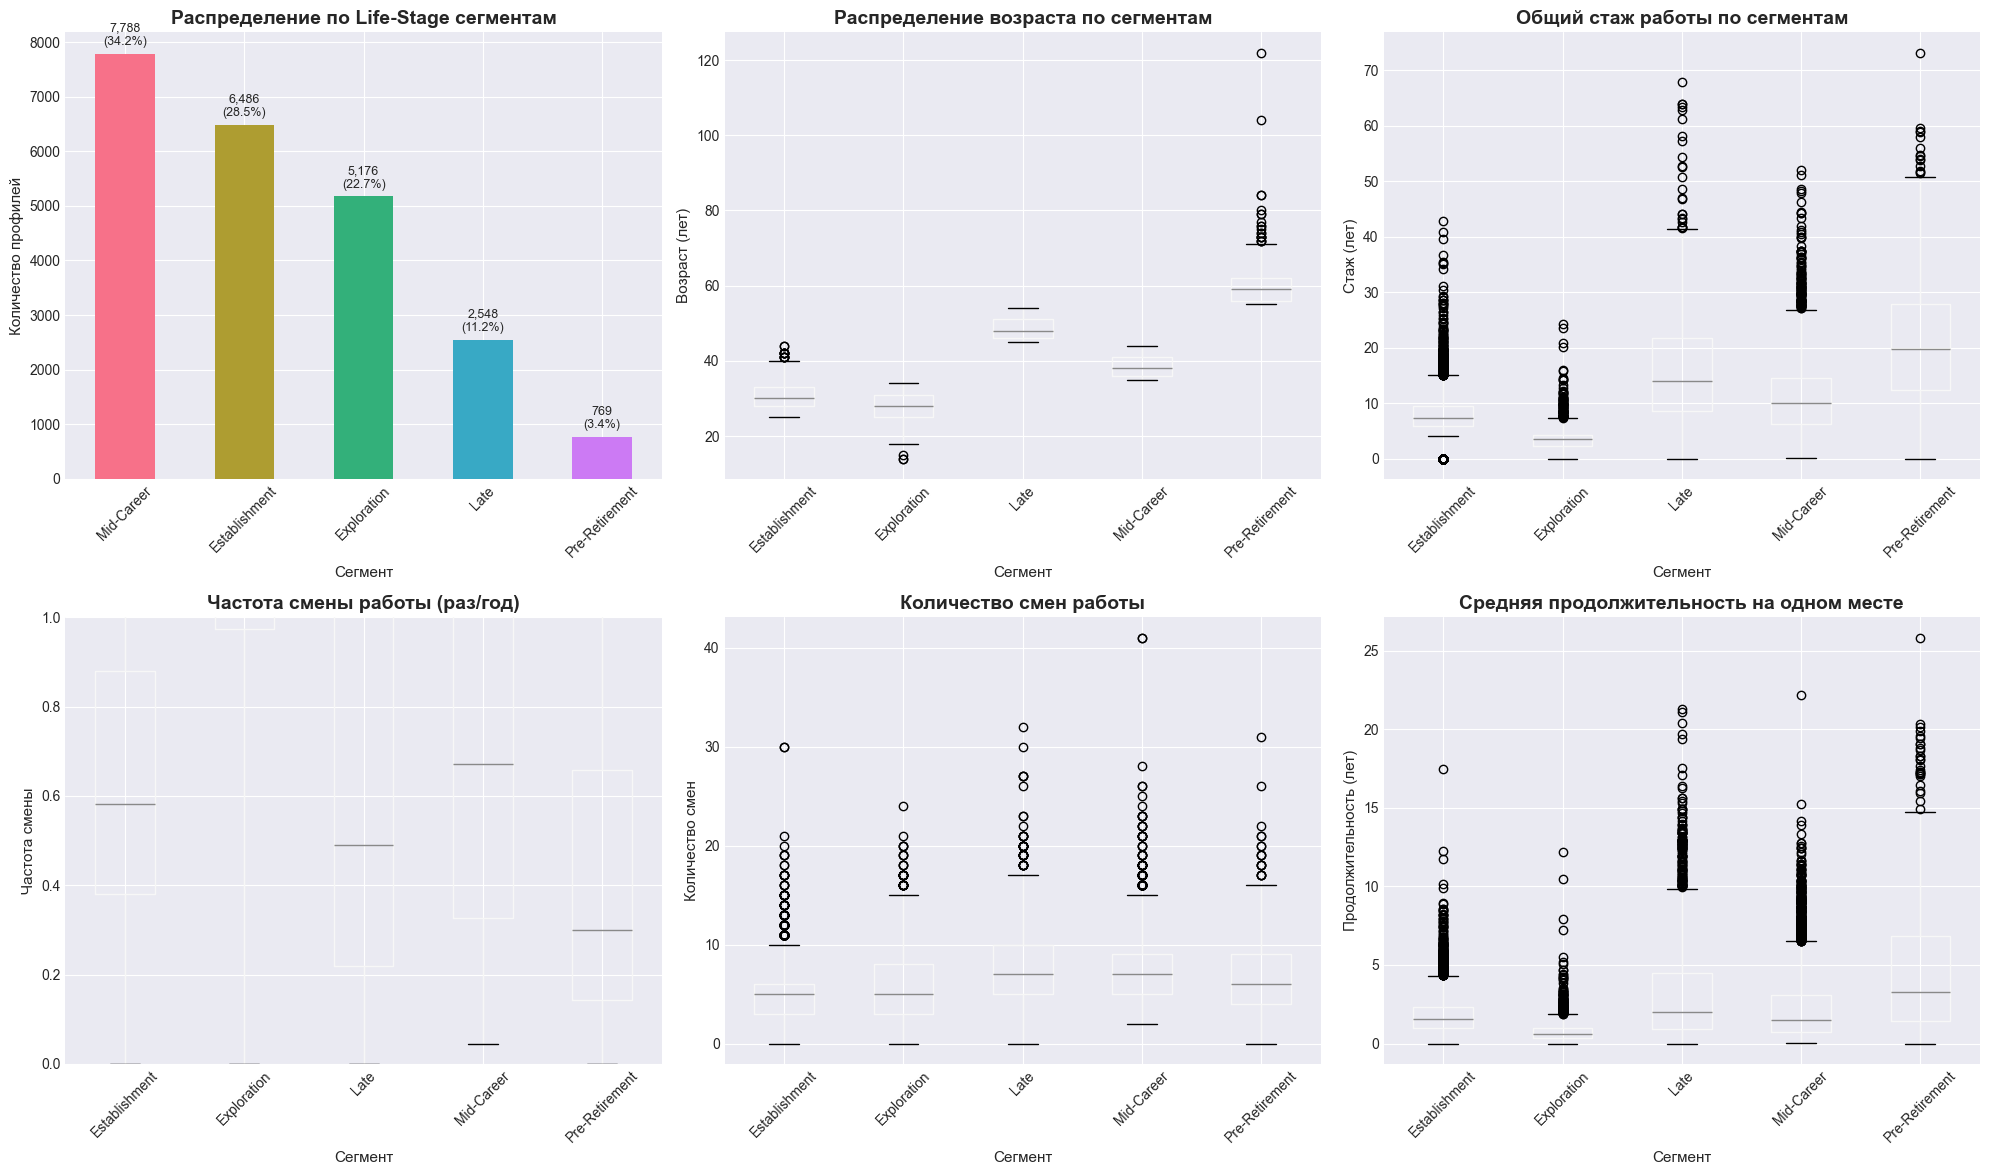

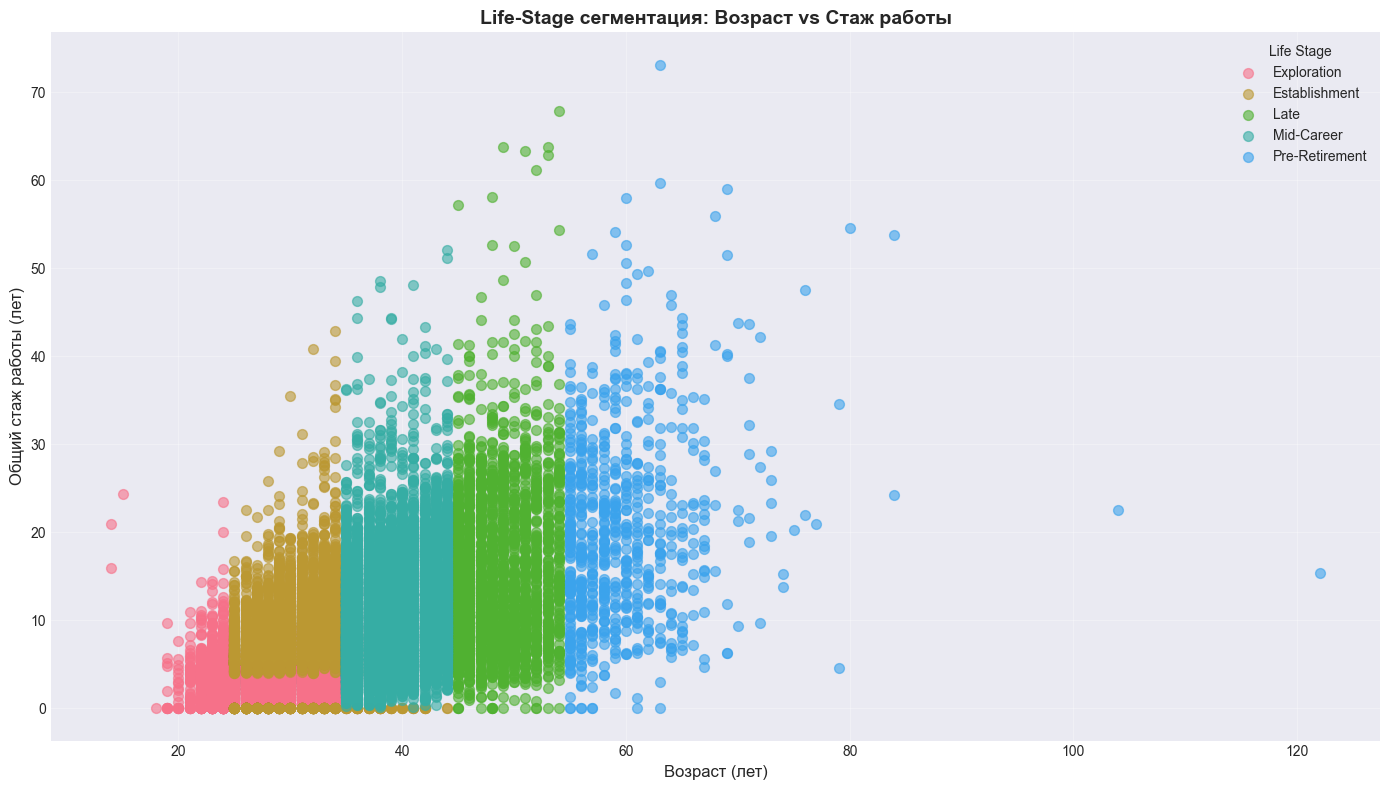


✓ Результаты сегментации экспортированы в 'life_stage_segments.csv'


In [ ]:


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def calculate_career_metrics(df):
    """
    Рассчитывает ключевые карьерные метрики для life-stage сегментации
    """
    df_analysis = df.copy()
    
    # 1. Общий стаж работы (в месяцах)
    job_duration_cols = [col for col in df.columns if 'job_' in col and '_duration_months' in col]
    df_analysis['total_work_experience_months'] = df[job_duration_cols].sum(axis=1)
    df_analysis['total_work_experience_years'] = df_analysis['total_work_experience_months'] / 12
    
    # 2. Количество смен работы
    df_analysis['job_changes'] = df['experience_count']
    
    # 3. Частота смены работы (количество смен в год)
    df_analysis['job_change_frequency'] = np.where(
        df_analysis['total_work_experience_years'] > 0,
        df_analysis['job_changes'] / df_analysis['total_work_experience_years'],
        0
    )
    
    # 4. Средняя продолжительность работы на одном месте (в годах)
    df_analysis['avg_job_duration_years'] = np.where(
        df_analysis['job_changes'] > 0,
        df_analysis['total_work_experience_years'] / df_analysis['job_changes'],
        df_analysis['total_work_experience_years']
    )
    
    # 5. Работает ли сейчас (проверяем is_current для всех позиций)
    current_job_cols = [col for col in df.columns if 'job_' in col and '_is_current' in col]
    df_analysis['is_currently_employed'] = df[current_job_cols].any(axis=1).astype(int)
    
    # 6. Длительность текущей работы (если есть)
    for i in range(1, 12):
        if f'job_{i}_is_current' in df.columns and f'job_{i}_duration_months' in df.columns:
            mask = df[f'job_{i}_is_current'] == 1
            if mask.any():
                df_analysis.loc[mask, 'current_job_duration_months'] = df.loc[mask, f'job_{i}_duration_months']
    
    if 'current_job_duration_months' not in df_analysis.columns:
        df_analysis['current_job_duration_months'] = 0
    
    df_analysis['current_job_duration_years'] = df_analysis['current_job_duration_months'] / 12
    
    return df_analysis


def assign_life_stage(row):
    """
    Присваивает life-stage сегмент на основе возраста и карьерных характеристик
    
    Стадии:
    1. Exploration (Исследование): 18-25 лет, начало карьеры
    2. Establishment (Становление): 25-35 лет, активное развитие
    3. Mid-Career (Середина карьеры): 35-45 лет, стабилизация/рост
    4. Late Career (Поздняя карьера): 45-55 лет, опыт и наставничество
    5. Pre-Retirement (Предпенсионная): 55+ лет, подготовка к завершению
    """
    age = row['age']
    job_changes = row['job_changes']
    avg_duration = row['avg_job_duration_years']
    total_exp = row['total_work_experience_years']
    change_freq = row['job_change_frequency']
    
    # Если возраст не указан, используем только стаж
    if pd.isna(age):
        if total_exp < 5:
            return 'Exploration'
        elif total_exp < 10:
            return 'Establishment'
        elif total_exp < 20:
            return 'Mid-Career'
        elif total_exp < 30:
            return 'Late Career'
        else:
            return 'Pre-Retirement'
    
    # Основная логика на основе возраста с корректировками по карьерным метрикам
    if age < 25:
        return 'Exploration'
    
    elif 25 <= age < 35:
        # В этом возрасте высокая частота смены работы (>0.5 в год) может указывать на то, что человек все еще в фазе исследования
        if change_freq > 0.5 and total_exp < 5:
            return 'Exploration'
        return 'Establishment'
    
    elif 35 <= age < 45:
        # Если человек часто меняет работу в этом возрасте (>0.4 в год), возможно карьерный кризис или смена направления
        if change_freq > 0.4:
            return 'Mid-Career (Transitioning)'
        # Если малый стаж (<5 лет), возможна смена карьеры
        elif total_exp < 5:
            return 'Establishment (Career Change)'
        return 'Mid-Career'
    
    elif 45 <= age < 55:
        # Редкие смены работы (низкая частота) = стабильность
        if change_freq < 0.15:
            return 'Late Career (Stable)'
        # Частые смены могут указывать на проблемы или консалтинг
        elif change_freq > 0.3:
            return 'Late Career (Active)'
        return 'Late Career'
    
    else:  # 55+
        if change_freq < 0.1:
            return 'Pre-Retirement (Stable)'
        else:
            return 'Pre-Retirement (Active)'


def create_life_stage_segments(df):
    """
    Создает life-stage сегментацию
    """
    df_segmented = calculate_career_metrics(df)
    
    # Применяем сегментацию
    df_segmented['life_stage'] = df_segmented.apply(assign_life_stage, axis=1)
    
    # Упрощенная категория (без подкатегорий)
    df_segmented['life_stage_simple'] = df_segmented['life_stage'].str.split(' ').str[0]
    
    return df_segmented


def analyze_segments(df_segmented):
    """
    Анализирует характеристики каждого сегмента
    """
    print("="*80)
    print("LIFE-STAGE СЕГМЕНТАЦИЯ: АНАЛИЗ")
    print("="*80)
    
    # Общая статистика
    total = len(df_segmented)
    print(f"\nОбщее количество профилей: {total:,}")
    
    # Распределение по сегментам
    print("\n" + "="*80)
    print("РАСПРЕДЕЛЕНИЕ ПО LIFE-STAGE СЕГМЕНТАМ")
    print("="*80)
    
    segment_dist = df_segmented['life_stage'].value_counts().sort_index()
    for segment, count in segment_dist.items():
        pct = (count / total) * 100
        print(f"{segment:35s}: {count:6,d} ({pct:5.2f}%)")
    
    # Характеристики по сегментам
    print("\n" + "="*80)
    print("ХАРАКТЕРИСТИКИ СЕГМЕНТОВ")
    print("="*80)
    
    segments_simple = df_segmented['life_stage_simple'].unique()
    
    for segment in ['Exploration', 'Establishment', 'Mid-Career', 'Late', 'Pre-Retirement']:
        mask = df_segmented['life_stage_simple'].str.contains(segment, na=False)
        if mask.sum() == 0:
            continue
            
        segment_data = df_segmented[mask]
        
        print(f"\n{segment.upper()}")
        print("-" * 80)
        print(f"Количество: {len(segment_data):,}")
        print(f"Средний возраст: {segment_data['age'].mean():.1f} лет")
        print(f"Средний стаж: {segment_data['total_work_experience_years'].mean():.1f} лет")
        print(f"Среднее кол-во смен работы: {segment_data['job_changes'].mean():.1f}")
        print(f"Средняя частота смены (раз/год): {segment_data['job_change_frequency'].mean():.2f}")
        print(f"Средняя продолжительность на одном месте: {segment_data['avg_job_duration_years'].mean():.1f} лет")
        print(f"Сейчас работает: {(segment_data['is_currently_employed'].sum() / len(segment_data) * 100):.1f}%")
    
    return segment_dist


def visualize_segments(df_segmented, segment_dist):
    """
    Визуализирует life-stage сегментацию
    """
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Распределение по сегментам (упрощенное)
    ax1 = plt.subplot(2, 3, 1)
    simple_dist = df_segmented['life_stage_simple'].value_counts()
    colors = sns.color_palette("husl", len(simple_dist))
    simple_dist.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title('Распределение по Life-Stage сегментам', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Сегмент', fontsize=11)
    ax1.set_ylabel('Количество профилей', fontsize=11)
    ax1.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(simple_dist):
        ax1.text(i, v + 100, f'{v:,}\n({v/len(df_segmented)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=9)
    
    # 2. Возраст по сегментам
    ax2 = plt.subplot(2, 3, 2)
    df_segmented.boxplot(column='age', by='life_stage_simple', ax=ax2)
    ax2.set_title('Распределение возраста по сегментам', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Сегмент', fontsize=11)
    ax2.set_ylabel('Возраст (лет)', fontsize=11)
    plt.suptitle('')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Стаж работы по сегментам
    ax3 = plt.subplot(2, 3, 3)
    df_segmented.boxplot(column='total_work_experience_years', by='life_stage_simple', ax=ax3)
    ax3.set_title('Общий стаж работы по сегментам', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Сегмент', fontsize=11)
    ax3.set_ylabel('Стаж (лет)', fontsize=11)
    plt.suptitle('')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Частота смены работы по сегментам
    ax4 = plt.subplot(2, 3, 4)
    df_segmented.boxplot(column='job_change_frequency', by='life_stage_simple', ax=ax4)
    ax4.set_title('Частота смены работы (раз/год)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Сегмент', fontsize=11)
    ax4.set_ylabel('Частота смены', fontsize=11)
    plt.suptitle('')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylim(0, 1) 
    
    # 5. Количество смен работы по сегментам
    ax5 = plt.subplot(2, 3, 5)
    df_segmented.boxplot(column='job_changes', by='life_stage_simple', ax=ax5)
    ax5.set_title('Количество смен работы', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Сегмент', fontsize=11)
    ax5.set_ylabel('Количество смен', fontsize=11)
    plt.suptitle('')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Средняя продолжительность работы на одном месте
    ax6 = plt.subplot(2, 3, 6)
    df_segmented.boxplot(column='avg_job_duration_years', by='life_stage_simple', ax=ax6)
    ax6.set_title('Средняя продолжительность на одном месте', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Сегмент', fontsize=11)
    ax6.set_ylabel('Продолжительность (лет)', fontsize=11)
    plt.suptitle('')
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительная визуализация: scatter plot возраст vs стаж с цветовым кодированием
    fig2, ax = plt.subplots(figsize=(14, 8))
    
    for segment in df_segmented['life_stage_simple'].unique():
        if pd.isna(segment):
            continue
        mask = df_segmented['life_stage_simple'] == segment
        segment_data = df_segmented[mask]
        
        ax.scatter(segment_data['age'], 
                  segment_data['total_work_experience_years'],
                  label=segment, 
                  alpha=0.6, 
                  s=50)
    
    ax.set_xlabel('Возраст (лет)', fontsize=12)
    ax.set_ylabel('Общий стаж работы (лет)', fontsize=12)
    ax.set_title('Life-Stage сегментация: Возраст vs Стаж работы', 
                fontsize=14, fontweight='bold')
    ax.legend(title='Life Stage', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def export_segments(df_segmented, output_file='life_stage_segments.csv'):
    """
    Экспортирует результаты сегментации
    """
    export_cols = ['url', 'age', 'life_stage', 'life_stage_simple',
                   'total_work_experience_years', 'job_changes', 
                   'job_change_frequency', 'avg_job_duration_years',
                   'is_currently_employed', 'current_job_duration_years']
    

    export_cols = [col for col in export_cols if col in df_segmented.columns]
    
    df_export = df_segmented[export_cols].copy()
    df_export.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n✓ Результаты сегментации экспортированы в '{output_file}'")
    
    return df_export


df = create_life_stage_segments(df)
segment_dist = analyze_segments(df)
visualize_segments(df, segment_dist)
df_export = export_segments(df)
    
    

In [177]:
df.columns

Index(['url', 'title', 'location', 'age', 'gender', 'salary', 'skills',
       'skills_count', 'about', 'experience_json', 'experience_count',
       'education_json', 'education_count', 'education_level',
       'additional_education_json', 'additional_education_count',
       'resume_language', 'job_1_position', 'job_1_company', 'job_1_period',
       'job_1_description', 'job_2_position', 'job_2_company', 'job_2_period',
       'job_2_description', 'job_3_position', 'job_3_company', 'job_3_period',
       'job_3_description', 'job_4_position', 'job_4_company', 'job_4_period',
       'job_4_description', 'job_1_duration_months', 'job_1_is_current',
       'job_2_duration_months', 'job_2_is_current', 'job_3_duration_months',
       'job_3_is_current', 'job_4_duration_months', 'job_4_is_current',
       'edu_1_org', 'edu_1_major', 'edu_1_period', 'edu_2_org', 'edu_2_major',
       'edu_2_period', 'edu_3_org', 'edu_3_major', 'edu_3_period',
       'best_university_rank', 'best_universit

In [178]:
df[['total_work_experience_months', 'total_work_experience_years',
    'job_changes', 'job_change_frequency', 'avg_job_duration_years',
    'is_currently_employed', 'current_job_duration_months',
    'current_job_duration_years', 'life_stage', 'life_stage_simple']].sample(5)


,total_work_experience_months,total_work_experience_years,job_changes,job_change_frequency,avg_job_duration_years,is_currently_employed,current_job_duration_months,current_job_duration_years,life_stage,life_stage_simple
20038,368.0,30.666667,2,0.065217,15.333333,0,NaN,NaN,Late Career (Stable),Late
12135,25.0,2.083333,8,3.840000,0.260417,0,NaN,NaN,Exploration,Exploration
4897,60.0,5.000000,4,0.800000,1.250000,1,23.0,1.916667,Establishment,Establishment
17100,221.0,18.416667,8,0.434389,2.302083,0,NaN,NaN,Pre-Retirement (Active),Pre-Retirement
776,89.0,7.416667,4,0.539326,1.854167,0,NaN,NaN,Establishment,Establishment


<a id="rfm"></a>
## 8. RFM-Сегментация Кандидатов для IT-Рынка

**Классическая RFM-сегментация** (Recency, Frequency, Monetary) — это метод, традиционно используемый для оценки потребительского поведения. Мы хотим адаптировать его для HR-аналитики для оценки **карьерного профиля** кандидата, помогая приоритизировать резюме по **стабильности, опыту и риску**.

Мы хотим создать три числовых признака (`R_Score`, `F_Score`, `M_Score`), которые будут использоваться для моделирования.Сегментация основана на присвоении баллов (1–5) карьерным метрикам с учетом **специфики IT-рынка**, где очень длительный стаж может также указывать на стагнацию.

| Метрика | Столбец (Основа) | Логика | Score 5 (Лучший Показатель) | Score 1 (Худший Показатель) |
| :---: | :--- | :--- | :--- | :--- |
| **R (Стаблильность)** | `current_job_duration_months` / `job_1_duration_months` | **Нелинейная** | **Оптимальная Стабильность** (2–5 лет, 24–60 мес.). | **Высокая Текучесть** (<1 года). |
| **F (Частота)** | `job_change_frequency` | **Инвертированный Квантиль** | **Самая Низкая Частота** смены работы (самый стабильный). | **Самая Высокая Частота** смены работы (наименее стабильный). |
| **M (Масштаб)** | `total_work_experience_years` | **Линейный Квантиль** | **Максимальный** общий опыт (эксперт). | **Минимальный** общий опыт (новичок). |

**Важная Нелинейность (R-Score):** Чтобы учесть риск стагнации в IT, стаж **более 7 лет (>84 мес.)** получает **Score 3**, который ниже, чем **Score 4** (за 5–7 лет) и **Score 5** (за 2–5 лет).

---

В результате применения логики RFM-Scoring в датасет **`df`** были добавлены следующие ключевые столбцы:

| Новый столбец | Описание |
| :--- | :--- |
| **`R_Score`** | **Ключевой числовой признак (1-5).** Рейтинг стабильности текущего места (с учетом нелинейности). |
| **`F_Score`** | **Ключевой числовой признак (1-5).** Рейтинг стабильности карьеры (обратный частоте смены). |
| **`M_Score`** | **Ключевой числовой признак (1-5).** Рейтинг общего опыта (по квантилям). |
| **`RFM_Code`** | Категориальный признак, объединяющий три оценки (Например, '555' — Идеальный кандидат). |

In [ ]:
import pandas as pd
import numpy as np

# Установим количество квантилей для сегментации M и F
N_QUANTILES = 5

required_cols = ['total_work_experience_years', 'job_change_frequency', 
                 'current_job_duration_months', 'job_1_duration_months', 
                 'is_currently_employed']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Критическая ошибка: Столбец '{col}' отсутствует в DataFrame. RFM-сегментация невозможна. Проверьте предыдущие шаги.")

# 1.1 Создание метрики M в месяцах (временный столбец)
df['total_work_experience_months'] = df['total_work_experience_years'] * 12
df['total_work_experience_months'] = df['total_work_experience_months'].fillna(0)

df['job_change_frequency'] = df['job_change_frequency'].fillna(df['job_change_frequency'].median())

# 1.3 Очистка R метрик (Заполнение пропусков для использования в логике)
df['current_job_duration_months'] = df['current_job_duration_months'].fillna(0)
df['job_1_duration_months'] = df['job_1_duration_months'].fillna(0)
df['is_currently_employed'] = df['is_currently_employed'].fillna(False) 

df['R_metric_final_months'] = df['current_job_duration_months'].copy()

unemployed_mask = (df['is_currently_employed'] == False)

# Для безработных: R-метрика = длительность их последней завершенной работы (job_1)
df.loc[unemployed_mask, 'R_metric_final_months'] = \
    df.loc[unemployed_mask, 'job_1_duration_months']


# ========================= 2. Расчет R-Score (Нелинейный) =========================

conditions_r = [
    # 5: Оптимальная стабильность (2 до 5 лет -> 24 до 60 месяцев)
    (df['R_metric_final_months'] >= 24) & (df['R_metric_final_months'] <= 60),
    # 4: Очень высокая стабильность (5 до 7 лет -> 60 до 84 месяцев)
    (df['R_metric_final_months'] > 60) & (df['R_metric_final_months'] <= 84),
    # 3: Потенциальная стагнация (> 7 лет -> > 84 месяцев)
    (df['R_metric_final_months'] > 84),
    # 2: Короткая стабильность (1 до 2 лет -> 12 до 24 месяцев)
    (df['R_metric_final_months'] >= 12) & (df['R_metric_final_months'] < 24),
    # 1: Очень короткая (< 1 года -> < 12 месяцев)
    (df['R_metric_final_months'] < 12)
]

choices_r = [5, 4, 3, 2, 1]
df['R_Score'] = np.select(conditions_r, choices_r, default=1)


# ========================= 3. Расчет F-Score (Линейный, Инвертированный) =========================

df['F_Score_Temp'] = pd.qcut(
    df['job_change_frequency'],
    q=N_QUANTILES,
    labels=False,
    duplicates='drop'
)
df['F_Score'] = N_QUANTILES - df['F_Score_Temp']


# ========================= 4. Расчет M-Score (Линейный) =========================

df['M_Score'] = pd.qcut(
    df['total_work_experience_months'],
    q=N_QUANTILES,
    labels=False,
    duplicates='drop'
) + 1


# ========================= 5. Финальная Сегментация и Очистка =========================

df['RFM_Code'] = (
    df['R_Score'].astype(str) + 
    df['F_Score'].astype(str) + 
    df['M_Score'].astype(str)
)

del df['F_Score_Temp']
del df['total_work_experience_months']
del df['R_metric_final_months']

print("==================================================")
print("RFM-сегментация завершена. Учтены безработные кандидаты.")
print("\nПроверка итоговых признаков (R, F, M, RFM_Code):")
print(df[['R_Score', 'F_Score', 'M_Score', 'RFM_Code']].sample(5))

RFM-сегментация завершена. Учтены безработные кандидаты.

Проверка итоговых признаков (R, F, M, RFM_Code):
       R_Score  F_Score  M_Score RFM_Code
11639        2        1        2      212
653          2        2        2      222
8235         3        5        5      355
9962         2        1        1      211
15194        1        2        1      121


In [195]:
df.columns

Index(['url', 'title', 'location', 'age', 'gender', 'salary', 'skills',
       'skills_count', 'about', 'experience_json', 'experience_count',
       'education_count', 'education_level', 'additional_education_count',
       'resume_language', 'job_1_position', 'job_1_company', 'job_1_period',
       'job_1_description', 'job_2_position', 'job_2_company', 'job_2_period',
       'job_2_description', 'job_3_position', 'job_3_company', 'job_3_period',
       'job_3_description', 'job_4_position', 'job_4_company', 'job_4_period',
       'job_4_description', 'job_1_duration_months', 'job_1_is_current',
       'job_2_duration_months', 'job_2_is_current', 'job_3_duration_months',
       'job_3_is_current', 'job_4_duration_months', 'job_4_is_current',
       'edu_1_org', 'edu_1_major', 'edu_1_period', 'edu_2_org', 'edu_2_major',
       'edu_2_period', 'edu_3_org', 'edu_3_major', 'edu_3_period',
       'best_university_rank', 'title_norm', 'seniority',
       'total_work_experience_years', 'job

In [181]:

df.drop(columns=['additional_education_json',
    'education_json',
    'best_university_name',
    'life_stage'], axis=1, inplace=True)

<a id="data_structure_final"></a>
## Структура Финального Датасета

Финальный датасет включает исходные поля, которые были очищены и трансформированы, а также множество новых, **сгенерированных признаков**.

### 1. Очищенные Исходные Признаки

* **`url`**: Ссылка на резюме.
* **`title`**: Желаемая должность. **`title_norm`** **Нормализована** (унифицированы названия, удалены лишние символы).
* **`location`**: Город проживания. **Очищен и унифицирован** (приведен к стандартному написанию).
* **`age`**: Возраст кандидата. **Очищен** и преобразован в числовой формат (`float64`).
* **`gender`**: Пол кандидата. **Трансформирован** в бинарный код (0 или 1).
* **`salary`**: Желаемая зарплата. **Очищена**, валюты приведены к **единой валюте (RUB)**, диапазоны усреднены.
* **`about`**: Текстовое поле "О себе".
* **`skills`**: Список ключевых навыков. После обработки сохранен в normalized_skill_features.csv
* **`skills_count`**: Количество указанных навыков.
* **`resume_language`**: Язык, на котором составлено резюме.
* **`experience_json`**: Исходный JSON с полной историей работы (сохранен).
* **`experience_count`**: Общее количество мест работы.
* **`education_json`**: Исходный JSON с деталями об образовании (сохранен).
* **`education_count`**: Количество записей об основном образовании.
* **`education_level`**: Уровень образования. (Используется для кодирования).
* **`additional_education_json`**: Исходный JSON с информацией о курсах.
* **`additional_education_count`**: Количество пройденных курсов/сертификатов.

---

### Experience

#### Детали последних мест работы (до 4-х)
* **`job_1_position`**: Должность на **последнем** месте работы.
* **`job_1_company`**: Название компании на последнем месте работы.
* **`job_1_period`**: Срок работы на последнем месте в текстовом виде.
* **`job_1_description`**: Описание обязанностей на последнем месте.
* **`job_1_duration_months`**: Длительность работы на последнем месте **в месяцах** (рассчитана).
* **`job_1_is_current`**: Флаг: работает ли кандидат на этой позиции **сейчас**.
* **`job_2_position`** и **`job_2_company`**: Детали второго с конца места работы.
* **`job_2_period`** и **`job_2_description`**: Срок и описание обязанностей второго места работы.
* **`job_2_duration_months`** и **`job_2_is_current`**: Длительность и статус второго места работы.
* *(Аналогичные поля для `job_3` и `job_4`)*
* **`is_top_it_company_flag`**: входит ли компания в топ айти компаний

* **`total_work_experience_years`**: **Общий стаж работы** (суммарная длительность всех работ) в годах.
* **`job_changes`**: Общее количество **смен работы**.
* **`job_change_frequency`**: **Частота смены работы** (количество смен / общий стаж).
* **`avg_job_duration_years`**: **Средняя длительность** работы на одном месте в годах.
* **`is_currently_employed`**: Флаг: работает ли кандидат **на текущий момент**.
* **`current_job_duration_months`** и **`current_job_duration_years`**: Длительность работы на текущей позиции в месяцах и годах (если трудоустроен).

---

### Education

#### Детали основного образования (до 3-х записей)
* **`edu_1_org`**: Название ВУЗа по первой записи об образовании.
* **`edu_1_major`**: Направление/специальность по первой записи.
* **`edu_1_period`**: Год окончания обучения (период) по первой записи.
* *(Аналогичные поля для `edu_2` и `edu_3`)*
* **`best_university_rank`**: Флаг: входит ли ВУЗ, где обучался, в рейтинг топовых вузов .
* **`best_university_name`**: Название лучшего ВУЗа.

---

### 4. Сегментационные и RFM-Признаки

* **`life_stage_simple`**: **Упрощенный сегмент "Жизненный цикл"**.
* **`R_Score`**: **Recency Score** (Своевременность) — оценка активности кандидата.
* **`F_Score`**: **Frequency Score** (Частота) — оценка частоты смены мест работы.
* **`M_Score`**: **Monetary Score** (Ценность) — оценка желаемой или расчетной зарплаты.
* **`RFM_Code`**: **Финальный RFM-код** (например, "515").